In [11]:
import datetime as datetime
import pandas as pd
import numpy as np
#import numpy_financial as npf
from itertools import accumulate
import absbox as abs
from absbox import API, SPV, Generic, mkDealsBy, setDealsBy,prodDealsBy, viz      #, Portfolio, Risk, Performance, Utils, Data, Analytics, Market, Risk, Utils, Data, Analytics, Market
from absbox.local.analytics import irr, run_yield_table, flow_by_scenario       #npv, 
from absbox.local.util import positionFlow
from dateutil.relativedelta import relativedelta  

from tabulate import tabulate
from itertools import accumulate
from pyxirr import xirr
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates  
from mpl_toolkits.mplot3d import axes3d
import time
#from scipy import optimize
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter  
#import seaborn as sns   
import warnings
from lenses import lens
#import plotly.graph_objects as go
#import plotly.express as px
import math


# Suppress FutureWarning messages
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

#CI_DB = DBase()
localAPI = API("https://absbox.org/api/dev",check=False)
#localAPI = API("http://localhost:8081",check=False)

#cal = DateCalendar(CalendarTypes.CAN)
#today = datetime.datetime.today()
#pricedate = cal.addBusDays(dateFromDatetime(today),-1)
#valDate = pricedate
#prcEnv = PricingEnvironment(valDate=valDate, 
#                            currencies = {'USD':'USD','CAD':'CAD','EUR':'EUR'})
# prcEnv.ratesCurves['EUR']
# forward_euribor = float(prcEnv.ratesCurves['EUR'].instFwd(valDate.addTenor('57D')))
# forward_euribor

Connecting engine server -> https://absbox.org/api/dev

✅Connected, local lib:0.26.4, server:0.27.7

In [14]:
# Pool assumptions 
original_pool_balance = 7_000_000_000
original_pool_term = 3*12
#base_rate = float(prcEnv.ratesCurves['EUR'].instFwd(valDate.addTenor('0D')))
base_rate =0.05 
pool_rate = 0.07 + base_rate
default_rate = 0.01     #0.002  #[0.03]*36 + [0.01]*36    #   [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 
# defaultFactor = [["2020-10-01",1.05],["2022-10-01",1.15]]
pool_cpr = 12 / original_pool_term   # amortization rate
recovery_rate = 1 - (0.3 * 0.7 + 0.15 * 0.3)   #sensitize this
recovery_lag = 6     #in months, Moody's base case assumption on defaulted assets for CLO modeling as well
cleanup_call = 0.1   
switch_trigger = 0.01   #cumulative pool rate to stop replenishment and start amortizing immediately

# Deal assumptions
start_date = '2023-09-30' 
original_deal_term = 7*12      #! change to 120
repay_month = 12               # sensitize this with [24, 30, 36, 42, 48]    
months_to_call = 12
tranche_size_equity = 0.07     #sensitize this, when set to 1, is it just the pool
tranche_size_mezz = 0.04
tranche_size_senior = 1 - tranche_size_equity - tranche_size_mezz
tranche_rate_equity = 0.0975 + base_rate     #this is coupon rate on the tranche  
tranche_rate_mezz = 0.0375 + base_rate
tranche_rate_senior = 0       #0.01 + base_rate
issue_price = 1   #can assume back leverage with a value between 0 and 1
reinvestment_rate = 0.00      #replenishment rate for the defaulted positions need to make assumptions too    #risk free rate 

# Remaining calcs
first_pay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+1)  
first_pay_date = first_pay_date.strftime('%Y-%m-%d')
repay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+repay_month)  
repay_date = repay_date.strftime('%Y-%m-%d')  
deal_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_deal_term)
deal_maturity_date = deal_maturity_date.strftime('%Y-%m-%d')  
deal_call_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+months_to_call)
deal_call_date = deal_call_date.strftime('%Y-%m-%d')  
pool_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_pool_term)
pool_maturity_date = pool_maturity_date.strftime('%Y-%m-%d')  


In [16]:
perf = ("Pool"            #this is for new assets added into the pool
        ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
        ,None
        ,None
       )

test01 = Generic(
    "TEST01"
    ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
     ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date} #! change deal date
    ,{'assets':[["Mortgage"             #this is snapshot at issuance, confirmed unchanged. this is a fact
        ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
          ,"freq":"Monthly","type":"Even","originDate":start_date}                               # even cashflow type for mortgage is basically like consumers 
          ,{"currentBalance":original_pool_balance
          ,"currentRate":pool_rate
          ,"remainTerm":original_pool_term
          ,"status":"current"}]]
        ,'issuanceStat':{"IssuanceBalance":original_pool_balance}    
      }
    ,(("acc01",{"balance":0}),("acc02",{"balance":0}))  #! change to 0
    ,(("S",{"balance":original_pool_balance * tranche_size_senior
             ,"rate":tranche_rate_senior
             ,"originBalance":original_pool_balance * tranche_size_senior
             ,"originRate":tranche_rate_senior
             ,"startDate":start_date
             ,"rateType":{"Fixed":tranche_rate_senior}
             ,"bondType":{"Sequential":None}})
      ,("M",{"balance":original_pool_balance * tranche_size_mezz
             ,"rate":tranche_rate_mezz
             ,"originBalance":original_pool_balance * tranche_size_mezz
             ,"originRate":tranche_rate_mezz
             ,"startDate":start_date
             ,"rateType":{"Fixed":tranche_rate_mezz}      #CHANGE TO FLOATING
             ,"bondType":{"Sequential":None}
             })
      ,("E",{"balance":original_pool_balance * tranche_size_equity
             ,"rate":tranche_rate_equity
             ,"originBalance":original_pool_balance * tranche_size_equity
             ,"originRate":tranche_rate_equity
             ,"startDate":start_date
             ,"rateType":{"Fixed":tranche_rate_equity}
             ,"bondType":{"Sequential":None}
             }))
    ,list()
    ,{"revolving":[
          ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
          ,['transfer',"acc02","acc01"]
          # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
          ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",{"formula":("-",("originalPoolBalance",),("poolBalance",))}]
           
         ]
      ,"amortizing":[
          ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
          ,['transfer',"acc02","acc01"]
          # ,['payPrinBySeq',"acc01",["S","M","E"]]
          # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
          ,['payPrin',"acc01",["S","M","E"]]
          ,['payIntResidual',"acc01","E"]
       ]
     }
    ,[["CollectedPrincipal","acc01"]
      ,["CollectedRecoveries","acc01"] #! add here
      ,["CollectedPrepayment","acc01"] #! add here
      ,["CollectedInterest","acc02"]]
    ,None
    ,None
    ,None    
    ,{"BeforeDistribution":
       {"dealStatusChange":
        {"condition":["any",[">=",repay_date]
                           ,[("cumPoolDefaultedRate",),">",switch_trigger]] 
        ,"effects":("newStatus","Amortizing")
        ,"status":False
        ,"curable":False}}
        }
    ,("PreClosing","Revolving")
    )

runDealAssump = [("revolving"     #this is asumption about what happens during the revolving period, we care about what assets we buy, and hows their performance
                    ,["constant"
                      ,["Mortgage"     ##this is what the new assets look like 
                        ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
                          ,"freq":"Monthly","type":"Level","originDate":repay_date}
                          ,{"currentBalance":original_pool_balance
                          ,"currentRate":pool_rate
                          ,"remainTerm":original_pool_term
                          ,"status":"current"}]]
                    ,perf)
                    ,("call",{"poolFactor":cleanup_call})]

r = localAPI.run(test01
                ,runAssump = runDealAssump
                ,poolAssump = ("Pool"
                              ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
                              ,None
                              ,None)
                ,read=True)

In [17]:
def bondIrr(result):
    clo_like_equity_tranche = result['bonds']['E']['cash']
    initial_investment = original_pool_balance * tranche_size_equity * issue_price
    clo_like_equity_tranche = pd.concat([pd.Series(-1*initial_investment, index=[start_date]), clo_like_equity_tranche])
    clo_like_equity_tranche.sort_index(inplace=True)
    return xirr(clo_like_equity_tranche.index.to_list(),clo_like_equity_tranche.to_list())

def tryDraw(txns ,bal , draws):
    if len(draws)==0:
        return txns
    else:
        draw = draws[0]
        restDraws = draws[1:]
        if bal >= draw:
            return tryDraw(txns+[draw],bal-draw,restDraws)
        else:
            return tryDraw(txns+[bal],0,restDraws)

# tryDraw([],10,[7,8,3,5,6])
# 2_363_674.759+537_281_942.150
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
# pd.set_option('display.max_rows', None)
# viz(test01)
# r['pool']['flow'].to_clipboard()

In [18]:
def srt(initBals, poolPerformance, trancheOfIntest, feeRates, reinvestRate=reinvestment_rate):
    
    poolDates = poolPerformance['pool']['flow'].index.to_list()
    beginDate = poolDates[0]
    lastDate = poolDates[-1]
    start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss','Principal', 'Prepayment']]
    start['CumLossDerived'] = start['Loss'].cumsum()

    seniorBal, mezzBal, equityBal = initBals
    mezzRate,equityRate = feeRates
    
    issuePrice = mezzBal if trancheOfIntest == "M" else equityBal
    
    # indicator only     #this considers the loss resulted writeoffs
    start.loc[:,'equityBal'] = (equityBal - start['CumLossDerived']).clip(lower=0).to_list()
    start.loc[:,'mezzBal'] =  mezzBal - (start['CumLossDerived'] - equityBal).clip(lower=0,upper=mezzBal)
    start.loc[:,'seniorBal'] = seniorBal - (start['CumLossDerived'] - equityBal - mezzBal).clip(lower=0)
    start.loc[:,'mezzLoss'] = np.maximum(start['CumLossDerived'] - equityBal, 0).clip(lower=0).to_list()  
    start.loc[:,'CumMezzLossDerived'] = start['mezzLoss'].cumsum().clip(lower=0).to_list()
    start.loc[:,'seniorLoss'] = np.maximum(start['CumLossDerived'] - equityBal - mezzBal, 0).clip(lower=0).to_list()  


    ##################PROBLEM STARTS!!!##################
    start.loc[:,'equityPrepay'] = (start.loc[:,'equityBal'] / (start.loc[:,'equityBal'] + start.loc[:,'mezzBal'] + start.loc[:,'seniorBal']) * (start.loc[:,'Principal'] + start.loc[:,'Prepayment'])).clip(lower=0).to_list()
    start.loc[:,'mezzPrepay'] = (start.loc[:,'mezzBal'] / (start.loc[:,'equityBal'] + start.loc[:,'mezzBal'] + start.loc[:,'seniorBal']) * (start.loc[:,'Principal'] + start.loc[:,'Prepayment'])).clip(lower=0).to_list()
    start.loc[:,'seniorPrepay'] = (start.loc[:,'seniorBal'] / (start.loc[:,'equityBal'] + start.loc[:,'mezzBal'] + start.loc[:,'seniorBal']) * (start.loc[:,'Principal'] + start.loc[:,'Prepayment'])).clip(lower=0).to_list()
    ##################PROBLEM ENDS!!!##################

    if trancheOfIntest == "M" :     #shows which tranche we're investing in
        start.loc[:,'mezzBal - feeStream'] = start['mezzBal'] * mezzRate / 12
    else:
        start.loc[:,'equityBal - feeStream'] = start['equityBal'] * equityRate / 12

    #start.loc[:,'reimburseLoss'] = start['Loss']

    # invest related cashflow
    start.loc[:,'cashAccountChange'] = 0
    ## account init bals
    start.loc[:,'cashAccountBal'] = issuePrice
    ## loss reimbursement
    start.loc[:,'reimburseLoss'] = 0

    if trancheOfIntest == "M" :     #shows which tranche we're investing in
        reimburseAmt = tryDraw([], issuePrice ,start.loc[:,'mezzLoss'].to_list())
    else:
        reimburseAmt = tryDraw([], issuePrice ,start.loc[:,'Loss'].to_list())
    
    ##################PROBLEM STARTS!!!##################
    if trancheOfIntest == "M" :     #shows which tranche we're investing in
        prepayAmt = 0 #    start.loc[:,'mezzPrepay'].to_list()
    else:
        prepayAmt = 0 #    start.loc[:,'equityPrepay'].to_list()
    ##################PROBLEM ENDS!!!##################

    start.loc[:,'reimburseLoss'] = reimburseAmt
    start.loc[:,'amort'] = prepayAmt
    start.loc[:,'cashAccountChange'] = start.loc[:,'cashAccountChange'] + -1*start['reimburseLoss'] + -1*start['amort'] 
    ## init deposit with price
    start.loc[beginDate, 'cashAccountChange'] = start.loc[beginDate, 'cashAccountChange'] + issuePrice
    ### calculate account balance with 
    start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
    ### withdraw all cash from account at last day
    start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'cashAccountBal']
    ## reinvestment int
    start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
    ## net cashflow
    start.loc[:,'netCashflow'] = 0 
    # the above takes care of the 2 sources of inflows: guarantee fee income and cash account reinvestment interest
    
    ## init deposit
    start.loc[beginDate,'netCashflow'] = -1 * issuePrice
    ## add premiums to net cashflow
    if trancheOfIntest == "M" :
        start.loc[:,'netCashflow'] += start['mezzBal - feeStream'].fillna(0)
    else:
        start.loc[:,'netCashflow'] += start['equityBal - feeStream'].fillna(0)
    ## add reinvestment int to net cashflow
    start.loc[:,'netCashflow'] += start['cashAccountInt']
    ## draw remain cash from account at last period
    start.loc[lastDate,'netCashflow'] += start.loc[lastDate,'cashAccountBal']    
    return start

stackPortion = (tranche_size_senior,tranche_size_mezz,tranche_size_equity)
ganranteeFeeRates = (tranche_rate_mezz,tranche_rate_equity)
projectCf_M = srt( [ original_pool_balance * x for x in stackPortion ]
                , r
                , "M"
                , ganranteeFeeRates #(0.12,tranche_rate_equity)
                , reinvestRate=reinvestment_rate)
projectCf_E = srt( [ original_pool_balance * x for x in stackPortion ]
                , r
                , "E"
                , ganranteeFeeRates #(0.12,tranche_rate_equity)
                , reinvestRate=reinvestment_rate)

def returns(projectCf_M, projectCf_E):
    return_summary = pd.DataFrame(columns=['IRR', 'MOIC', 'Default', 'Recovery', 'Loss'])  
    irr_mezz = xirr(projectCf_M.index.to_list(),projectCf_M['netCashflow'].to_list())
    irr_equity = xirr(projectCf_E.index.to_list(),projectCf_E['netCashflow'].to_list())
    moic_mezz = projectCf_M['netCashflow'].cumsum() + original_pool_balance * tranche_size_mezz * issue_price
    moic_mezz = moic_mezz.tail(1) / (original_pool_balance * tranche_size_mezz * issue_price)
    moic_equity = projectCf_E['netCashflow'].cumsum() + original_pool_balance * tranche_size_equity * issue_price
    moic_equity = moic_equity.tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
    loss_mezz = projectCf_M['CumMezzLossDerived'].tail(1) / (original_pool_balance * tranche_size_mezz * issue_price)
    loss_equity = r['pool']['flow']['CumLoss'].tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
    recovery_mezz = loss_mezz / (1 - recovery_rate)
    recovery_equity = r['pool']['flow']['CumRecovery'].tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
    default_mezz = loss_mezz + recovery_mezz
    default_equity = r['pool']['flow']['CumDefault'].tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
    return_summary.loc['Mezzanine'] = [irr_mezz, moic_mezz[0], default_mezz[0], recovery_mezz[0], loss_mezz[0]]
    return_summary.loc['Equity'] = [irr_equity, moic_equity[0], default_equity[0], recovery_equity[0], loss_equity[0]]
    return_summary['IRR'] = return_summary['IRR'].map(lambda x: f'{x:.1%}')
    return_summary['MOIC'] = return_summary['MOIC'].map(lambda x: f'{x:.2f}')
    return_summary['Default'] = return_summary['Default'].map(lambda x: f'{x:.1%}')
    return_summary['Recovery'] = return_summary['Recovery'].map(lambda x: f'{x:.1%}')
    return_summary['Loss'] = return_summary['Loss'].map(lambda x: f'{x:.1%}')
    return return_summary

returns(projectCf_M, projectCf_E)
# projectCf_M.to_clipboard()
# projectCf_E.to_clipboard()

,IRR,MOIC,Default,Recovery,Loss
Mezzanine,9.4%,1.26,0.0%,0.0%,0.0%
Equity,13.5%,1.36,28.9%,20.5%,7.0%


In [22]:
pd.set_option("styler.format.thousands", ",")

In [ ]:
lastRow = None

for index, row in df.iterrows():
    
    ###logic here
    
    # reference data to last row
    
    ### logic ends
    lastRow = row
    

In [25]:
projectCf_M.style.format(thousands=",")

,Balance,Loss,CumLoss,Principal,Prepayment,CumLossDerived,equityBal,mezzBal,seniorBal,mezzLoss,CumMezzLossDerived,seniorLoss,equityPrepay,mezzPrepay,seniorPrepay,mezzBal - feeStream,cashAccountChange,cashAccountBal,reimburseLoss,amort,cashAccountInt,netCashflow
Date,,,,,,,,,,,,,,,,,,,,,,
2023-09-30,"7,000,000,000.000000",0.000000,0.000000,0.000000,0.000000,0.000000,"490,000,000.000000","280,000,000.000000","6,229,999,999.999999",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"2,041,666.666667","280,000,000","280,000,000.000000",0.000000,0,0.000000,"-277,958,333.333333"
2023-10-31,"6,799,936,113.660000",0.000000,0.000000,"194,283,888.960000",0.000000,0.000000,"490,000,000.000000","280,000,000.000000","6,229,999,999.999999",0.000000,0.000000,0.000000,"13,599,872.227200","7,771,355.558400","172,912,661.174400","2,041,666.666667",0,"280,000,000.000000",0.000000,0,0.000000,"2,041,666.666667"
2023-11-30,"6,788,874,370.790000",0.000000,0.000000,"198,606,530.390000","6,552,021.250000",0.000000,"490,000,000.000000","280,000,000.000000","6,229,999,999.999999",0.000000,0.000000,0.000000,"14,361,098.614800","8,206,342.065600","182,591,110.959600","2,041,666.666667",0,"280,000,000.000000",0.000000,0,0.000000,"2,041,666.666667"
2023-12-31,"6,777,842,497.820000",0.000000,0.000000,"203,070,515.280000","13,301,793.650000",0.000000,"490,000,000.000000","280,000,000.000000","6,229,999,999.999999",0.000000,0.000000,0.000000,"15,146,061.625100","8,654,892.357200","192,571,354.947700","2,041,666.666667",0,"280,000,000.000000",0.000000,0,0.000000,"2,041,666.666667"
2024-01-31,"6,766,099,572.970000",0.000000,0.000000,"207,655,417.550000","20,272,427.750000",0.000000,"490,000,000.000000","280,000,000.000000","6,229,999,999.999999",0.000000,0.000000,0.000000,"15,954,949.171000","9,117,113.812000","202,855,782.317000","2,041,666.666667",0,"280,000,000.000000",0.000000,0,0.000000,"2,041,666.666667"
2024-02-29,"6,756,309,411.650000",0.000000,0.000000,"212,427,703.160000","25,499,694.670000",0.000000,"490,000,000.000000","280,000,000.000000","6,229,999,999.999999",0.000000,0.000000,0.000000,"16,654,917.848100","9,517,095.913200","211,755,384.068700","2,041,666.666667",0,"280,000,000.000000",0.000000,0,0.000000,"2,041,666.666667"
2024-03-31,"6,743,913,740.380000",0.000000,0.000000,"217,275,929.460000","33,021,169.910000",0.000000,"490,000,000.000000","280,000,000.000000","6,229,999,999.999999",0.000000,0.000000,0.000000,"17,520,796.955900","10,011,883.974800","222,764,418.439300","2,041,666.666667",0,"280,000,000.000000",0.000000,0,0.000000,"2,041,666.666667"
2024-04-30,"6,732,184,996.530000","1,473,899.330000","1,473,899.330000","222,275,985.970000","39,588,415.300000","1,473,899.330000","488,526,100.670000","280,000,000.000000","6,229,999,999.999999",0.000000,0.000000,0.000000,"18,279,219.512301","10,476,782.011084","233,108,399.746615","2,041,666.666667",0,"280,000,000.000000",0.000000,0,0.000000,"2,041,666.666667"
2024-05-31,"6,720,325,880.570000","1,521,604.780000","2,995,504.110000","227,410,614.590000","46,462,798.100000","2,995,504.110000","487,004,495.890000","280,000,000.000000","6,229,999,999.999999",0.000000,0.000000,0.000000,"19,062,097.696680","10,959,626.451326","243,851,688.541994","2,041,666.666667",0,"280,000,000.000000",0.000000,0,0.000000,"2,041,666.666667"


In [180]:
PAAAAUSE

NameError: name 'PAAAAUSE' is not defined

SIMPLE CDR TEST

In [ ]:
print('\nModel Results: SIMPLE CDR TEST')

default_rates = np.arange(0.0, 0.2, 0.0002).tolist()  
df = pd.DataFrame(columns=['CDR', 'ALR', 'Mezz IRR', 'Equity IRR'])  

for default_rate in default_rates:

    perf = ("Pool"            #this is for new assets added into the pool
            ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
            ,None
            ,None
        )

    test01 = Generic(
        "TEST01"
        ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
        ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date} #! change deal date
        ,{'assets':[["Mortgage"             #this is snapshot at issuance, confirmed unchanged. this is a fact
            ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
            ,"freq":"Monthly","type":"Even","originDate":start_date}                               # even cashflow type for mortgage is basically like consumers 
            ,{"currentBalance":original_pool_balance
            ,"currentRate":pool_rate
            ,"remainTerm":original_pool_term
            ,"status":"current"}]]
            ,'issuanceStat':{"IssuanceBalance":original_pool_balance}    
        }
        ,(("acc01",{"balance":0}),("acc02",{"balance":0}))  #! change to 0
        ,(("S",{"balance":original_pool_balance * tranche_size_senior
                ,"rate":tranche_rate_senior
                ,"originBalance":original_pool_balance * tranche_size_senior
                ,"originRate":tranche_rate_senior
                ,"startDate":start_date
                ,"rateType":{"Fixed":tranche_rate_senior}
                ,"bondType":{"Sequential":None}})
        ,("M",{"balance":original_pool_balance * tranche_size_mezz
                ,"rate":tranche_rate_mezz
                ,"originBalance":original_pool_balance * tranche_size_mezz
                ,"originRate":tranche_rate_mezz
                ,"startDate":start_date
                ,"rateType":{"Fixed":tranche_rate_mezz}      #CHANGE TO FLOATING
                ,"bondType":{"Sequential":None}
                })
        ,("E",{"balance":original_pool_balance * tranche_size_equity
                ,"rate":tranche_rate_equity
                ,"originBalance":original_pool_balance * tranche_size_equity
                ,"originRate":tranche_rate_equity
                ,"startDate":start_date
                ,"rateType":{"Fixed":tranche_rate_equity}
                ,"bondType":{"Sequential":None}
                }))
        ,list()
        ,{"revolving":[
            ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
            ,['transfer',"acc02","acc01"]
            # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
            ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",{"formula":("-",("originalPoolBalance",),("poolBalance",))}]
            
            ]
        ,"amortizing":[
            ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
            ,['transfer',"acc02","acc01"]
            # ,['payPrinBySeq',"acc01",["S","M","E"]]
            # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
            ,['payPrin',"acc01",["S","M","E"]]
            ,['payIntResidual',"acc01","E"]
        ]
        }
        ,[["CollectedPrincipal","acc01"]
        ,["CollectedRecoveries","acc01"] #! add here
        ,["CollectedPrepayment","acc01"] #! add here
        ,["CollectedInterest","acc02"]]
        ,None
        ,None
        ,None    
        ,{"BeforeDistribution":
        {"dealStatusChange":
            {"condition":["any",[">=",repay_date]
                               ,[("cumPoolDefaultedRate",),">",switch_trigger]] 
                ,"effects":("newStatus","Amortizing")
                ,"status":False
                ,"curable":False}}
            }
        ,("PreClosing","Revolving")
        )

    runDealAssump = [("revolving"     #this is asumption about what happens during the revolving period, we care about what assets we buy, and hows their performance
                        ,["constant"
                        ,["Mortgage"     ##this is what the new assets look like 
                            ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
                            ,"freq":"Monthly","type":"Level","originDate":repay_date}
                            ,{"currentBalance":original_pool_balance
                            ,"currentRate":pool_rate
                            ,"remainTerm":original_pool_term
                            ,"status":"current"}]]
                        ,perf)
                        ,("call",{"poolFactor":cleanup_call})]

    r = localAPI.run(test01
                    ,runAssump = runDealAssump
                    ,poolAssump = ("Pool"
                                ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
                                ,None
                                ,None)
                    ,read=True)

    def srt(initBals, poolPerformance, trancheOfIntest, feeRates, reinvestRate=reinvestment_rate):
        
        poolDates = poolPerformance['pool']['flow'].index.to_list()
        beginDate = poolDates[0]
        lastDate = poolDates[-1]
        start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
        start['CumLossDerived'] = start['Loss'].cumsum()

        seniorBal, mezzBal, equityBal = initBals
        mezzRate,equityRate = feeRates
        
        issuePrice = mezzBal if trancheOfIntest == "M" else equityBal
        
        # indicator only     #this considers the loss resulted writeoffs
        start.loc[:,'equityBal'] = (equityBal - start['CumLossDerived']).clip(lower=0).to_list()
        start.loc[:,'mezzBal'] =  mezzBal - (start['CumLossDerived'] - equityBal).clip(lower=0,upper=mezzBal)
        start.loc[:,'seniorBal'] = seniorBal - (start['CumLossDerived'] - equityBal - mezzBal).clip(lower=0)
        start.loc[:,'mezzLoss'] = np.maximum(start['CumLossDerived'] - equityBal, 0).clip(lower=0).to_list()  
        start.loc[:,'seniorLoss'] = np.maximum(start['CumLossDerived'] - equityBal - mezzBal, 0).clip(lower=0).to_list()  

        if trancheOfIntest == "M" :     #shows which tranche we're investing in
            start.loc[:,'mezzBal - feeStream'] = start['mezzBal'] * mezzRate / 12
        else:
            start.loc[:,'equityBal - feeStream'] = start['equityBal'] * equityRate / 12

        #start.loc[:,'reimburseLoss'] = start['Loss']

        # invest related cashflow
        start.loc[:,'cashAccountChange'] = 0
        ## account init bals
        start.loc[:,'cashAccountBal'] = issuePrice
        ## loss reimbursement
        start.loc[:,'reimburseLoss'] = 0

        if trancheOfIntest == "M" :     #shows which tranche we're investing in
            reimburseAmt = tryDraw([], issuePrice ,start.loc[:,'mezzLoss'].to_list())
        else:
            reimburseAmt = tryDraw([], issuePrice ,start.loc[:,'Loss'].to_list())
        
        start.loc[:,'reimburseLoss'] = reimburseAmt
        start.loc[:,'cashAccountChange'] = start.loc[:,'cashAccountChange'] + -1*start['reimburseLoss']
        ## init deposit with price
        start.loc[beginDate, 'cashAccountChange'] = start.loc[beginDate, 'cashAccountChange'] + issuePrice
        ### calculate account balance with 
        start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
        ### withdraw all cash from account at last day
        start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'cashAccountBal']
        ## reinvestment int
        start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
        ## net cashflow
        start.loc[:,'netCashflow'] = 0 
        # the above takes care of the 2 sources of inflows: guarantee fee income and cash account reinvestment interest
        
        ## init deposit
        start.loc[beginDate,'netCashflow'] = -1 * issuePrice
        ## add premiums to net cashflow
        if trancheOfIntest == "M" :
            start.loc[:,'netCashflow'] += start['mezzBal - feeStream'].fillna(0)
        else:
            start.loc[:,'netCashflow'] += start['equityBal - feeStream'].fillna(0)
        ## add reinvestment int to net cashflow
        start.loc[:,'netCashflow'] += start['cashAccountInt']
        ## draw remain cash from account at last period
        start.loc[lastDate,'netCashflow'] += start.loc[lastDate,'cashAccountBal']    
        return start

    stackPortion = (tranche_size_senior,tranche_size_mezz,tranche_size_equity)
    ganranteeFeeRates = (tranche_rate_mezz,tranche_rate_equity)

    projectCf_M = srt( [ original_pool_balance * x for x in stackPortion ]
                    , r
                    , "M"
                    , ganranteeFeeRates #(0.12,tranche_rate_equity)
                    , reinvestRate=reinvestment_rate)
    projectCf_E = srt( [ original_pool_balance * x for x in stackPortion ]
                , r
                , "E"
                , ganranteeFeeRates #(0.12,tranche_rate_equity)
                , reinvestRate=reinvestment_rate)
    # projectCf
    #projectCf.to_clipboard()
    a = xirr(projectCf_M.index.to_list(),projectCf_M['netCashflow'].to_list())
    b = xirr(projectCf_E.index.to_list(),projectCf_E['netCashflow'].to_list())
    df = df.append({'CDR': default_rate, 'ALR': default_rate * (1 - recovery_rate), 'Mezz IRR': a, 'Equity IRR': b}, ignore_index=True)
    print('CDR: ', default_rate, ', ALR: ', default_rate * (1 - recovery_rate), ', Mezz IRR: ', a, ', Equity IRR: ', b)


Output()


Model Results: SIMPLE CDR TEST


Output()

CDR:  0.0 , ALR:  0.0 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1476430906916395


Output()

Output()

CDR:  0.0004 , ALR:  0.00010200000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.14655485037045932


Output()

CDR:  0.0006000000000000001 , ALR:  0.000153 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1460099648154947


Output()

CDR:  0.0008 , ALR:  0.00020400000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.14546456789689835


Output()

CDR:  0.001 , ALR:  0.000255 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.14491865832332207


Output()

Output()

CDR:  0.0014 , ALR:  0.000357 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.14382529675401867


Output()

Output()

CDR:  0.0018000000000000002 , ALR:  0.00045900000000000004 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1427298703193092


Output()

CDR:  0.002 , ALR:  0.00051 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.14218137965202002


Output()

CDR:  0.0022 , ALR:  0.0005610000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.14163236930531917


Output()

CDR:  0.0024000000000000002 , ALR:  0.000612 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1410828378212269


Output()

CDR:  0.0026000000000000003 , ALR:  0.0006630000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.14053278396687138


Output()

CDR:  0.0028 , ALR:  0.000714 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1399822066979694


Output()

CDR:  0.003 , ALR:  0.0007650000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1394311045272078


Output()

CDR:  0.0032 , ALR:  0.0008160000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13887947629270614


Output()

CDR:  0.0034000000000000002 , ALR:  0.000867 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13832732078297824


Output()

CDR:  0.0036000000000000003 , ALR:  0.0009180000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13777463670968965


Output()

CDR:  0.0038 , ALR:  0.000969 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13722142292624576


Output()

CDR:  0.004 , ALR:  0.00102 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13666767801786509


Output()

CDR:  0.004200000000000001 , ALR:  0.0010710000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13611340086472543


Output()

CDR:  0.0044 , ALR:  0.0011220000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1355585899166251


Output()

CDR:  0.0046 , ALR:  0.001173 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13500324415656864


Output()

Output()

CDR:  0.005 , ALR:  0.001275 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13389094285093556


Output()

CDR:  0.005200000000000001 , ALR:  0.0013260000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13333398467509322


Output()

Output()

CDR:  0.0056 , ALR:  0.001428 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13221844681151396


Output()

CDR:  0.0058000000000000005 , ALR:  0.001479 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13165986457053447


Output()

CDR:  0.006 , ALR:  0.0015300000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1311007382753473


Output()

CDR:  0.006200000000000001 , ALR:  0.0015810000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.13054106675706478


Output()

CDR:  0.0064 , ALR:  0.0016320000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12998084844849203


Output()

CDR:  0.0066 , ALR:  0.001683 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1294200822641154


Output()

CDR:  0.0068000000000000005 , ALR:  0.001734 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12885876669579424


Output()

CDR:  0.007 , ALR:  0.0017850000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12829690060074853


Output()

CDR:  0.007200000000000001 , ALR:  0.0018360000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12773448245368405


Output()

CDR:  0.0074 , ALR:  0.0018870000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1271715109422269


Output()

CDR:  0.0076 , ALR:  0.001938 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12660798472180818


Output()

CDR:  0.0078000000000000005 , ALR:  0.0019890000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12604390244863037


Output()

CDR:  0.008 , ALR:  0.00204 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1254792627998489


Output()

CDR:  0.0082 , ALR:  0.0020910000000000004 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1249140642615142


Output()

CDR:  0.008400000000000001 , ALR:  0.0021420000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12434830552184735


Output()

CDR:  0.0086 , ALR:  0.002193 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12378198532882274


Output()

CDR:  0.0088 , ALR:  0.0022440000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12321510198413287


Output()

CDR:  0.009000000000000001 , ALR:  0.002295 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12264765438185338


Output()

CDR:  0.0092 , ALR:  0.002346 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12207964106116967


Output()

CDR:  0.0094 , ALR:  0.0023970000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12151106053802233


Output()

CDR:  0.009600000000000001 , ALR:  0.002448 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12094191147649147


Output()

CDR:  0.0098 , ALR:  0.002499 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.12037219231456603


Output()

CDR:  0.01 , ALR:  0.00255 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11980190184837965


Output()

CDR:  0.0102 , ALR:  0.0026010000000000004 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11923103850009482


Output()

CDR:  0.010400000000000001 , ALR:  0.0026520000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11865960090212116


Output()

CDR:  0.0106 , ALR:  0.002703 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1180875875409724


Output()

CDR:  0.0108 , ALR:  0.0027540000000000004 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11751499696691181


Output()

CDR:  0.011000000000000001 , ALR:  0.002805 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11694182791286077


Output()

Output()

CDR:  0.0114 , ALR:  0.0029070000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11579374786601915


Output()

Output()

CDR:  0.0118 , ALR:  0.003009 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11464333575297687


Output()

CDR:  0.012 , ALR:  0.0030600000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11406725150925949


Output()

CDR:  0.0122 , ALR:  0.003111 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11349057971979071


Output()

CDR:  0.012400000000000001 , ALR:  0.0031620000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11291331902661601


Output()

CDR:  0.0126 , ALR:  0.003213 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1123354678798511


Output()

CDR:  0.0128 , ALR:  0.0032640000000000004 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11175702475590547


Output()

CDR:  0.013000000000000001 , ALR:  0.0033150000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1111779882298253


Output()

CDR:  0.0132 , ALR:  0.003366 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11059835658437314


Output()

CDR:  0.0134 , ALR:  0.0034170000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.11001812846172057


Output()

CDR:  0.013600000000000001 , ALR:  0.003468 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10943730232563961


Output()

CDR:  0.013800000000000002 , ALR:  0.0035190000000000004 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10885587654296906


Output()

CDR:  0.014 , ALR:  0.0035700000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10827384958622321


Output()

CDR:  0.0142 , ALR:  0.003621 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10769121997434371


Output()

CDR:  0.014400000000000001 , ALR:  0.0036720000000000004 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10710798614421412


Output()

CDR:  0.0146 , ALR:  0.003723 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10652414646943387


Output()

Output()

CDR:  0.015000000000000001 , ALR:  0.0038250000000000003 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10535464331786673


Output()

CDR:  0.0152 , ALR:  0.003876 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10476897680211553


Output()

CDR:  0.0154 , ALR:  0.003927 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10418269807729072


Output()

CDR:  0.015600000000000001 , ALR:  0.003978000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10359580566827473


Output()

CDR:  0.0158 , ALR:  0.0040290000000000005 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1030082978941623


Output()

CDR:  0.016 , ALR:  0.00408 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10242017311150567


Output()

CDR:  0.0162 , ALR:  0.004131 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10183142982529902


Output()

CDR:  0.0164 , ALR:  0.004182000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.10124206635886192


Output()

CDR:  0.0166 , ALR:  0.004233 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1006520810304699


Output()

CDR:  0.016800000000000002 , ALR:  0.0042840000000000005 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.1000614723249405


Output()

CDR:  0.017 , ALR:  0.004335 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0994702384027568


Output()

CDR:  0.0172 , ALR:  0.004386 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09887837770885585


Output()

CDR:  0.017400000000000002 , ALR:  0.004437000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09828588869005282


Output()

CDR:  0.0176 , ALR:  0.004488000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09769276955280416


Output()

CDR:  0.0178 , ALR:  0.004539 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09709901863339525


Output()

CDR:  0.018000000000000002 , ALR:  0.00459 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09650463434765481


Output()

CDR:  0.0182 , ALR:  0.004641 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09590961488910517


Output()

CDR:  0.0184 , ALR:  0.004692 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09531395856844399


Output()

CDR:  0.018600000000000002 , ALR:  0.004743000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09471766381628932


Output()

CDR:  0.0188 , ALR:  0.0047940000000000005 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09412072872777007


Output()

CDR:  0.019 , ALR:  0.004845 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09352315173819031


Output()

CDR:  0.019200000000000002 , ALR:  0.004896 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09292493106581218


Output()

CDR:  0.0194 , ALR:  0.004947 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09232606500773206


Output()

CDR:  0.0196 , ALR:  0.004998 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09172655160258755


Output()

CDR:  0.0198 , ALR:  0.0050490000000000005 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09112638955006057


Output()

CDR:  0.02 , ALR:  0.0051 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.09052557682735903


Output()

CDR:  0.020200000000000003 , ALR:  0.005151000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08992411165645202


Output()

CDR:  0.0204 , ALR:  0.005202000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08932199221918041


Output()

CDR:  0.0206 , ALR:  0.005253 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08871921692668902


Output()

CDR:  0.020800000000000003 , ALR:  0.0053040000000000006 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08811578378851842


Output()

CDR:  0.021 , ALR:  0.005355 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08751169116128703


Output()

CDR:  0.0212 , ALR:  0.005406 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08690693714310611


Output()

Output()

CDR:  0.0216 , ALR:  0.005508000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08569543801830855


Output()

CDR:  0.0218 , ALR:  0.005559 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08508868905563852


Output()

CDR:  0.022000000000000002 , ALR:  0.00561 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08448127138466593


Output()

CDR:  0.0222 , ALR:  0.005661 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08387318349315943


Output()

CDR:  0.0224 , ALR:  0.005712 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08326442317256189


Output()

CDR:  0.022600000000000002 , ALR:  0.005763000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0826549886935472


Output()

CDR:  0.0228 , ALR:  0.005814000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08204487804025756


Output()

CDR:  0.023 , ALR:  0.005865 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08143408963935783


Output()

CDR:  0.023200000000000002 , ALR:  0.005916 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08082262133172749


Output()

CDR:  0.0234 , ALR:  0.005967 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.08021047129762296


Output()

CDR:  0.0236 , ALR:  0.006018 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07959763777083503


Output()

CDR:  0.0238 , ALR:  0.006069000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07898411860709702


Output()

CDR:  0.024 , ALR:  0.0061200000000000004 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07836991215948959


Output()

CDR:  0.024200000000000003 , ALR:  0.006171000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0777550161908695


Output()

CDR:  0.0244 , ALR:  0.006222 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07713942908459843


Output()

CDR:  0.0246 , ALR:  0.006273 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07652314860297879


Output()

CDR:  0.024800000000000003 , ALR:  0.006324000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07590617311442495


Output()

CDR:  0.025 , ALR:  0.0063750000000000005 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07528850030766629


Output()

CDR:  0.0252 , ALR:  0.006426 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07467012855618034


Output()

CDR:  0.025400000000000002 , ALR:  0.006477000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07405105561065634


Output()

CDR:  0.0256 , ALR:  0.006528000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07343127946984615


Output()

Output()

CDR:  0.026000000000000002 , ALR:  0.0066300000000000005 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0721896101845378


Output()

Output()

CDR:  0.0264 , ALR:  0.006732 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.07094510446426407


Output()

CDR:  0.026600000000000002 , ALR:  0.006783000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0703217828502835


Output()

Output()

CDR:  0.027 , ALR:  0.006885 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06907299199067626


Output()

CDR:  0.027200000000000002 , ALR:  0.006936 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06844751856207068


Output()

Output()

CDR:  0.027600000000000003 , ALR:  0.007038000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06719440554123406


Output()

CDR:  0.027800000000000002 , ALR:  0.007089000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0665667617830584


Output()

CDR:  0.028 , ALR:  0.0071400000000000005 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06593839016533563


Output()

CDR:  0.028200000000000003 , ALR:  0.007191000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06530928884498119


Output()

CDR:  0.0284 , ALR:  0.007242 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06467945559900647


Output()

CDR:  0.0286 , ALR:  0.007293 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0640488884568094


Output()

CDR:  0.028800000000000003 , ALR:  0.007344000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06341758490018276


Output()

CDR:  0.029 , ALR:  0.0073950000000000005 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06278554309002055


Output()

CDR:  0.0292 , ALR:  0.007446 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06215276093450059


Output()

CDR:  0.029400000000000003 , ALR:  0.007497000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.06151923585473631


Output()

CDR:  0.0296 , ALR:  0.007548000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.060884966127486354


Output()

CDR:  0.0298 , ALR:  0.007599 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.060249949274177816


Output()

Output()

CDR:  0.0302 , ALR:  0.007701 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.058977665592903045


Output()

Output()

CDR:  0.030600000000000002 , ALR:  0.007803000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.05770236726374187


Output()

Output()

CDR:  0.031 , ALR:  0.007905 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.05642403630630182


Output()

CDR:  0.031200000000000002 , ALR:  0.007956000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.05578372778406431


Output()

CDR:  0.031400000000000004 , ALR:  0.008007000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.05514265445108308


Output()

CDR:  0.0316 , ALR:  0.008058000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.05450081371547169


Output()

CDR:  0.0318 , ALR:  0.008109 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.05385820359249712


Output()

CDR:  0.032 , ALR:  0.00816 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.05321482151753718


Output()

CDR:  0.0322 , ALR:  0.008211 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.052570665255422505


CDR:  0.0324 , ALR:  0.008262 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.051925732457949014


Output()

Output()

Output()

CDR:  0.0328 , ALR:  0.008364000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.05063352776191988


Output()

Output()

CDR:  0.0332 , ALR:  0.008466 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.04933818886847121


Output()

CDR:  0.0334 , ALR:  0.008517 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.048689337967447864


Output()

CDR:  0.033600000000000005 , ALR:  0.008568000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.04803969652386179


Output()

Output()

Output()

CDR:  0.0342 , ALR:  0.008721000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.04608600284340389


Output()

CDR:  0.0344 , ALR:  0.008772 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0454331737559698


Output()

CDR:  0.0346 , ALR:  0.008823 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.044779541893549143


Output()

Output()

CDR:  0.035 , ALR:  0.008925 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.043469859232455256


Output()

CDR:  0.0352 , ALR:  0.008976000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.042813803504248675


Output()

CDR:  0.0354 , ALR:  0.009027 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.04215693474710804


Output()

CDR:  0.0356 , ALR:  0.009078 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.04149925064476945


Output()

CDR:  0.0358 , ALR:  0.009129 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.04084074854626763


Output()

CDR:  0.036000000000000004 , ALR:  0.00918 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.040181425668949916


Output()

CDR:  0.0362 , ALR:  0.009231000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.03952127985078863


Output()

Output()

Output()

CDR:  0.0368 , ALR:  0.009384 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.037535877698854414


Output()

Output()

CDR:  0.037200000000000004 , ALR:  0.009486000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.03620811288504359


Output()

CDR:  0.0374 , ALR:  0.009537 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.035542973691100814


Output()

CDR:  0.0376 , ALR:  0.009588000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.034876993155421004


Output()

CDR:  0.0378 , ALR:  0.009639 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.03421016837644589


Output()

Output()

CDR:  0.038200000000000005 , ALR:  0.009741000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.032873975736600926


Output()

CDR:  0.038400000000000004 , ALR:  0.009792 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.03220460243215528


Output()

CDR:  0.0386 , ALR:  0.009843000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.03153437420106678


Output()

CDR:  0.0388 , ALR:  0.009894 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.030863288418692052


Output()

Output()

CDR:  0.0392 , ALR:  0.009996 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.029518532618523604


Output()

CDR:  0.039400000000000004 , ALR:  0.010047000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.02884485719190599


Output()

Output()

CDR:  0.0398 , ALR:  0.010149 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.02749489701345676


Output()

CDR:  0.04 , ALR:  0.0102 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.026818606841969714


Output()

CDR:  0.0402 , ALR:  0.010251 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.026141439342418152


Output()

Output()

Output()

CDR:  0.0408 , ALR:  0.010404000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.024104644662275656


Output()

CDR:  0.041 , ALR:  0.010455 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.023423939396984377


Output()

CDR:  0.0412 , ALR:  0.010506 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.022742342448893837


Output()

Output()

CDR:  0.041600000000000005 , ALR:  0.010608000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.02137646179381612


Output()

CDR:  0.041800000000000004 , ALR:  0.010659000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.02069217212908745


Output()

CDR:  0.042 , ALR:  0.01071 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.020006978899201753


Output()

CDR:  0.0422 , ALR:  0.010761 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.01932087943862375


Output()

Output()

CDR:  0.0426 , ALR:  0.010863 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.017945948382463554


Output()

CDR:  0.042800000000000005 , ALR:  0.010914000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.017257111009334292


Output()

CDR:  0.043000000000000003 , ALR:  0.010965 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.016567354976025916


Output()

CDR:  0.0432 , ALR:  0.011016000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.01587667722833269


Output()

CDR:  0.0434 , ALR:  0.011067 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.015185074653847185


Output()

Output()

CDR:  0.0438 , ALR:  0.011169 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.013799082592157057


Output()

Output()

Output()

CDR:  0.0444 , ALR:  0.011322 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.011713079851468074


Output()

Output()

CDR:  0.0448 , ALR:  0.011424 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.010317697970817568


Output()

Output()

CDR:  0.045200000000000004 , ALR:  0.011526000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.008918515283065075


Output()

CDR:  0.0454 , ALR:  0.011577 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.00821749034509038


Output()

CDR:  0.0456 , ALR:  0.011628000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.00751550568414034


Output()

CDR:  0.0458 , ALR:  0.011679 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0068125575738866824


Output()

CDR:  0.046 , ALR:  0.01173 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.006108642828581559


Output()

CDR:  0.046400000000000004 , ALR:  0.011832 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.004697899972987418


Output()

Output()

CDR:  0.0466 , ALR:  0.011883000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0039910651976061825


Output()

CDR:  0.0468 , ALR:  0.011934 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0032832502671753337


Output()

Output()

CDR:  0.0472 , ALR:  0.012036 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0018646667534244809


Output()

CDR:  0.047400000000000005 , ALR:  0.012087000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0011538908498309778


Output()

CDR:  0.0476 , ALR:  0.012138000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  0.0004421212634522165


Output()

CDR:  0.0478 , ALR:  0.012189 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.0002706457430882275


Output()

CDR:  0.048 , ALR:  0.012240000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.0009844137173151235


Output()

CDR:  0.0482 , ALR:  0.012291 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.0016991861450675134


Output()

Output()

CDR:  0.048600000000000004 , ALR:  0.012393000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.003131758496824081


Output()

CDR:  0.0488 , ALR:  0.012444 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.003849565618352234


Output()

Output()

CDR:  0.0492 , ALR:  0.012546 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.005288239862441219


Output()

CDR:  0.0494 , ALR:  0.012597 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.006009114250834265


Output()

CDR:  0.049600000000000005 , ALR:  0.012648000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.006731018432504964


Output()

Output()

CDR:  0.05 , ALR:  0.012750000000000001 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.008177930857090539


Output()

CDR:  0.0502 , ALR:  0.012801 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.008902946596160415


Output()

CDR:  0.0504 , ALR:  0.012852 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.009629007044712796


Output()

CDR:  0.0506 , ALR:  0.012903 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.010356115887103832


Output()

Output()

Output()

CDR:  0.0512 , ALR:  0.013056000000000002 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.012543771813256999


Output()

Output()

CDR:  0.0516 , ALR:  0.013158 , Mezz IRR:  0.07891316369504196 , Equity IRR:  -0.014007522044477276


Output()

Output()

Output()

Output()

CDR:  0.0524 , ALR:  0.013362 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.018324862514233896


Output()

CDR:  0.0526 , ALR:  0.013413000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.01906687767197107


Output()

CDR:  0.0528 , ALR:  0.013464 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.01980996019522142


Output()

CDR:  0.053000000000000005 , ALR:  0.013515000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.02055411400143709


Output()

CDR:  0.053200000000000004 , ALR:  0.013566000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.021299343133899248


Output()

CDR:  0.0534 , ALR:  0.013617 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.022045651419416827


Output()

CDR:  0.0536 , ALR:  0.013668000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.022793042765213028


Output()

CDR:  0.0538 , ALR:  0.013719 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.02354152126615803


Output()

CDR:  0.054 , ALR:  0.01377 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.024291090908868683


Output()

Output()

CDR:  0.054400000000000004 , ALR:  0.013872 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.025793519542616956


CDR:  0.0546 , ALR:  0.013923000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.026546386712877658


Output()

Output()

CDR:  0.0548 , ALR:  0.013974 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.027300361142687846


Output()

CDR:  0.055 , ALR:  0.014025000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.028055447021336888


Output()

CDR:  0.055200000000000006 , ALR:  0.014076000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.028811648424098456


Output()

CDR:  0.055400000000000005 , ALR:  0.014127 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.029568969661110864


Output()

CDR:  0.055600000000000004 , ALR:  0.014178000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.030327414751604415


Output()

CDR:  0.0558 , ALR:  0.014229 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.03108698803777211


Output()

Output()

CDR:  0.0562 , ALR:  0.014331 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.032609536126278656


Output()

CDR:  0.056400000000000006 , ALR:  0.014382000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.03337251953701049


Output()

CDR:  0.056600000000000004 , ALR:  0.014433000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.03413664809590213


Output()

CDR:  0.0568 , ALR:  0.014484 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.03490192626577449


Output()

CDR:  0.057 , ALR:  0.014535000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.035668358524982215


Output()

CDR:  0.0572 , ALR:  0.014586 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.03643594924102447


Output()

CDR:  0.0574 , ALR:  0.014637 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.03720470271208196


Output()

Output()

Output()

CDR:  0.058 , ALR:  0.014790000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.039517984990155096


CDR:  0.0582 , ALR:  0.014841 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.0402914347477463


Output()

Output()

CDR:  0.0584 , ALR:  0.014892 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.041066069850277984


Output()

CDR:  0.058600000000000006 , ALR:  0.014943000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.04184189494891484


Output()

CDR:  0.058800000000000005 , ALR:  0.014994000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.0426189148157381


Output()

CDR:  0.059000000000000004 , ALR:  0.015045000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.04339713375758943


Output()

Output()

CDR:  0.0594 , ALR:  0.015147 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.044957188426346016


Output()

Output()

Output()

CDR:  0.060000000000000005 , ALR:  0.015300000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.047306383279042845


Output()

CDR:  0.060200000000000004 , ALR:  0.015351000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.04809189756000495


Output()

CDR:  0.0604 , ALR:  0.015402 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.048878644543982996


Output()

Output()

CDR:  0.0608 , ALR:  0.015504 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.050455856134756144


Output()

CDR:  0.061000000000000006 , ALR:  0.015555000000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.05124633077532123


CDR:  0.061200000000000004 , ALR:  0.015606000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.05203805790697049


Output()

Output()

CDR:  0.0614 , ALR:  0.015657 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.05283104253948626


Output()

CDR:  0.0616 , ALR:  0.015708 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.05362528988191524


Output()

CDR:  0.0618 , ALR:  0.015759000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.05442080480996487


Output()

CDR:  0.062 , ALR:  0.01581 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.05521759264482792


Output()

Output()

CDR:  0.062400000000000004 , ALR:  0.015912000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.05681500719446918


Output()

CDR:  0.0626 , ALR:  0.015963 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.057615644524174794


Output()

Output()

Output()

CDR:  0.0632 , ALR:  0.016116000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.060025339679147006


CDR:  0.0634 , ALR:  0.016167 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.06083118352101962


Output()

Output()

Output()

CDR:  0.06380000000000001 , ALR:  0.016269000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.06244682201564233


Output()

Output()

CDR:  0.06420000000000001 , ALR:  0.016371000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.06406776438612401


Output()

CDR:  0.0644 , ALR:  0.016422 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.06488023839946079


Output()

CDR:  0.0646 , ALR:  0.016473 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.06569405506601401


Output()

Output()

Output()

CDR:  0.06520000000000001 , ALR:  0.016626000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.06814361735051068


Output()

Output()

CDR:  0.0656 , ALR:  0.016728000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.06978347627478235


Output()

CDR:  0.0658 , ALR:  0.016779 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.07060546818153597


Output()

CDR:  0.066 , ALR:  0.01683 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.07142884315968352


Output()

Output()

Output()

CDR:  0.0666 , ALR:  0.016983 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.0739073241018046


Output()

CDR:  0.0668 , ALR:  0.017034 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.07473628977995155


Output()

CDR:  0.06720000000000001 , ALR:  0.017136000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.07639846568480786


Output()

Output()

CDR:  0.0674 , ALR:  0.017187 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.07723168815454677


Output()

CDR:  0.06760000000000001 , ALR:  0.017238000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.07806634179210296


Output()

CDR:  0.0678 , ALR:  0.017289 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.07890243296363972


Output()

CDR:  0.068 , ALR:  0.01734 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.07973996782474782


Output()

CDR:  0.0682 , ALR:  0.017391 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.08057895289164703


Output()

CDR:  0.0684 , ALR:  0.017442000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.0814193944095321


Output()

CDR:  0.06860000000000001 , ALR:  0.017493 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.08226129880683324


Output()

CDR:  0.0688 , ALR:  0.017544 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.08310467246727894


Output()

Output()

Output()

CDR:  0.0694 , ALR:  0.017697 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.08564367538108444


Output()

CDR:  0.06960000000000001 , ALR:  0.017748000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.08649299224049173


Output()

CDR:  0.0698 , ALR:  0.017799 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.08734381148849621


Output()

CDR:  0.07 , ALR:  0.01785 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.088196139945682


Output()

CDR:  0.0702 , ALR:  0.017901 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.0890499841925078


Output()

CDR:  0.0704 , ALR:  0.017952000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.0899053514004307


CDR:  0.07060000000000001 , ALR:  0.018003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.09076224826720476


Output()

Output()

Output()

CDR:  0.07100000000000001 , ALR:  0.018105000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.09248065929451231


Output()

CDR:  0.0712 , ALR:  0.018156 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.09334218704009299


Output()

CDR:  0.0714 , ALR:  0.018207 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.09420527289616769


Output()

CDR:  0.0716 , ALR:  0.018258 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.09506992369324592


Output()

CDR:  0.0718 , ALR:  0.018309000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.09593614663505287


Output()

CDR:  0.07200000000000001 , ALR:  0.01836 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.09680394917042154


Output()

CDR:  0.0722 , ALR:  0.018411 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.09767333860544984


Output()

Output()

CDR:  0.0726 , ALR:  0.018512999999999998 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.0994169072216399


Output()

CDR:  0.0728 , ALR:  0.018564 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.10029110148551822


Output()

CDR:  0.07300000000000001 , ALR:  0.018615000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.10116691229166067


Output()

Output()

CDR:  0.0734 , ALR:  0.018717 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.10292341452651144


Output()

CDR:  0.0736 , ALR:  0.018768 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.10380412127483012


Output()

CDR:  0.0738 , ALR:  0.018819000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.10468647551697899


Output()

Output()

CDR:  0.0742 , ALR:  0.018921 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.10645615757906783


Output()

CDR:  0.07440000000000001 , ALR:  0.018972000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.10734350131978057


CDR:  0.0746 , ALR:  0.019023 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.10823252439903154


Output()

Output()

CDR:  0.0748 , ALR:  0.019074 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.10912323464010601


CDR:  0.075 , ALR:  0.019125 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.11001564027214497


Output()

Output()

CDR:  0.0752 , ALR:  0.019176000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.11090974933181692


Output()

CDR:  0.07540000000000001 , ALR:  0.019227 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.11180557031941715


Output()

CDR:  0.0756 , ALR:  0.019278 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.11270311194371432


Output()

Output()

Output()

CDR:  0.0762 , ALR:  0.019431 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.11540614199800146


Output()

Output()

CDR:  0.0766 , ALR:  0.019533000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.11721691932424781


Output()

CDR:  0.07680000000000001 , ALR:  0.019584 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.11812496118891808


Output()

Output()

CDR:  0.0772 , ALR:  0.019686000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.11994639552104633


Output()

CDR:  0.07740000000000001 , ALR:  0.019737000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.12085980587877419


Output()

Output()

Output()

Output()

CDR:  0.0782 , ALR:  0.019941 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.12453161336381957


Output()

CDR:  0.0784 , ALR:  0.019992 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.12545415290939196


Output()

Output()

CDR:  0.07880000000000001 , ALR:  0.020094000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.12730480278595807


Output()

Output()

Output()

CDR:  0.0794 , ALR:  0.020247 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.13009484840526506


Output()

Output()

CDR:  0.07980000000000001 , ALR:  0.020349000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.13196437313807535


Output()

CDR:  0.08 , ALR:  0.0204 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.13290201343789204


Output()

Output()

CDR:  0.0804 , ALR:  0.020502 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.13478310004897046


Output()

CDR:  0.0806 , ALR:  0.020553000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.13572656676827222


Output()

CDR:  0.08080000000000001 , ALR:  0.020604000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.13667199651889053


Output()

CDR:  0.081 , ALR:  0.020655 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.13761939943583718


Output()

CDR:  0.08120000000000001 , ALR:  0.020706000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.13856878565666553


Output()

Output()

CDR:  0.0816 , ALR:  0.020808000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.14047355223132818


Output()

Output()

Output()

CDR:  0.08220000000000001 , ALR:  0.020961000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.14334584760369115


Output()

CDR:  0.0824 , ALR:  0.021012 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.14430736192642638


Output()

Output()

CDR:  0.0828 , ALR:  0.021114 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.14623658166904746


Output()

CDR:  0.083 , ALR:  0.021165 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.147204309471085


Output()

CDR:  0.0834 , ALR:  0.021267 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.14914605851203894


Output()

Output()

Output()

Output()

CDR:  0.08420000000000001 , ALR:  0.021471000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.15305505798640875


Output()

Output()

CDR:  0.0844 , ALR:  0.021522 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1540376901189592


Output()

Output()

Output()

CDR:  0.085 , ALR:  0.021675000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.15699869922154652


Output()

Output()

CDR:  0.0854 , ALR:  0.021777 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1589837568987196


Output()

Output()

Output()

CDR:  0.08600000000000001 , ALR:  0.02193 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.16197817590834443


Output()

Output()

CDR:  0.0864 , ALR:  0.022032000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.16398582903453837


Output()

CDR:  0.08660000000000001 , ALR:  0.022083000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.16499310720709776


Output()

CDR:  0.0868 , ALR:  0.022134 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1660027048438535


Output()

CDR:  0.08700000000000001 , ALR:  0.022185000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.16701463539462416


Output()

Output()

Output()

CDR:  0.0876 , ALR:  0.022338 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.17006456318638136


Output()

CDR:  0.0878 , ALR:  0.022389000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.17108596494887632


Output()

Output()

CDR:  0.0882 , ALR:  0.022491 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.17313599186872852


Output()

Output()

CDR:  0.0886 , ALR:  0.022593 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1751957483296757


Output()

CDR:  0.0888 , ALR:  0.022644 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1762293119117074


Output()

CDR:  0.08900000000000001 , ALR:  0.022695000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1772653526610905


CDR:  0.0892 , ALR:  0.022746000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.17830388552020066


Output()

Output()

CDR:  0.0896 , ALR:  0.022848 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.18038588179189852


Output()

Output()

CDR:  0.0898 , ALR:  0.022899000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.18142933250498747


CDR:  0.09000000000000001 , ALR:  0.02295 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.182472309142692


Output()

Output()

CDR:  0.0902 , ALR:  0.023001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.18351773182333267


Output()

CDR:  0.09040000000000001 , ALR:  0.023052000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1845656864565085


Output()

Output()

CDR:  0.0908 , ALR:  0.023154 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1866675689825117


Output()

CDR:  0.091 , ALR:  0.023205 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.18772124972442686


Output()

CDR:  0.0912 , ALR:  0.023256000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.18877750879505723


Output()

CDR:  0.09140000000000001 , ALR:  0.023307 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.18983636253890143


Output()

CDR:  0.0916 , ALR:  0.023358 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.19089782757514195


Output()

CDR:  0.0918 , ALR:  0.023409000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.19196192033420553


CDR:  0.092 , ALR:  0.02346 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1930286578181554


Output()

Output()

CDR:  0.0922 , ALR:  0.023511 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.1940980569927105


CDR:  0.09240000000000001 , ALR:  0.023562000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.19517013519836898


Output()

Output()

CDR:  0.0926 , ALR:  0.023613000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.19624491002669806


Output()

CDR:  0.09280000000000001 , ALR:  0.023664 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.19732239853769584


Output()

Output()

CDR:  0.0932 , ALR:  0.023766000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.19948558860483537


Output()

CDR:  0.09340000000000001 , ALR:  0.023817000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.20057132639451808


Output()

CDR:  0.0936 , ALR:  0.023868 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.20165985017922727


Output()

CDR:  0.09380000000000001 , ALR:  0.023919000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2027511787558795


Output()

CDR:  0.094 , ALR:  0.02397 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.20384533082603015


Output()

Output()

CDR:  0.0944 , ALR:  0.024072 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.20604140549786262


Output()

Output()

CDR:  0.09480000000000001 , ALR:  0.024174000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2082489641948361


Output()

CDR:  0.095 , ALR:  0.024225 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.20935710838845403


Output()

Output()

CDR:  0.0954 , ALR:  0.024327 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.21158222615305594


CDR:  0.0956 , ALR:  0.024378 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.21269924016844569


Output()

Output()

CDR:  0.09580000000000001 , ALR:  0.024429000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2138192519006648


Output()

CDR:  0.096 , ALR:  0.024480000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.21494228214821762


Output()

CDR:  0.09620000000000001 , ALR:  0.024531 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2160683520071367


Output()

CDR:  0.0964 , ALR:  0.024582 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2171974830270573


Output()

CDR:  0.0966 , ALR:  0.024633000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2183296963187384


Output()

Output()

Output()

CDR:  0.09720000000000001 , ALR:  0.024786000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2217450518640271


Output()

Output()

CDR:  0.0976 , ALR:  0.024888 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.22403777587965257


Output()

CDR:  0.0978 , ALR:  0.024939 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.22518895254024615


Output()

CDR:  0.098 , ALR:  0.024990000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.22634337020149434


Output()

CDR:  0.09820000000000001 , ALR:  0.025041000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.22750105250017458


Output()

CDR:  0.0984 , ALR:  0.025092 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.22866202346163225


Output()

Output()

CDR:  0.0988 , ALR:  0.025194 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.23098942215864157


Output()

Output()

CDR:  0.09920000000000001 , ALR:  0.025296000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2333287520158139


Output()

Output()

Output()

Output()

CDR:  0.1 , ALR:  0.025500000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.23804821216211017


Output()

CDR:  0.10020000000000001 , ALR:  0.025551000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.23923672818150615


Output()

CDR:  0.1004 , ALR:  0.025602 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.24042875761597718


Output()

CDR:  0.10060000000000001 , ALR:  0.025653000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2416243274191929


Output()

CDR:  0.1008 , ALR:  0.025704 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.24282346510179875


Output()

CDR:  0.101 , ALR:  0.025755000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2440261981932794


Output()

CDR:  0.1012 , ALR:  0.025806 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.24523255515903256


Output()

Output()

CDR:  0.10160000000000001 , ALR:  0.025908000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.24765625444829886


Output()

CDR:  0.1018 , ALR:  0.025959 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.24887365492471794


Output()

CDR:  0.10200000000000001 , ALR:  0.026010000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2500947949953491


Output()

CDR:  0.1022 , ALR:  0.026061 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2513197047257064


Output()

CDR:  0.1024 , ALR:  0.026112000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2525484144271715


Output()

Output()

CDR:  0.1028 , ALR:  0.026214 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.255017357598742


Output()

Output()

Output()

CDR:  0.1034 , ALR:  0.026367 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2587500544176416


Output()

CDR:  0.10360000000000001 , ALR:  0.026418000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.26000222432307807


Output()

CDR:  0.1038 , ALR:  0.026469000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2612584181601674


Output()

CDR:  0.10400000000000001 , ALR:  0.026520000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2625186697867287


Output()

CDR:  0.1042 , ALR:  0.026571 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.26378301355062306


Output()

CDR:  0.1044 , ALR:  0.026622000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.26505148357397307


Output()

CDR:  0.1046 , ALR:  0.026673 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2663241154046785


Output()

CDR:  0.1048 , ALR:  0.026724 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.26760094438054305


Output()

CDR:  0.10500000000000001 , ALR:  0.026775000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2688820067782256


Output()

Output()

CDR:  0.10540000000000001 , ALR:  0.026877 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.27145697908716476


Output()

CDR:  0.1056 , ALR:  0.026928 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.27275096377431174


Output()

CDR:  0.1058 , ALR:  0.026979000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.27404933127457765


Output()

CDR:  0.10600000000000001 , ALR:  0.027030000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2753521203369438


Output()

CDR:  0.1062 , ALR:  0.027081 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2766593708626796


Output()

CDR:  0.10640000000000001 , ALR:  0.027132000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2779711221989835


Output()

CDR:  0.1066 , ALR:  0.027183 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2792874148789501


Output()

Output()

CDR:  0.10700000000000001 , ALR:  0.027285000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2819337892461234


Output()

CDR:  0.1072 , ALR:  0.027336000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.28326395452831266


Output()

CDR:  0.10740000000000001 , ALR:  0.027387 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2845988294525028


Output()

Output()

Output()

Output()

Output()

CDR:  0.10840000000000001 , ALR:  0.027642000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.29133658187985745


Output()

CDR:  0.1086 , ALR:  0.027693000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2926967257733961


Output()

CDR:  0.10880000000000001 , ALR:  0.027744 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2940618539479373


Output()

CDR:  0.109 , ALR:  0.027795 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2954320144554503


Output()

CDR:  0.1092 , ALR:  0.027846000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.2968072557610531


Output()

CDR:  0.10940000000000001 , ALR:  0.027897 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.29818762709023366


Output()

Output()

CDR:  0.10980000000000001 , ALR:  0.027999000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3009639614145382


Output()

CDR:  0.11 , ALR:  0.028050000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.30236002700046033


Output()

CDR:  0.1102 , ALR:  0.028101 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3037614279627118


Output()

CDR:  0.11040000000000001 , ALR:  0.028152000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3051682174508089


Output()

CDR:  0.1106 , ALR:  0.028203000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3065804504763136


Output()

Output()

CDR:  0.111 , ALR:  0.028305 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.30942146643739754


Output()

Output()

Output()

Output()

Output()

CDR:  0.112 , ALR:  0.028560000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3166232357385979


Output()

Output()

Output()

CDR:  0.1126 , ALR:  0.028713000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3210147476438095


Output()

Output()

Output()

CDR:  0.11320000000000001 , ALR:  0.028866000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.325461197462073


Output()

CDR:  0.1134 , ALR:  0.028917 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.32695586861835396


Output()

CDR:  0.1136 , ALR:  0.028968 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3284569157595989


Output()

CDR:  0.11380000000000001 , ALR:  0.029019000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3299644105282134


Output()

Output()

Output()

CDR:  0.1144 , ALR:  0.029172 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.33452631351384


Output()

CDR:  0.11460000000000001 , ALR:  0.029223000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.33606033783642725


Output()

CDR:  0.1148 , ALR:  0.029274 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3376011869046127


Output()

CDR:  0.115 , ALR:  0.029325 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3391489392944281


Output()

CDR:  0.11520000000000001 , ALR:  0.029376000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3407036766718982


Output()

CDR:  0.1154 , ALR:  0.029427000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.34226548126865414


Output()

CDR:  0.11560000000000001 , ALR:  0.029478000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.34383443813752435


Output()

CDR:  0.1158 , ALR:  0.029529 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.34541063235867037


Output()

CDR:  0.116 , ALR:  0.029580000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3469895325239492


Output()

CDR:  0.11620000000000001 , ALR:  0.029631000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.34857527590358367


Output()

CDR:  0.1164 , ALR:  0.029682 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3501684578310919


Output()

CDR:  0.11660000000000001 , ALR:  0.029733000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.35176916911369177


Output()

CDR:  0.1168 , ALR:  0.029784 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.35337750377897115


Output()

Output()

CDR:  0.11720000000000001 , ALR:  0.029886000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.35661742666585533


Output()

CDR:  0.1174 , ALR:  0.029937000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.35824921183544595


Output()

CDR:  0.11760000000000001 , ALR:  0.029988000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3598890138962233


Output()

CDR:  0.1178 , ALR:  0.030039 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3615369362613061


Output()

CDR:  0.11800000000000001 , ALR:  0.030090000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3631930853522522


Output()

CDR:  0.1182 , ALR:  0.030141 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3648575684020803


Output()

CDR:  0.1184 , ALR:  0.030192000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.36653049601272303


Output()

CDR:  0.11860000000000001 , ALR:  0.030243000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3682119810462415


Output()

CDR:  0.1188 , ALR:  0.030294 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.36990213838329394


Output()

CDR:  0.11900000000000001 , ALR:  0.030345000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3716010857876568


Output()

CDR:  0.1192 , ALR:  0.030396 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3733089437610799


Output()

CDR:  0.1194 , ALR:  0.030447000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3750258346968899


Output()

Output()

CDR:  0.1198 , ALR:  0.030549 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.37848722222821585


Output()

CDR:  0.12000000000000001 , ALR:  0.030600000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.38023197913577894


Output()

Output()

CDR:  0.12040000000000001 , ALR:  0.030702000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.383750290836084


Output()

CDR:  0.1206 , ALR:  0.030753 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.38552412444449774


Output()

CDR:  0.1208 , ALR:  0.030804 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.38730793446535894


Output()

CDR:  0.12100000000000001 , ALR:  0.030855000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3891018685973343


Output()

CDR:  0.1212 , ALR:  0.030906 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.39090607831024626


Output()

CDR:  0.12140000000000001 , ALR:  0.030957000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.39272071819506016


Output()

CDR:  0.1216 , ALR:  0.031008 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.39454594735098175


Output()

CDR:  0.1218 , ALR:  0.031059000000000003 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.39638192803803834


Output()

CDR:  0.12200000000000001 , ALR:  0.031110000000000002 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.3982288281429413


Output()

CDR:  0.1222 , ALR:  0.031161 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4000868171756456


Output()

CDR:  0.12240000000000001 , ALR:  0.031212000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4019560715041648


Output()

CDR:  0.1226 , ALR:  0.031263 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.40383677091094594


Output()

CDR:  0.1228 , ALR:  0.031314 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.40572909954128933


Output()

Output()

CDR:  0.1232 , ALR:  0.031416 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.40954940908151843


Output()

CDR:  0.12340000000000001 , ALR:  0.031467 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4114777839624072


Output()

Output()

Output()

CDR:  0.124 , ALR:  0.03162 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4173306619280252


Output()

CDR:  0.1242 , ALR:  0.031671000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.41930295951645097


Output()

CDR:  0.12440000000000001 , ALR:  0.031722 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4212884361829778


Output()

CDR:  0.1246 , ALR:  0.031773 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4232873246401828


Output()

Output()

Output()

CDR:  0.1252 , ALR:  0.031926 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4293668864965278


Output()

CDR:  0.1254 , ALR:  0.031977000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.43142188519951963


Output()

CDR:  0.12560000000000002 , ALR:  0.03202800000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4334915640573


Output()

CDR:  0.1258 , ALR:  0.032078999999999996 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.43557620159944505


Output()

CDR:  0.126 , ALR:  0.03213 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4376760821543281


Output()

CDR:  0.1262 , ALR:  0.032181 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.43979150091405717


Output()

CDR:  0.1264 , ALR:  0.032232000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.44192276183801965


Output()

Output()

CDR:  0.1268 , ALR:  0.032334 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4462340755644059


Output()

CDR:  0.127 , ALR:  0.032385000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4484147863345947


Output()

Output()

CDR:  0.1274 , ALR:  0.032487 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4528280458264842


Output()

CDR:  0.12760000000000002 , ALR:  0.032538000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4550613205016346


Output()

CDR:  0.1278 , ALR:  0.032589 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.45731286406121985


Output()

CDR:  0.128 , ALR:  0.03264 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.459583071958692


Output()

CDR:  0.1282 , ALR:  0.032691000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4618723542314861


Output()

CDR:  0.12840000000000001 , ALR:  0.03274200000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4641811350597287


Output()

CDR:  0.12860000000000002 , ALR:  0.032793 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.46650985396088


Output()

CDR:  0.1288 , ALR:  0.032844 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4688589673056272


Output()

Output()

CDR:  0.1292 , ALR:  0.032946 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4736202882636411


Output()

CDR:  0.12940000000000002 , ALR:  0.032997000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.47603349727771455


Output()

CDR:  0.1296 , ALR:  0.033048 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.478469106197156


Output()

CDR:  0.1298 , ALR:  0.033099 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.48092766521503705


Output()

Output()

Output()

Output()

Output()

Output()

Output()

CDR:  0.1312 , ALR:  0.03345600000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.4987839867654027


Output()

CDR:  0.13140000000000002 , ALR:  0.033507 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5014376532707977


Output()

CDR:  0.1316 , ALR:  0.033558 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5041201223140523


Output()

CDR:  0.1318 , ALR:  0.033609 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5068322270789138


Output()

CDR:  0.132 , ALR:  0.03366 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.50957483848245


Output()

CDR:  0.1322 , ALR:  0.033711000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5123488712773274


Output()

Output()

CDR:  0.1326 , ALR:  0.033813 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5179950869684222


Output()

CDR:  0.1328 , ALR:  0.033864 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5208693360762424


Output()

Output()

CDR:  0.1332 , ALR:  0.033966 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.526725694994467


Output()

CDR:  0.13340000000000002 , ALR:  0.034017000000000006 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5297102179125308


Output()

Output()

Output()

CDR:  0.134 , ALR:  0.034170000000000006 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5389050881747124


Output()

CDR:  0.1342 , ALR:  0.034221 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5420553604410688


Output()

CDR:  0.13440000000000002 , ALR:  0.034272000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5452509517712112


Output()

CDR:  0.1346 , ALR:  0.034323 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5484936101620201


Output()

Output()

CDR:  0.135 , ALR:  0.034425000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5551276791466137


Output()

CDR:  0.13520000000000001 , ALR:  0.03447600000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5585231823216179


Output()

Output()

CDR:  0.1356 , ALR:  0.034578 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5654824353743981


Output()

CDR:  0.1358 , ALR:  0.034629 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.569051198427359


Output()

CDR:  0.136 , ALR:  0.03468 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5726830409452832


Output()

CDR:  0.13620000000000002 , ALR:  0.034731000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5763809673000907


Output()

Output()

CDR:  0.1366 , ALR:  0.034833 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5838588044800557


Output()

CDR:  0.1368 , ALR:  0.034884000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5876043879943219


Output()

Output()

Output()

CDR:  0.1374 , ALR:  0.035037 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.5992960173107243


Output()

Output()

CDR:  0.1378 , ALR:  0.035139000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.6075130039506007


Output()

Output()

CDR:  0.13820000000000002 , ALR:  0.03524100000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.6161168006172711


CDR:  0.1384 , ALR:  0.035292 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.620579568916455


Output()

Output()

Output()

CDR:  0.1388 , ALR:  0.035394 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.6298648417241066


Output()

Output()

CDR:  0.13920000000000002 , ALR:  0.03549600000000001 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.639691553438239


Output()

CDR:  0.1394 , ALR:  0.035547 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.644835758731218


Output()

CDR:  0.1396 , ALR:  0.035598 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.6501518482856395


Output()

Output()

Output()

Output()

Output()

Output()

CDR:  0.1408 , ALR:  0.035904000000000005 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.6867774358484132


Output()

CDR:  0.14100000000000001 , ALR:  0.035955 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.693947386147598


Output()

CDR:  0.14120000000000002 , ALR:  0.036006 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.7015447278837115


Output()

Output()

CDR:  0.1416 , ALR:  0.036108 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.718345835887682


Output()

CDR:  0.1418 , ALR:  0.036159000000000004 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.7277845907609769


Output()

Output()

CDR:  0.1422 , ALR:  0.036261 , Mezz IRR:  0.07902076538340141 , Equity IRR:  -0.749752794645134


Output()

CDR:  0.1424 , ALR:  0.036312 , Mezz IRR:  0.07851887122173362 , Equity IRR:  -0.7550911147995605


Output()

Output()

Output()

Output()

CDR:  0.1432 , ALR:  0.036516 , Mezz IRR:  0.07527639223192753 , Equity IRR:  -0.7585642537347866


Output()

CDR:  0.1434 , ALR:  0.036567 , Mezz IRR:  0.07446307117632571 , Equity IRR:  -0.7594469403581482


Output()

CDR:  0.1436 , ALR:  0.036618000000000005 , Mezz IRR:  0.07364866185757142 , Equity IRR:  -0.7603356201082044


Output()

CDR:  0.1438 , ALR:  0.036669 , Mezz IRR:  0.07283315993529846 , Equity IRR:  -0.7612304165420237


Output()

CDR:  0.14400000000000002 , ALR:  0.03672 , Mezz IRR:  0.0720165612671344 , Equity IRR:  -0.7621314570551891


Output()

CDR:  0.1442 , ALR:  0.036771 , Mezz IRR:  0.07119886215900124 , Equity IRR:  -0.7630388733780002


Output()

CDR:  0.1444 , ALR:  0.036822 , Mezz IRR:  0.07025191262309778 , Equity IRR:  -0.7639323514585665


Output()

CDR:  0.1446 , ALR:  0.036873 , Mezz IRR:  0.06861952498868137 , Equity IRR:  -0.7647223507375696


Output()

CDR:  0.1448 , ALR:  0.036924000000000005 , Mezz IRR:  0.06698250489514472 , Equity IRR:  -0.7655169562010858


Output()

CDR:  0.14500000000000002 , ALR:  0.03697500000000001 , Mezz IRR:  0.06534081673359413 , Equity IRR:  -0.7663162502632274


Output()

CDR:  0.1452 , ALR:  0.037025999999999996 , Mezz IRR:  0.06369442596308347 , Equity IRR:  -0.767120317421307


Output()

CDR:  0.1454 , ALR:  0.037077 , Mezz IRR:  0.06204329607691891 , Equity IRR:  -0.7679292452190376


Output()

CDR:  0.1456 , ALR:  0.037128 , Mezz IRR:  0.060387391059349566 , Equity IRR:  -0.7687431233888489


Output()

CDR:  0.1458 , ALR:  0.037179000000000004 , Mezz IRR:  0.05872667418302582 , Equity IRR:  -0.7695620448651246


Output()

Output()

Output()

CDR:  0.1464 , ALR:  0.037332000000000004 , Mezz IRR:  0.05371527711032942 , Equity IRR:  -0.7720500416389346


Output()

Output()

CDR:  0.1468 , ALR:  0.037434 , Mezz IRR:  0.049977188153087986 , Equity IRR:  -0.7736801742520057


Output()

CDR:  0.14700000000000002 , ALR:  0.037485000000000004 , Mezz IRR:  0.047452885059235186 , Equity IRR:  -0.7744063260642342


Output()

CDR:  0.1472 , ALR:  0.037536 , Mezz IRR:  0.04491705576426557 , Equity IRR:  -0.7751363327410584


CDR:  0.1474 , ALR:  0.037587 , Mezz IRR:  0.042369562033517355 , Equity IRR:  -0.7758702577013498


Output()

Output()

Output()

Output()

CDR:  0.14800000000000002 , ALR:  0.03774 , Mezz IRR:  0.03465566739434332 , Equity IRR:  -0.7780962039557576


CDR:  0.1482 , ALR:  0.037791 , Mezz IRR:  0.032060075194578416 , Equity IRR:  -0.778846473025426


Output()

Output()

CDR:  0.1484 , ALR:  0.037842 , Mezz IRR:  0.02945208431572137 , Equity IRR:  -0.7796010053826556


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.1486 , ALR:  0.037893 , Mezz IRR:  0.026831537972711966 , Equity IRR:  -0.7803598764252887


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.149 , ALR:  0.037995 , Mezz IRR:  0.021552141589633193 , Equity IRR:  -0.7818909456059466


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1492 , ALR:  0.038046 , Mezz IRR:  0.018892963339104785 , Equity IRR:  -0.7826633055109924


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1494 , ALR:  0.038097 , Mezz IRR:  0.016220574282668536 , Equity IRR:  -0.7834403275023092


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1496 , ALR:  0.038148 , Mezz IRR:  0.012865731426481494 , Equity IRR:  -0.7841310776249366


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.14980000000000002 , ALR:  0.038199000000000004 , Mezz IRR:  0.009282250864575898 , Equity IRR:  -0.7847971955326467


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1502 , ALR:  0.038301 , Mezz IRR:  0.0020415134700294273 , Equity IRR:  -0.7861391541263092


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1504 , ALR:  0.038352000000000004 , Mezz IRR:  -0.0016166319306131322 , Equity IRR:  -0.7868150943892399


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1506 , ALR:  0.03840300000000001 , Mezz IRR:  -0.005300574431689008 , Equity IRR:  -0.7874944102174446


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.15080000000000002 , ALR:  0.038454 , Mezz IRR:  -0.009010791087351214 , Equity IRR:  -0.7881771545710755


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.151 , ALR:  0.038505 , Mezz IRR:  -0.012747774784863913 , Equity IRR:  -0.788863382113839


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1512 , ALR:  0.038556 , Mezz IRR:  -0.016512030481827613 , Equity IRR:  -0.7895531484060958


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1514 , ALR:  0.038607 , Mezz IRR:  -0.020304082036153564 , Equity IRR:  -0.7902465110266467


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1516 , ALR:  0.038658000000000005 , Mezz IRR:  -0.024124467158793027 , Equity IRR:  -0.7909435287645388


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.15180000000000002 , ALR:  0.03870900000000001 , Mezz IRR:  -0.02797374097370174 , Equity IRR:  -0.7916442622133038


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.152 , ALR:  0.03876 , Mezz IRR:  -0.0318524759954351 , Equity IRR:  -0.7923487733607707


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1522 , ALR:  0.038811 , Mezz IRR:  -0.03576126545484847 , Equity IRR:  -0.7930571264696085


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1524 , ALR:  0.038862 , Mezz IRR:  -0.04025103242391898 , Equity IRR:  -0.7937046532914984


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.153 , ALR:  0.039015 , Mezz IRR:  -0.05522255173775837 , Equity IRR:  -0.7955205288438716


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1532 , ALR:  0.039066000000000004 , Mezz IRR:  -0.06031620767638808 , Equity IRR:  -0.7961311179433761


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1534 , ALR:  0.039117000000000006 , Mezz IRR:  -0.06546377965630738 , Equity IRR:  -0.7967444172711768


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.154 , ALR:  0.03927 , Mezz IRR:  -0.08124534388324464 , Equity IRR:  -0.7986009667218914


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1544 , ALR:  0.039372000000000004 , Mezz IRR:  -0.0920653734741983 , Equity IRR:  -0.7998529471109808


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.15460000000000002 , ALR:  0.03942300000000001 , Mezz IRR:  -0.09757049288333126 , Equity IRR:  -0.8004833482621945


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.155 , ALR:  0.039525 , Mezz IRR:  -0.10878086400408868 , Equity IRR:  -0.8017531946602156


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1552 , ALR:  0.039576 , Mezz IRR:  -0.11449039304292356 , Equity IRR:  -0.8023927321381848


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1554 , ALR:  0.039627 , Mezz IRR:  -0.12027252119724603 , Equity IRR:  -0.8030354089746561


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.15560000000000002 , ALR:  0.039678000000000005 , Mezz IRR:  -0.12612968320292497 , Equity IRR:  -0.8036812745949781


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.156 , ALR:  0.03978 , Mezz IRR:  -0.1390251552111783 , Equity IRR:  -0.8048954218342851


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1562 , ALR:  0.039831000000000005 , Mezz IRR:  -0.1463141926453482 , Equity IRR:  -0.8054430460817578


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1564 , ALR:  0.039882 , Mezz IRR:  -0.15372726796904218 , Equity IRR:  -0.8059928128778343


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.15660000000000002 , ALR:  0.039933 , Mezz IRR:  -0.161269967011392 , Equity IRR:  -0.8065447489663298


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.157 , ALR:  0.040035 , Mezz IRR:  -0.1767687565514185 , Equity IRR:  -0.8076552414030629


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1572 , ALR:  0.040086000000000004 , Mezz IRR:  -0.1847383063287859 , Equity IRR:  -0.8082138549757634


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.15760000000000002 , ALR:  0.04018800000000001 , Mezz IRR:  -0.20115557989948277 , Equity IRR:  -0.8093379650570973


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.158 , ALR:  0.04029 , Mezz IRR:  -0.2182687318225275 , Equity IRR:  -0.8104714576571501


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.15860000000000002 , ALR:  0.04044300000000001 , Mezz IRR:  -0.24542613589332996 , Equity IRR:  -0.8121898524893555


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1588 , ALR:  0.040494 , Mezz IRR:  -0.25492568191887965 , Equity IRR:  -0.8127676271836374


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1592 , ALR:  0.040596 , Mezz IRR:  -0.27468770656862773 , Equity IRR:  -0.8139308531137512


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.15960000000000002 , ALR:  0.040698000000000005 , Mezz IRR:  -0.295594433660614 , Equity IRR:  -0.8151045610808045


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1598 , ALR:  0.040749 , Mezz IRR:  -0.306534094266273 , Equity IRR:  -0.8156954417668826


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.16 , ALR:  0.0408 , Mezz IRR:  -0.3190637207016482 , Equity IRR:  -0.8162199721949834


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1602 , ALR:  0.040851000000000005 , Mezz IRR:  -0.3326849786628418 , Equity IRR:  -0.8167137810480639


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.16060000000000002 , ALR:  0.040953 , Mezz IRR:  -0.36177431908594954 , Equity IRR:  -0.8177066325114368


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1608 , ALR:  0.041004 , Mezz IRR:  -0.37740035713782816 , Equity IRR:  -0.8182057157744663


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.161 , ALR:  0.041055 , Mezz IRR:  -0.39388256798516097 , Equity IRR:  -0.8187065987771247


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1612 , ALR:  0.041106000000000004 , Mezz IRR:  -0.4113541987333502 , Equity IRR:  -0.8192093027631093


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.16140000000000002 , ALR:  0.041157000000000006 , Mezz IRR:  -0.4299857422701507 , Equity IRR:  -0.8197138496610779


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1618 , ALR:  0.041259000000000004 , Mezz IRR:  -0.4717039256393521 , Equity IRR:  -0.8207285617893216


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1622 , ALR:  0.041361 , Mezz IRR:  -0.5221013004591023 , Equity IRR:  -0.8217509191586102


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.16240000000000002 , ALR:  0.041412000000000004 , Mezz IRR:  -0.5524702161586248 , Equity IRR:  -0.8222650243778296


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1626 , ALR:  0.041463 , Mezz IRR:  -0.5884969016371275 , Equity IRR:  -0.8227811134135831


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1628 , ALR:  0.041514 , Mezz IRR:  -0.6056825764795707 , Equity IRR:  -0.8232992114915411


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.163 , ALR:  0.041565000000000005 , Mezz IRR:  -0.6059007588684151 , Equity IRR:  -0.8238193444588282


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1632 , ALR:  0.04161600000000001 , Mezz IRR:  -0.6061191619410607 , Equity IRR:  -0.8243415386462916


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.16340000000000002 , ALR:  0.041667 , Mezz IRR:  -0.6063377862995706 , Equity IRR:  -0.8248658209222348


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.164 , ALR:  0.04182 , Mezz IRR:  -0.6069949940894502 , Equity IRR:  -0.8264514749105343


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1642 , ALR:  0.041871000000000005 , Mezz IRR:  -0.6072145104630032 , Equity IRR:  -0.8269843911713486


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.165 , ALR:  0.042075 , Mezz IRR:  -0.6081636349440774 , Equity IRR:  -0.8288221675816703


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1652 , ALR:  0.042126000000000004 , Mezz IRR:  -0.6084054213313663 , Equity IRR:  -0.8292677078133507


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1656 , ALR:  0.042228 , Mezz IRR:  -0.6088897981978022 , Equity IRR:  -0.8301630898680148


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1658 , ALR:  0.042279000000000004 , Mezz IRR:  -0.6091323904340982 , Equity IRR:  -0.8306129628283938


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1668 , ALR:  0.042534 , Mezz IRR:  -0.6103494254019903 , Equity IRR:  -0.8328847961913867


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.16820000000000002 , ALR:  0.042891000000000006 , Mezz IRR:  -0.6120648449015453 , Equity IRR:  -0.8361314464403277


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.16840000000000002 , ALR:  0.04294200000000001 , Mezz IRR:  -0.6123110228060931 , Equity IRR:  -0.8366018705114345


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1688 , ALR:  0.043044 , Mezz IRR:  -0.61280422641574 , Equity IRR:  -0.8375478818793147


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.169 , ALR:  0.043095 , Mezz IRR:  -0.6130512540241576 , Equity IRR:  -0.8380235116037144


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.16920000000000002 , ALR:  0.043146000000000004 , Mezz IRR:  -0.6132985667725136 , Equity IRR:  -0.8385009196050484


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1694 , ALR:  0.043197 , Mezz IRR:  -0.6135461657342811 , Equity IRR:  -0.8389801284847593


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1696 , ALR:  0.043248 , Mezz IRR:  -0.6137952063220404 , Equity IRR:  -0.8394558058512301


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.17 , ALR:  0.04335000000000001 , Mezz IRR:  -0.6143307208916021 , Equity IRR:  -0.8402419199461426


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1706 , ALR:  0.043503 , Mezz IRR:  -0.615136464022998 , Equity IRR:  -0.8414294329700425


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.1718 , ALR:  0.043809 , Mezz IRR:  -0.6167569655034686 , Equity IRR:  -0.8438355906329278


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.17220000000000002 , ALR:  0.043911000000000006 , Mezz IRR:  -0.617299839721521 , Equity IRR:  -0.8446472118604669


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1724 , ALR:  0.043962 , Mezz IRR:  -0.6175717899570806 , Equity IRR:  -0.8450548721433835


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1726 , ALR:  0.044013000000000004 , Mezz IRR:  -0.6178440840204905 , Equity IRR:  -0.8454637827645615


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1728 , ALR:  0.044064000000000006 , Mezz IRR:  -0.61811672315657 , Equity IRR:  -0.8458739569634235


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1736 , ALR:  0.044268 , Mezz IRR:  -0.6192107559384461 , Equity IRR:  -0.8475275609407662


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1738 , ALR:  0.044319000000000004 , Mezz IRR:  -0.6194851397133136 , Equity IRR:  -0.8479442589543952


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.17420000000000002 , ALR:  0.04442100000000001 , Mezz IRR:  -0.6200349671306179 , Equity IRR:  -0.8487817134429804


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1744 , ALR:  0.044472 , Mezz IRR:  -0.6203104134969326 , Equity IRR:  -0.8492025001883309


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1746 , ALR:  0.044523 , Mezz IRR:  -0.6205862166888104 , Equity IRR:  -0.8496246804405388


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1752 , ALR:  0.044676 , Mezz IRR:  -0.6214157809412184 , Equity IRR:  -0.8508997427738292


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1756 , ALR:  0.044778000000000005 , Mezz IRR:  -0.6219834993621753 , Equity IRR:  -0.8516967395413308


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1762 , ALR:  0.044931 , Mezz IRR:  -0.622872460402651 , Equity IRR:  -0.8527384914979965


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1772 , ALR:  0.045186 , Mezz IRR:  -0.624362248475641 , Equity IRR:  -0.8544923901124503


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1774 , ALR:  0.045237 , Mezz IRR:  -0.6246614489443035 , Equity IRR:  -0.8548458884210135


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1776 , ALR:  0.045288 , Mezz IRR:  -0.6249610676622805 , Equity IRR:  -0.8552003122621263


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.1782 , ALR:  0.045441 , Mezz IRR:  -0.625862450170711 , Equity IRR:  -0.8562692231068274


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1784 , ALR:  0.045492000000000005 , Mezz IRR:  -0.6261637589285296 , Equity IRR:  -0.8566274358862493


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1786 , ALR:  0.045543 , Mezz IRR:  -0.6264654944794036 , Equity IRR:  -0.8569866182200611


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.17880000000000001 , ALR:  0.045594 , Mezz IRR:  -0.6267676587659943 , Equity IRR:  -0.8573467795854568


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.17900000000000002 , ALR:  0.045645000000000005 , Mezz IRR:  -0.6270702533253684 , Equity IRR:  -0.857707929065288


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1792 , ALR:  0.045696 , Mezz IRR:  -0.6273732801622542 , Equity IRR:  -0.858070076409812


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1796 , ALR:  0.045798000000000005 , Mezz IRR:  -0.627980637551666 , Equity IRR:  -0.8587974036139591


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.17980000000000002 , ALR:  0.04584900000000001 , Mezz IRR:  -0.628284971752323 , Equity IRR:  -0.8591626033584777


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1804 , ALR:  0.046002 , Mezz IRR:  -0.6292006185353833 , Equity IRR:  -0.8602644700588156


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1806 , ALR:  0.046053000000000004 , Mezz IRR:  -0.629506721740735 , Equity IRR:  -0.8606338833545862


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.18080000000000002 , ALR:  0.046104000000000006 , Mezz IRR:  -0.6298132718631164 , Equity IRR:  -0.8610043768498542


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.18100000000000002 , ALR:  0.04615500000000001 , Mezz IRR:  -0.6301202708770318 , Equity IRR:  -0.86137596175605


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1812 , ALR:  0.046206000000000004 , Mezz IRR:  -0.6304277205380019 , Equity IRR:  -0.8617486492022485


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.18180000000000002 , ALR:  0.046359000000000004 , Mezz IRR:  -0.6313527934395949 , Equity IRR:  -0.8628734436065945


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1822 , ALR:  0.046461 , Mezz IRR:  -0.6319717981423937 , Equity IRR:  -0.8636290362713273


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1824 , ALR:  0.046512000000000005 , Mezz IRR:  -0.6322819933129465 , Equity IRR:  -0.864008588620084


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1826 , ALR:  0.04656300000000001 , Mezz IRR:  -0.6326086959395161 , Equity IRR:  -0.8643132780900805


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.183 , ALR:  0.046665 , Mezz IRR:  -0.6332649160296637 , Equity IRR:  -0.8649184998554392


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1832 , ALR:  0.046716 , Mezz IRR:  -0.6335937896063732 , Equity IRR:  -0.8652221091939334


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1834 , ALR:  0.046767 , Mezz IRR:  -0.6339231753792918 , Equity IRR:  -0.8655263913440305


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.184 , ALR:  0.04692 , Mezz IRR:  -0.6349144288211778 , Equity IRR:  -0.8664433286629946


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1844 , ALR:  0.047022 , Mezz IRR:  -0.6355778681440385 , Equity IRR:  -0.86705808515747


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.18480000000000002 , ALR:  0.047124000000000006 , Mezz IRR:  -0.6362434128918081 , Equity IRR:  -0.8676756672176912


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.185 , ALR:  0.047175 , Mezz IRR:  -0.6365769808510473 , Equity IRR:  -0.8679855325407817


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1854 , ALR:  0.047277000000000007 , Mezz IRR:  -0.6372457203341741 , Equity IRR:  -0.8686074420818103


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.18560000000000001 , ALR:  0.047328 , Mezz IRR:  -0.6375808968104554 , Equity IRR:  -0.8689194986189565


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.186 , ALR:  0.04743 , Mezz IRR:  -0.6382528759147066 , Equity IRR:  -0.8695458469621015


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1862 , ALR:  0.047481 , Mezz IRR:  -0.6385896836467918 , Equity IRR:  -0.8698601516231251


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1864 , ALR:  0.047532000000000005 , Mezz IRR:  -0.6389270402753744 , Equity IRR:  -0.870175218744881


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.187 , ALR:  0.047685 , Mezz IRR:  -0.6399424295667154 , Equity IRR:  -0.8711250621959757


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1874 , ALR:  0.047787 , Mezz IRR:  -0.6406221484048753 , Equity IRR:  -0.8717622288790585


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1882 , ALR:  0.047991000000000006 , Mezz IRR:  -0.6419883857022135 , Equity IRR:  -0.8730462719538064


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.18860000000000002 , ALR:  0.048093000000000004 , Mezz IRR:  -0.6426749482913906 , Equity IRR:  -0.8736932685064253


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1892 , ALR:  0.048246000000000004 , Mezz IRR:  -0.6437091605742349 , Equity IRR:  -0.8746701586556378


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1894 , ALR:  0.04829700000000001 , Mezz IRR:  -0.6440550743518868 , Equity IRR:  -0.8749975267332474


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.18960000000000002 , ALR:  0.04834800000000001 , Mezz IRR:  -0.6444015812786973 , Equity IRR:  -0.8753257778884062


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1902 , ALR:  0.048501 , Mezz IRR:  -0.6555304825227384 , Equity IRR:  -0.8763159161952152


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.19060000000000002 , ALR:  0.04860300000000001 , Mezz IRR:  -0.6561810665154438 , Equity IRR:  -0.8769190335655128


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.191 , ALR:  0.048705 , Mezz IRR:  -0.6568524907035752 , Equity IRR:  -0.877440773955607


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.192 , ALR:  0.048960000000000004 , Mezz IRR:  -0.6585407160721675 , Equity IRR:  -0.8787539633208729


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1922 , ALR:  0.049011000000000006 , Mezz IRR:  -0.6588800393813575 , Equity IRR:  -0.8790181458251787


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.19240000000000002 , ALR:  0.049062 , Mezz IRR:  -0.6592199284859864 , Equity IRR:  -0.8792828521005428


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.19340000000000002 , ALR:  0.04931700000000001 , Mezz IRR:  -0.6609279582498633 , Equity IRR:  -0.8806143770312785


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1938 , ALR:  0.049419 , Mezz IRR:  -0.6616152292048487 , Equity IRR:  -0.8811507930523811


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.194 , ALR:  0.04947 , Mezz IRR:  -0.6619597459806407 , Equity IRR:  -0.881419833295896


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1942 , ALR:  0.049521 , Mezz IRR:  -0.6623048543889745 , Equity IRR:  -0.8816894341646644


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.19460000000000002 , ALR:  0.04962300000000001 , Mezz IRR:  -0.6629968575309387 , Equity IRR:  -0.882230335113992


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.195 , ALR:  0.049725000000000005 , Mezz IRR:  -0.6636912627592301 , Equity IRR:  -0.882773531530712


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1952 , ALR:  0.049776 , Mezz IRR:  -0.6640393738123103 , Equity IRR:  -0.8830460019597305


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1956 , ALR:  0.049878 , Mezz IRR:  -0.6647374283268221 , Equity IRR:  -0.8835927105814395


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1958 , ALR:  0.049929 , Mezz IRR:  -0.6650873780643141 , Equity IRR:  -0.8838669583395851


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1962 , ALR:  0.050031000000000006 , Mezz IRR:  -0.6657891382711355 , Equity IRR:  -0.8844172649933726


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.19640000000000002 , ALR:  0.05008200000000001 , Mezz IRR:  -0.6661409553223854 , Equity IRR:  -0.8846933338690698


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.197 , ALR:  0.050235 , Mezz IRR:  -0.6672001931490112 , Equity IRR:  -0.8855252638656311


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.19720000000000001 , ALR:  0.050286000000000004 , Mezz IRR:  -0.6675545457630379 , Equity IRR:  -0.8858038323987918


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1976 , ALR:  0.050388 , Mezz IRR:  -0.6682651811340888 , Equity IRR:  -0.8863628893292269


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1978 , ALR:  0.050439000000000005 , Mezz IRR:  -0.6686214708466975 , Equity IRR:  -0.8866433887973688


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.198 , ALR:  0.05049 , Mezz IRR:  -0.6689784130041228 , Equity IRR:  -0.886924542957135


Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.19840000000000002 , ALR:  0.050592000000000005 , Mezz IRR:  -0.6696942692675217 , Equity IRR:  -0.887488838539696


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1986 , ALR:  0.050643 , Mezz IRR:  -0.670053190362924 , Equity IRR:  -0.8877719915755925


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1988 , ALR:  0.050694 , Mezz IRR:  -0.6704127782064325 , Equity IRR:  -0.8880558226918942


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

Output()

CDR:  0.1996 , ALR:  0.050898 , Mezz IRR:  -0.6718594678973858 , Equity IRR:  -0.8891910348904268


Warning Message from server:
Bond E is not paid off
Bond M is not paid off
Bond S is not paid off

CDR:  0.1998 , ALR:  0.050949 , Mezz IRR:  -0.6722374780736478 , Equity IRR:  -0.8894122426496045


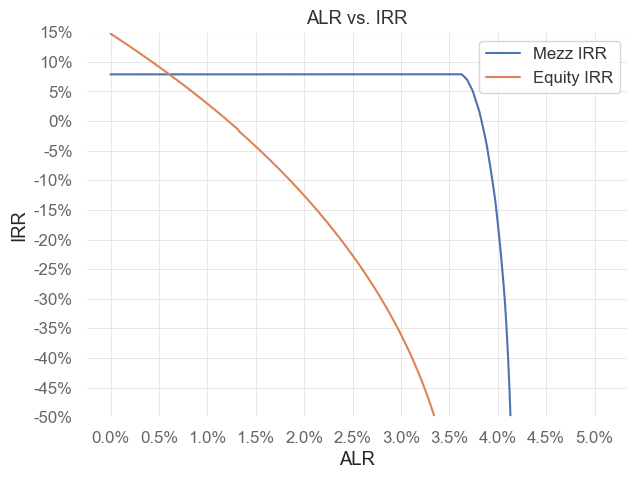

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5)) 
plt.plot(df['ALR'], df['Mezz IRR'], label='Mezz IRR')  
plt.plot(df['ALR'], df['Equity IRR'], label='Equity IRR')  
  
# set chart title and axis labels  
plt.title('ALR vs. IRR')  
plt.xlabel('ALR')  
plt.ylabel('IRR')  
  
plt.xticks(df['ALR'])  
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))  
ax.xaxis.set_major_locator(mtick.MultipleLocator(base=0.005))  

def format_y_axis(x, pos):  
    return '{:.0f}%'.format(x * 100)  
max_value = df[['Mezz IRR', 'Equity IRR']].values.max()  
min_value = df[['Mezz IRR', 'Equity IRR']].values.min()  
# ax.set_ylim(min_value, max_value)  
ax.set_ylim(-0.5, 0.15)  
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_y_axis))  
ax.yaxis.set_major_locator(mtick.MultipleLocator(base=0.05))  
  
# add legend  
plt.legend()  
  
# show chart  
plt.show()  

SIMPLE CDR TEST

Portfolio Stats

In [ ]:
portfolio_init = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Junon 4 - Updated Reference Portfolio - Model Test Case.xlsb', sheet_name='First Portfolio')
portfolio_new = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Junon 4 - Updated Reference Portfolio - Model Test Case.xlsb', sheet_name='New Portfolio 5Bn').iloc[:, :-3]    
rating_map_sg = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Junon 4 - Updated Reference Portfolio - Model Test Case.xlsb', sheet_name='Rating Table Mapping', header=2).iloc[:, 1:8].dropna()    
amortization_sg = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Junon 4 - Updated Reference Portfolio - Model Test Case.xlsb', sheet_name='Amortisation Profiles', header=6).iloc[:, 5:7].dropna()    
portfolio_new['Moodys Rating'] = portfolio_new['Internal Rating'].map(rating_map_sg.set_index('SG Obligor Rating')["Moody's"])  
portfolio_new['WARF'] = portfolio_new['Moodys Rating'].apply(lambda z: rating_to_warf(z, skip_nr=True))
portfolio_new['Origination Date'] = pd.to_datetime(portfolio_new['Origination Date'], origin='1899-12-30', unit='D')  
portfolio_new['Origination Date'] = portfolio_new['Origination Date'].dt.strftime('%Y-%m-%d')  
portfolio_new['Maturity Date'] = pd.to_datetime(portfolio_new['Maturity Date'], origin='1899-12-30', unit='D')
portfolio_new['Maturity Date'] = portfolio_new['Maturity Date'].dt.strftime('%Y-%m-%d')
portfolio_new['Original Tenor'] = (pd.to_datetime(portfolio_new['Maturity Date']) - pd.to_datetime(portfolio_new['Origination Date'])).dt.days / 365
portfolio_new['Remaining Tenor'] = (pd.to_datetime(portfolio_new['Maturity Date']) - pd.Timestamp.today()).dt.days / 365
portfolio_new = portfolio_new.loc[:, ['Reference Obligation ID', 'Industry', 'Country of risk', 'Origination Date', 'Maturity Date', 'Facility Type', 'Facility Amortization Type', "Moodys Rating", 'WARF', 'Currency', 'FX Rate', 'Securitised Amount', 'Original Tenor', 'Remaining Tenor', 'Flag Junon 3', 'Flag New Obligor Group vs. First ptf', 'Flag New Facility vs. First ptf', 'Amount changed vs. First ptf']]  
portfolio_new['Facility Type'] = portfolio_new['Facility Type'].apply(lambda x: 'Revolver' if x in ['364DayRevolver', 'Revolver', 'RevolverToTerm'] else ('Term Loan' if x in ['Term'] else x))  
portfolio_new.head(5)


,Reference Obligation ID,Industry,Country of risk,Origination Date,Maturity Date,Facility Type,Facility Amortization Type,Moodys Rating,WARF,Currency,FX Rate,Securitised Amount,Original Tenor,Remaining Tenor,Flag Junon 3,Flag New Obligor Group vs. First ptf,Flag New Facility vs. First ptf,Amount changed vs. First ptf
0,FCN0000011285,Media And Telecommunication,Germany,2005-08-19,2025-08-19,Revolver,bullet,Baa1,260,EUR,1.000,"50,000,000.000",20.014,1.321,N,0,1,"50,000,000.000"
1,FCN0000030637,Intermediary Goods And Materials,Netherlands,2011-09-29,2027-03-12,Revolver,bullet,Baa1,260,EUR,1.000,"32,857,142.857",15.460,2.882,N,0,0,0.000
2,FCN0000032189,Utilities,Italy,2012-07-24,2027-12-01,Revolver,bullet,Baa1,260,EUR,1.000,"23,386,634.194",15.364,3.605,Y,0,0,"14,208,664.301"
3,FCN0000030730,Capital Goods,France,2011-10-20,2026-12-18,Revolver,bullet,A3,180,EUR,1.000,"541,253.806",15.173,2.652,Y,0,0,226.552
4,FCN0000029536,Media And Telecommunication,Spain,2011-05-09,2026-06-19,Revolver,bullet,Baa2,360,EUR,1.000,"50,000,000.000",15.123,2.153,Y,0,1,"50,000,000.000"


In [ ]:
row = 'Industry'
column = 'Facility Type'
value = 'Securitised Amount'

def portfolio_summary(row, column, value):
    portfolio_sum = portfolio_new[value].sum()  
    avg_size = portfolio_new.groupby([column]).apply(lambda group: group[value].mean())
    portfolio_warf = (portfolio_new['WARF'] * portfolio_new[value]).sum() / portfolio_new[value].sum()
    portfolio_maturity = (portfolio_new['Original Tenor'] * portfolio_new[value]).sum() / portfolio_new[value].sum()
    portfolio_tenor = (portfolio_new['Remaining Tenor'] * portfolio_new[value]).sum() / portfolio_new[value].sum()

    portfolio_share = portfolio_new.groupby([row, column]).apply(lambda group: group[value].sum() / portfolio_sum * 100).unstack()  
    portfolio_share.loc['Total',:] = portfolio_share.sum(numeric_only=True)  
    portfolio_share = portfolio_share.applymap('{:.2f}%'.format) 
    # portfolio_share  
    avg_warf = portfolio_new.groupby([row, column]).apply(lambda group: (group['WARF'] * group[value]).sum() / group[value].sum()).unstack()
    avg_warf.loc['Total',:] = portfolio_new.groupby([column]).apply(lambda group: (group['WARF'] * group[value]).sum() / group[value].sum())
    avg_warf = avg_warf.applymap(lambda x: warf_to_rating(x) if isinstance(x, (int, float)) and x > 0 else x)  
    # avg_warf
    avg_maturity = portfolio_new.groupby([row, column]).apply(lambda group: (group['Original Tenor'] * group[value]).sum() / group[value].sum()).unstack()
    avg_maturity.loc['Total',:] = portfolio_new.groupby([column]).apply(lambda group: (group['Original Tenor'] * group[value]).sum() / group[value].sum())
    avg_tenor = portfolio_new.groupby([row, column]).apply(lambda group: (group['Remaining Tenor'] * group[value]).sum() / group[value].sum()).unstack()
    avg_tenor.loc['Total',:] = portfolio_new.groupby([column]).apply(lambda group: (group['Remaining Tenor'] * group[value]).sum() / group[value].sum())
    tenors = pd.merge(avg_maturity, avg_tenor, left_index=True, right_index=True, suffixes=(' Maturity', ' WAL')).round(1)
    # tenors
    merge_table = pd.merge(portfolio_share, avg_warf, left_index=True, right_index=True, suffixes=(' % of Portfolio', ' WARF'))
    merge_table = pd.merge(merge_table, tenors, left_index=True, right_index=True)
    # merge_table

    print("Portfolio Summary:")
    print("Total Size: EUR", round(portfolio_sum/1000000000,1), "Bn")
    print("Average Size by", round(avg_size/1000000,1))
    print("Portfolio WARF:", int(portfolio_warf), ",", warf_to_rating(portfolio_warf))
    print("Portfolio Maturity:", round(portfolio_maturity,1), "years")
    print("Portfolio Remaining WAL:", round(portfolio_tenor,1), "years")
    print(merge_table.to_string())

portfolio_summary(row, column, value)

Portfolio Summary:
Total Size: EUR 5.0 Bn
Average Size by Facility Type
Revolver     18.6
Term Loan    12.5
dtype: float64
Portfolio WARF: 432 , BAA2
Portfolio Maturity: 5.9 years
Portfolio Remaining WAL: 2.5 years
Facility Type                      Revolver % of Portfolio Term Loan % of Portfolio Revolver WARF Term Loan WARF  Revolver Maturity  Term Loan Maturity  Revolver WAL  Term Loan WAL
Industry                                                                                                                                                                            
Agriculture And Food Manufacturing                   5.14%                    0.61%          BAA2           BAA2                5.8                 6.2           2.5            1.3
Automobile                                           5.41%                    0.59%          BAA3            BA1                5.1                 3.0           2.8            1.5
Capital Goods                                        5.01%   

Moody's 2023 Annual Default Study, Published in March 2024

In [ ]:
# unique_industry = pd.DataFrame(portfolio_new['Industry'].unique(), columns=['Junon Industry'])  
industry_mapping = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Junon 4 - Updated Reference Portfolio - Model Test Case.xlsb', sheet_name='Industry Mapping').iloc[:, 0:8].dropna() 
industry_mapping['Annualized Default Rate'] = (1 + industry_mapping['10Y Cumulative Default Rate'] ) ** (1 / 10) - 1  
industry_unique = industry_mapping.groupby('Mapped Junon Sectors').agg('mean').reset_index()
industry_unique

,Mapped Junon Sectors,1st Lien Loan Recovery,1st Lien Bond Recovery,Sr. Unsec. Bond Recovery,Sr. Sub. Bond Recovery,Sub. Bond Recovery,10Y Cumulative Default Rate,Annualized Default Rate
0,Agriculture And Food Manufacturing,0.754810,0.554600,0.419550,0.274810,0.339660,0.075876,0.007340
1,Automobile,0.685420,0.579380,0.475590,0.239280,0.494580,0.178904,0.016595
2,Capital Goods,0.654575,0.727255,0.393385,0.287560,0.401970,0.085174,0.008166
3,Construction,0.581240,0.626410,0.359540,0.252940,0.284910,0.251443,0.022683
4,Consumer Products,0.614945,0.471765,0.333240,0.310065,0.340235,0.260807,0.023446
5,Financial Activities,0.774560,0.739380,0.404135,0.413765,0.360570,0.053623,0.005218
6,Intermediary Goods And Materials,0.682922,0.519615,0.382380,0.281720,0.382070,0.150928,0.014088
7,Media And Telecommunication,0.621720,0.413562,0.328860,0.312553,0.386390,0.212567,0.019130
8,Multisector Holding Companies,0.613190,0.130000,0.297330,0.270830,0.136250,0.158052,0.014782
9,Oil And Gas,0.752415,0.691725,0.478540,0.584450,0.306795,0.205064,0.018773


In [ ]:
# Exhibit 41. Average cumulative issuer-weighted global default rates by alphanumeric rating, 1983-2023
default_cumulative = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Data_Report-Default-Trends-Global-28Mar2024.xlsx', sheet_name='Default', header=2).iloc[0:21, 0:21]
# Exhibit 37. Annual issuer-weighted corporate default rates by alphanumeric rating, 1983-2023
# default_annual = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Data_Report-Default-Trends-Global-28Mar2024.xlsx', sheet_name='Default', header=30).iloc[0:46, 0:24]
# Exhibit 7. Average corporate debt recovery rates measured by trading prices*, 1987-2023
# recovery_trading_price = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Data_Report-Default-Trends-Global-28Mar2024.xlsx', sheet_name='Recovery', header=3).iloc[0:9, 0:3]
# Exhibit 9. Average debt ultimate recovery rates, 1987-2023 (* Revolver Includes cash revolvers and borrowing base facilities. ** Term Loan Includes all types of term loans: first-, second-lien and unsecured.)
recovery_ultimate = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Data_Report-Default-Trends-Global-28Mar2024.xlsx', sheet_name='Recovery', header=18).iloc[0:5, 0:3]
# Exhibit 29. Annual credit loss rates by letter rating, 1983-2023 (* Based on issuer-weighted annual default rates and senior unsecured bond recoveries measured on an issuer-weighted basis.)
# loss = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Data_Report-Default-Trends-Global-28Mar2024.xlsx', sheet_name='Loss', header=2).iloc[:, 0:11]
# Exhibit 35. Average one-year alphanumeric rating migration rates, 1983-2023
migration = pd.read_excel('C:\\Users\\yunyizhang\\Canada Pension Plan Investment Board\\CI - Significant Risk Transfer (SRT) - Europe\\SocGen\\2. Junon 4\\6. Tap and Mezz Opportunity\\2. Model\\Data_Report-Default-Trends-Global-28Mar2024.xlsx', sheet_name='Migration', header=2)

default_cumulative
recovery_ultimate
# migration

,Debt type,Emergence year,Default year
0,Revolvers*,0.86515,0.86515
1,Term loans**,0.710699,0.710699
2,Senior secured bonds,0.616977,0.616977
3,Senior unsecured bonds,0.468633,0.468633
4,Subordinated bonds,0.278521,0.278521


In [ ]:
portfolio_new['Recovery Assumption'] = portfolio_new['Facility Type'].apply(lambda x: 'Revolver' if x in ['Revolver'] else ('Term Loan' if x in ['Term Loan'] else x))  
portfolio_new.head(5)

,Reference Obligation ID,Industry,Country of risk,Origination Date,Maturity Date,Facility Type,Facility Amortization Type,Moodys Rating,WARF,Currency,FX Rate,Securitised Amount,Original Tenor,Remaining Tenor,Flag Junon 3,Flag New Obligor Group vs. First ptf,Flag New Facility vs. First ptf,Amount changed vs. First ptf,Recovery Assumption
0,FCN0000011285,Media And Telecommunication,Germany,2005-08-19,2025-08-19,Revolver,bullet,Baa1,260,EUR,1.0,5.000000e+07,20.013699,1.320548,N,0,1,5.000000e+07,Revolver
1,FCN0000030637,Intermediary Goods And Materials,Netherlands,2011-09-29,2027-03-12,Revolver,bullet,Baa1,260,EUR,1.0,3.285714e+07,15.460274,2.882192,N,0,0,0.000000e+00,Revolver
2,FCN0000032189,Utilities,Italy,2012-07-24,2027-12-01,Revolver,bullet,Baa1,260,EUR,1.0,2.338663e+07,15.364384,3.605479,Y,0,0,1.420866e+07,Revolver
3,FCN0000030730,Capital Goods,France,2011-10-20,2026-12-18,Revolver,bullet,A3,180,EUR,1.0,5.412538e+05,15.172603,2.652055,Y,0,0,2.265519e+02,Revolver
4,FCN0000029536,Media And Telecommunication,Spain,2011-05-09,2026-06-19,Revolver,bullet,Baa2,360,EUR,1.0,5.000000e+07,15.123288,2.153425,Y,0,1,5.000000e+07,Revolver


Historical Loan Default Rates (Using Percentages by Volumes Here, not Issuer Count)

In [ ]:
lcd = pd.read_excel('C:\\Users\\yunyizhang\\Python script\\2. Upload data\\LLI Default Rates.xlsx', sheet_name='Default Stats', header=1)
lcd = lcd.iloc[:, :2].set_index('Date').resample('A').mean().reset_index()  
lcd = lcd.rename(columns={'Date': 'Year', 'LTM $ of Defaults / Total Outstanding': 'Loan Default Rates'}).set_index('Year')
lcd = lcd.loc['2008':'2013']
# print(lcd)  

mean = lcd['Loan Default Rates'].mean()  
st_dev = lcd['Loan Default Rates'].std()  
print("Entire History: ", "Mean: ", "{:.2%}".format(mean), "St Dev: ", "{:.2%}".format(st_dev))

threshold = 0.04
print("Annual Default Rate Threshold Above", threshold, "Mean: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] > threshold, 'Loan Default Rates'].mean()), "St Dev: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] > threshold, 'Loan Default Rates'].std()))
print("Annual Default Rate Threshold Below", threshold, ": Mean: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] <= threshold, 'Loan Default Rates'].mean()), "St Dev: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] <= threshold, 'Loan Default Rates'].std()))


Entire History:  Mean:  3.07% St Dev:  3.08%
Annual Default Rate Threshold Above 0.04 Mean:  6.61% St Dev:  2.93%
Annual Default Rate Threshold Below 0.04 : Mean:  1.30% St Dev:  0.61%


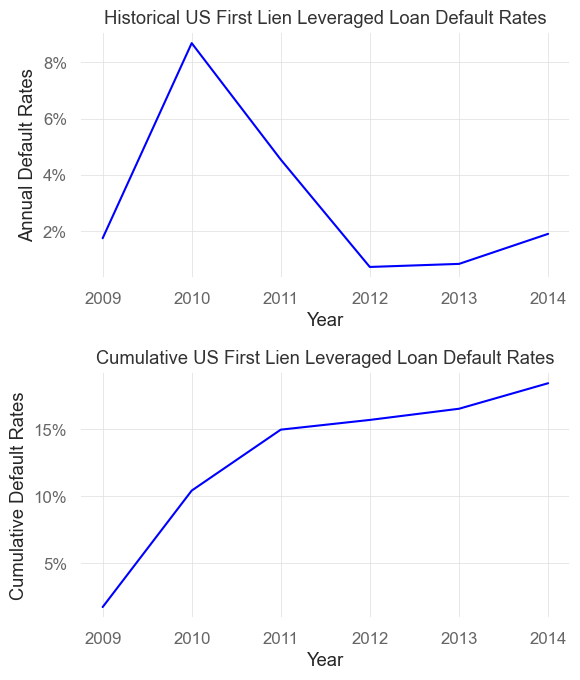

In [ ]:
# lcd.loc[lcd.index.year < 2010, 'Loan Default Rates'] *= 2
# lcd.loc[lcd.index.year < 2015, 'Loan Default Rates'] *= 1.5  

fig, axs = plt.subplots(2, 1, figsize=(6, 7))  # 1 row, 2 columns
axs[0].plot(lcd.index, lcd['Loan Default Rates'], color='blue')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Annual Default Rates')
axs[0].set_title('Historical US First Lien Leveraged Loan Default Rates')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,0))  
lcd['Cumulative Loan Default Rates'] = lcd['Loan Default Rates'].cumsum()  
axs[1].plot(lcd.index, lcd['Cumulative Loan Default Rates'], color='blue')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Cumulative Default Rates')
axs[1].set_title('Cumulative US First Lien Leveraged Loan Default Rates')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,0))
plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

Monte Carlo Simulation to Create Default Assumptions

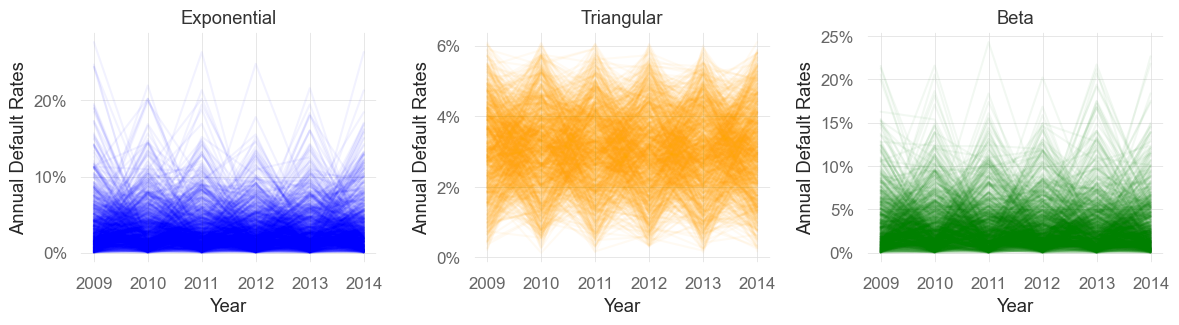

In [ ]:
mean = lcd['Loan Default Rates'].mean()  
st_dev = lcd['Loan Default Rates'].std()  
maturity = len(lcd)
np.random.seed(123)  
num_scenarios = 1000
degrees_of_freedom = 10    
default_rates_beta = np.random.beta(mean*(mean*(1-mean)/st_dev**2-1), (1-mean)*(mean*(1-mean)/st_dev**2-1), size=(num_scenarios, maturity))  
default_rates_binomial = np.random.binomial(n=1, p=mean, size=(num_scenarios, maturity))  
default_rates_exponential = np.random.exponential(scale=mean, size=(num_scenarios, maturity))  
default_rates_gamma = np.random.gamma(shape=mean/st_dev**2, scale=st_dev/mean/500, size=(num_scenarios, maturity))  
default_rates_triangular = np.random.triangular(left=mean-st_dev, mode=mean, right=mean+st_dev, size=(num_scenarios, maturity))  
default_rates_lognormal = np.random.lognormal(mean=np.log(mean**2/np.sqrt(st_dev**2+mean**2)), sigma=np.sqrt(np.log(1+st_dev**2/mean**2)), size=(num_scenarios, maturity))  
default_rates_chisquare = np.random.chisquare(df=mean**2/st_dev**2, size=(num_scenarios, maturity)) * st_dev**2/mean  
default_rates_uniform = np.random.uniform(mean, st_dev, size=(num_scenarios, maturity))
default_rates_standardt = np.clip((np.random.standard_t(degrees_of_freedom, size=(num_scenarios, maturity)) * st_dev + mean), 0, 1)

# Plot the default rate scenarios for all distributions  
# distributions = ['Beta', 'Binomial', 'Exponential', 'Gamma', 'Triangular', 'Lognormal', 'ChiSquare', 'Uniform', 'StandardT']  
# colors = ['blue', 'orange', 'green', 'magenta', 'red', 'brown', 'navy', 'gray', 'pink']  
distributions = ['Exponential', 'Triangular', 'Beta']  
colors = ['blue', 'orange', 'green']  

def to_percentage(x, pos):  
    return f"{100 * x:.0f}%"  
def to_percentage_one_decimal(x, pos):  
    return f"{100 * x:.1f}%"  

plt.figure(figsize=(12, 9))  
for i, dist in enumerate(distributions):  
    plt.subplot(3, 3, i+1)  
    for j in range(num_scenarios):  
        plt.plot(lcd.index[:6], eval('default_rates_' + dist.lower())[j][:6], alpha=0.05, color=colors[i])  
        # plt.plot(range(1, 7), eval('default_rates_' + dist.lower())[j][:6], alpha=0.05, color=colors[i])  
    plt.xlabel('Year')  
    plt.ylabel('Annual Default Rates')  
    # plt.title('10,000 Scenarios of Default Rates (' + dist + ' Distribution)')  
    plt.title(dist)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage)) 
plt.tight_layout()  
plt.show()  

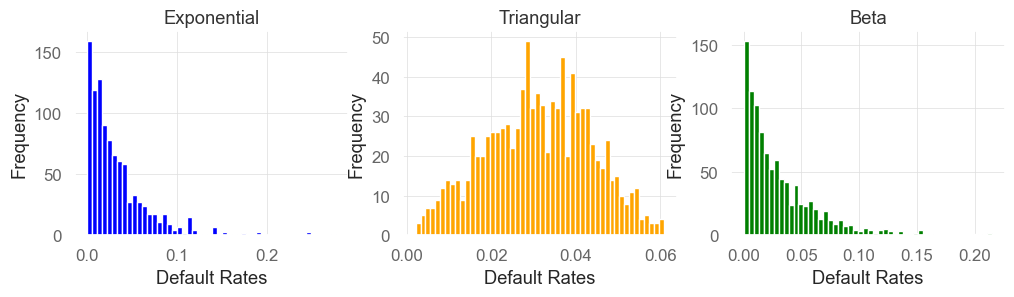

In [ ]:
# plot histogram of the default rates for each distribution
plt.figure(figsize=(12, 9))
for i, dist in enumerate(distributions):
    plt.subplot(3, 3, i+1)
    plt.hist(eval('default_rates_' + dist.lower())[:, 0], bins=50, color=colors[i])
    plt.xlabel('Default Rates')
    plt.ylabel('Frequency')
    plt.title(dist)

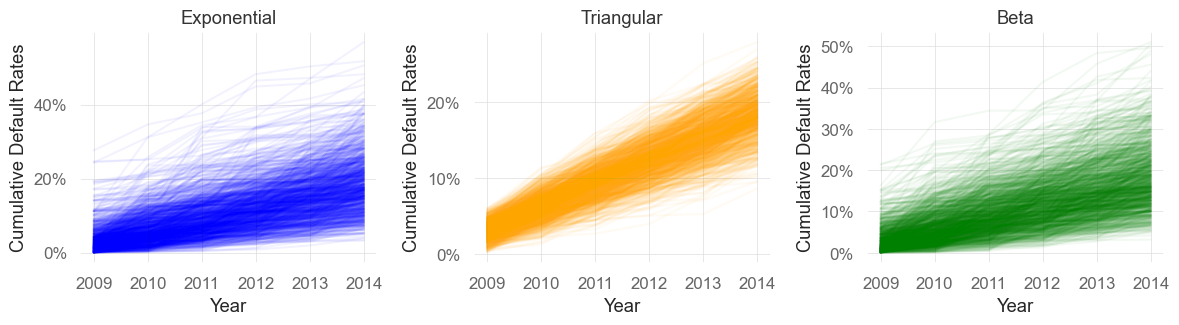

In [ ]:
#plot cumulative default curve using all the above distributions 
# cumulative density function (CDF) of the default rates for each distribution
plt.figure(figsize=(12, 9))
for i, dist in enumerate(distributions):
    plt.subplot(3, 3, i+1)
    for j in range(num_scenarios):
        plt.plot(lcd.index[:6], eval('default_rates_' + dist.lower())[j][:6].cumsum(), alpha=0.05, color=colors[i])
    plt.xlabel('Year')
    plt.ylabel('Cumulative Default Rates')
    plt.title(dist)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage)) 
plt.tight_layout()
plt.show()

In [ ]:
num_instances = 1_000  # Number of time series to simulate  
num_years = 6  # Number of years to simulate  
scenarios = distributions
all_scenarios_df = pd.DataFrame()  
multiplier = 1/3

for scenario in scenarios:  
    all_time_series = pd.DataFrame()  
      
    for n in range(num_instances):  
        if scenario == 'Triangular':  
            default_rates_scenario = default_rates_triangular[np.random.choice(num_scenarios), :]  
        elif scenario == 'Uniform':  
            default_rates_scenario = default_rates_uniform[np.random.choice(num_scenarios), :]  
        elif scenario == 'Lognormal':  
            default_rates_scenario = default_rates_lognormal[np.random.choice(num_scenarios), :]  
        elif scenario == 'Exponential':  
            default_rates_scenario = default_rates_exponential[np.random.choice(num_scenarios), :]  
        # elif scenario == 'Normal':
        #     default_rates_scenario = default_rates_normal[np.random.choice(num_scenarios), :]
        elif scenario == 'StandardT':
            default_rates_scenario = default_rates_standardt[np.random.choice(num_scenarios), :]
        elif scenario == 'Gamma':
            default_rates_scenario = default_rates_gamma[np.random.choice(num_scenarios), :]
        # elif scenario == 'Poisson':
        #     default_rates_scenario = default_rates_poisson[np.random.choice(num_scenarios), :]
        elif scenario == 'Binomial':
            default_rates_scenario = default_rates_binomial[np.random.choice(num_scenarios), :]
        elif scenario == 'ChiSquare':
            default_rates_scenario = default_rates_chisquare[np.random.choice(num_scenarios), :]
        elif scenario == 'Beta':
            default_rates_scenario = default_rates_beta[np.random.choice(num_scenarios), :]
        # elif scenario == 'Geometric':
        #     default_rates_scenario = default_rates_geometric[np.random.choice(num_scenarios), :]
        # elif scenario == 'Weibull':
        #     default_rates_scenario = default_rates_weibull[np.random.choice(num_scenarios), :]
        # elif scenario == 'Gumbel':
        #     default_rates_scenario = default_rates_gumbel[np.random.choice(num_scenarios), :]
        # elif scenario == 'Logistic':
        #     default_rates_scenario = default_rates_logistic[np.random.choice(num_scenarios), :]
        # elif scenario == 'Laplace':
        #     default_rates_scenario = default_rates_laplace[np.random.choice(num_scenarios), :]
        else:
            raise ValueError('Invalid distribution')
          
        default_rates = []  
        for year in range(num_years):  
            if year == 1:  
                default_rate = np.random.choice(default_rates_scenario*1.6*multiplier)  
            elif year <= 3:  
                default_rate = np.random.choice(default_rates_scenario*1.1*multiplier)  
            elif year <= 5:  
                default_rate = np.random.choice(default_rates_scenario*0.8*multiplier)  
            else:  
                # default_rate = np.random.choice([0.05, 0.1, 0.15], p=[0.6, 0.3, 0.1])  
                default_rate = np.random.choice(default_rates_scenario*0.5*multiplier)
            default_rates.append(default_rate)  
          
        lcd = pd.DataFrame({scenario: default_rates}, index=pd.date_range('2023-01-01', periods=num_years, freq='Y'))    
        all_time_series = pd.concat([all_time_series, lcd.T])  
      
    # Adding the median and IQR for each scenario to a summary DataFrame  
    all_time_series_transposed = all_time_series.T  
    median_rates = all_time_series_transposed.median(axis=1)  
    percentile25 = all_time_series_transposed.quantile(0.25, axis=1)  
    percentile75 = all_time_series_transposed.quantile(0.75, axis=1)  
      
    scenario_summary = pd.DataFrame({  
        f'{scenario}_median': median_rates,  
        f'{scenario}_25th': percentile25,  
        f'{scenario}_75th': percentile75  
    })  
      
    if all_scenarios_df.empty:  
        all_scenarios_df = scenario_summary  
    else:  
        all_scenarios_df = all_scenarios_df.join(scenario_summary)  
  
# Now `all_scenarios_df` contains the median and IQR for each year, for all scenarios.  
# You can plot these using a similar approach as before, adjusting for multiple scenarios in the loop.  

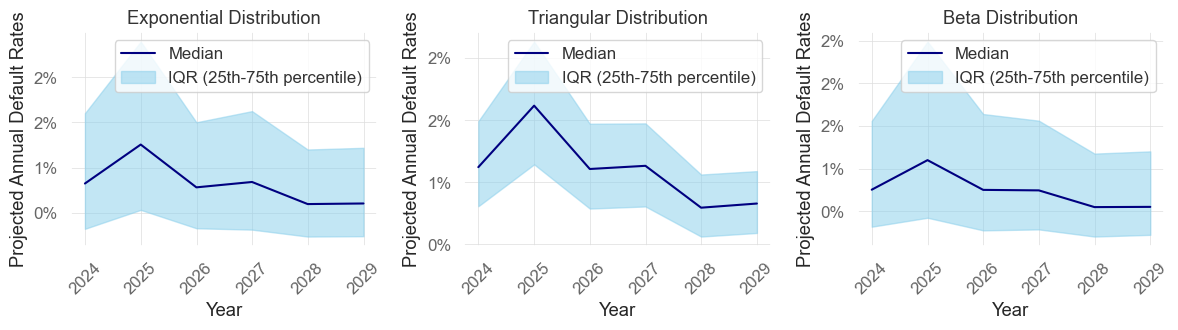

In [ ]:
# Set the figure size and create subplots for each scenario  
rows = int(np.ceil(len(distributions) /3))  
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(12, 3.5))  
axes = axes.flatten()  # Flatten to iterate easily  
scenarios = distributions  
  
for i, scenario in enumerate(scenarios):  
    median_label = f'{scenario}_median'  
    p25_label = f'{scenario}_25th'  
    p75_label = f'{scenario}_75th'  
        
    # Plot median  
    axes[i].plot(all_scenarios_df.index, all_scenarios_df[median_label], label='Median', color='navy')  
        
    # Fill between the 25th and 75th percentile (IQR)  
    axes[i].fill_between(all_scenarios_df.index, all_scenarios_df[p25_label], all_scenarios_df[p75_label], color='skyblue', alpha=0.5, label='IQR (25th-75th percentile)')  
        
    # Customize the plot  
    axes[i].set_title(f'{scenario} Distribution')  
    axes[i].set_xlabel('Year')  
    axes[i].set_ylabel('Projected Annual Default Rates')  
        
    # Adjusting X-axis labels  
    axes[i].xaxis.set_major_locator(mdates.YearLocator())  
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
    axes[i].tick_params(axis='x', rotation=45)  
        
    # Format y-axis as percentage  
    axes[i].yaxis.set_major_formatter(FuncFormatter(to_percentage))  
    axes[i].legend()  
  
plt.tight_layout()  
plt.show()  

Create Collateral Pool Cash Flows

In [ ]:
all_time_series.columns = [f'Year {i+1}' for i in range(6)]
all_time_series.index = range(1, 1001)
# all_time_series

VARIABLE DEFAULT RATE VECTOR EXPERIMENTAL CASE: PROCEED WITH CAUTION!!!

In [ ]:
# all_time_series.to_clipboard()
# default_rates = np.arange(0.005, 0.05, 0.001).tolist()  
# default_rate = [0.03]*36 + [0.01]*36    #   [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 

# remaining_default_rates = np.arange(0.0, 0.01, 0.01).tolist()        #np.arange(0.00, 0.05, 0.005).tolist()  
default_rates = all_time_series

def custom_formula(scenario):  
    # Calculate the custom formula using the default rates for each year  
    default_rate = [scenario['Year 1']] * 12 + [scenario['Year 2']] * 12 + [scenario['Year 3']] * 12 + [scenario['Year 4']] * 12 + [scenario['Year 5']] * 12 + [scenario['Year 6']] * 12 
    return default_rate  


# PUT IN VECTOR LOOP

print('\nModel Test Results: VARIABLE DEFAULT RATE VECTOS EXPERIMENT')

# LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# original_balance = 1000000000
# default_rates = np.arange(0.005, 0.05, 0.001).tolist()  
# tranche_size_equitys = np.arange(0.08, 0.12, 0.0025).tolist()  
df = pd.DataFrame(columns=['Case', 'Mezz IRR', 'Equity IRR'])  

for i in range(len(default_rates)):  
    scenario = default_rates.iloc[i]  
    default_rate = custom_formula(scenario)  

    perf = ("Pool"            #this is for new assets added into the pool
            ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
            ,None
            ,None
        )

    test01 = Generic(
        "TEST01"
        ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
        ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date} #! change deal date
        ,{'assets':[["Mortgage"             #this is snapshot at issuance, confirmed unchanged. this is a fact
            ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
            ,"freq":"Monthly","type":"Even","originDate":start_date}                               # even cashflow type for mortgage is basically like consumers 
            ,{"currentBalance":original_pool_balance
            ,"currentRate":pool_rate
            ,"remainTerm":original_pool_term
            ,"status":"current"}]]
            ,'issuanceStat':{"IssuanceBalance":original_pool_balance}    
        }
        ,(("acc01",{"balance":0}),("acc02",{"balance":0}))  #! change to 0
        ,(("S",{"balance":original_pool_balance * tranche_size_senior
                ,"rate":tranche_rate_senior
                ,"originBalance":original_pool_balance * tranche_size_senior
                ,"originRate":tranche_rate_senior
                ,"startDate":start_date
                ,"rateType":{"Fixed":tranche_rate_senior}
                ,"bondType":{"Sequential":None}})
        ,("M",{"balance":original_pool_balance * tranche_size_mezz
                ,"rate":tranche_rate_mezz
                ,"originBalance":original_pool_balance * tranche_size_mezz
                ,"originRate":tranche_rate_mezz
                ,"startDate":start_date
                ,"rateType":{"Fixed":tranche_rate_mezz}      #CHANGE TO FLOATING
                ,"bondType":{"Sequential":None}
                })
        ,("E",{"balance":original_pool_balance * tranche_size_equity
                ,"rate":tranche_rate_equity
                ,"originBalance":original_pool_balance * tranche_size_equity
                ,"originRate":tranche_rate_equity
                ,"startDate":start_date
                ,"rateType":{"Fixed":tranche_rate_equity}
                ,"bondType":{"Sequential":None}
                }))
        ,list()
        ,{"revolving":[
            ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
            ,['transfer',"acc02","acc01"]
            # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
            ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",{"formula":("-",("originalPoolBalance",),("poolBalance",))}]
            
            ]
        ,"amortizing":[
            ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
            ,['transfer',"acc02","acc01"]
            # ,['payPrinBySeq',"acc01",["S","M","E"]]
            # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
            ,['payPrin',"acc01",["S","M","E"]]
            ,['payIntResidual',"acc01","E"]
        ]
        }
        ,[["CollectedPrincipal","acc01"]
        ,["CollectedRecoveries","acc01"] #! add here
        ,["CollectedPrepayment","acc01"] #! add here
        ,["CollectedInterest","acc02"]]
        ,None
        ,None
        ,None    
        ,{"BeforeDistribution":
        {"dealStatusChange":
            {"condition":["any",[">=",repay_date]
                               ,[("cumPoolDefaultedRate",),">",switch_trigger]] 
                ,"effects":("newStatus","Amortizing")
                ,"status":False
                ,"curable":False}}
            }
        ,("PreClosing","Revolving")
        )

    runDealAssump = [("revolving"     #this is asumption about what happens during the revolving period, we care about what assets we buy, and hows their performance
                        ,["constant"
                        ,["Mortgage"     ##this is what the new assets look like 
                            ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
                            ,"freq":"Monthly","type":"Level","originDate":repay_date}
                            ,{"currentBalance":original_pool_balance
                            ,"currentRate":pool_rate
                            ,"remainTerm":original_pool_term
                            ,"status":"current"}]]
                        ,perf)
                        ,("call",{"poolFactor":cleanup_call})]

    r = localAPI.run(test01
                    ,runAssump = runDealAssump
                    ,poolAssump = ("Pool"
                                ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
                                ,None
                                ,None)
                    ,read=True)

    def srt(initBals, poolPerformance, trancheOfIntest, feeRates, reinvestRate=reinvestment_rate):
        
        poolDates = poolPerformance['pool']['flow'].index.to_list()
        beginDate = poolDates[0]
        lastDate = poolDates[-1]
        start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
        start['CumLossDerived'] = start['Loss'].cumsum()

        seniorBal, mezzBal, equityBal = initBals
        mezzRate,equityRate = feeRates
        
        issuePrice = mezzBal if trancheOfIntest == "M" else equityBal
        
        # indicator only     #this considers the loss resulted writeoffs
        start.loc[:,'equityBal'] = (equityBal - start['CumLossDerived']).clip(lower=0).to_list()
        start.loc[:,'mezzBal'] =  mezzBal - (start['CumLossDerived'] - equityBal).clip(lower=0,upper=mezzBal)
        start.loc[:,'seniorBal'] = seniorBal - (start['CumLossDerived'] - equityBal - mezzBal).clip(lower=0)
        start.loc[:,'mezzLoss'] = np.maximum(start['CumLossDerived'] - equityBal, 0).clip(lower=0).to_list()  
        start.loc[:,'seniorLoss'] = np.maximum(start['CumLossDerived'] - equityBal - mezzBal, 0).clip(lower=0).to_list()  

        if trancheOfIntest == "M" :     #shows which tranche we're investing in
            start.loc[:,'mezzBal - feeStream'] = start['mezzBal'] * mezzRate / 12
        else:
            start.loc[:,'equityBal - feeStream'] = start['equityBal'] * equityRate / 12

        #start.loc[:,'reimburseLoss'] = start['Loss']

        # invest related cashflow
        start.loc[:,'cashAccountChange'] = 0
        ## account init bals
        start.loc[:,'cashAccountBal'] = issuePrice
        ## loss reimbursement
        start.loc[:,'reimburseLoss'] = 0

        if trancheOfIntest == "M" :     #shows which tranche we're investing in
            reimburseAmt = tryDraw([], issuePrice ,start.loc[:,'mezzLoss'].to_list())
        else:
            reimburseAmt = tryDraw([], issuePrice ,start.loc[:,'Loss'].to_list())
        
        start.loc[:,'reimburseLoss'] = reimburseAmt
        start.loc[:,'cashAccountChange'] = start.loc[:,'cashAccountChange'] + -1*start['reimburseLoss']
        ## init deposit with price
        start.loc[beginDate, 'cashAccountChange'] = start.loc[beginDate, 'cashAccountChange'] + issuePrice
        ### calculate account balance with 
        start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
        ### withdraw all cash from account at last day
        start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'cashAccountBal']
        ## reinvestment int
        start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
        ## net cashflow
        start.loc[:,'netCashflow'] = 0 
        # the above takes care of the 2 sources of inflows: guarantee fee income and cash account reinvestment interest
        
        ## init deposit
        start.loc[beginDate,'netCashflow'] = -1 * issuePrice
        ## add premiums to net cashflow
        if trancheOfIntest == "M" :
            start.loc[:,'netCashflow'] += start['mezzBal - feeStream'].fillna(0)
        else:
            start.loc[:,'netCashflow'] += start['equityBal - feeStream'].fillna(0)
        ## add reinvestment int to net cashflow
        start.loc[:,'netCashflow'] += start['cashAccountInt']
        ## draw remain cash from account at last period
        start.loc[lastDate,'netCashflow'] += start.loc[lastDate,'cashAccountBal']    
        return start

    stackPortion = (tranche_size_senior,tranche_size_mezz,tranche_size_equity)
    ganranteeFeeRates = (tranche_rate_mezz,tranche_rate_equity)

    projectCf_M = srt( [ original_pool_balance * x for x in stackPortion ]
                    , r
                    , "M"
                    , ganranteeFeeRates #(0.12,tranche_rate_equity)
                    , reinvestRate=reinvestment_rate)
    projectCf_E = srt( [ original_pool_balance * x for x in stackPortion ]
                , r
                , "E"
                , ganranteeFeeRates #(0.12,tranche_rate_equity)
                , reinvestRate=reinvestment_rate)
    # projectCf
    #projectCf.to_clipboard()
    a = xirr(projectCf_M.index.to_list(),projectCf_M['netCashflow'].to_list())
    b = xirr(projectCf_E.index.to_list(),projectCf_E['netCashflow'].to_list())
    df = df.append({'Case': i, 'Mezz IRR': a, 'Equity IRR': b}, ignore_index=True)
    print('Case: ', i, ' & Mezz IRR: ', a, ' & Equity IRR: ', b)



Output()


Model Test Results: VARIABLE DEFAULT RATE VECTOS EXPERIMENT


Output()

Output()

Output()

Case:  2  & Mezz IRR:  0.07902076538340141  & Equity IRR:  -0.04095040329664228


Output()

Case:  3  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13393532814641687


Output()

Case:  4  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08713219641036216


Output()

Case:  5  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14303268705519823


Output()

Case:  6  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07068785652118502


Output()

Case:  7  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08663673723779841


Output()

Case:  8  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12781277816884234


Output()

Output()

Case:  10  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.126942985491135


Output()

Case:  11  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07217622690347424


Output()

Output()

Case:  13  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14157645790481715


Output()

Case:  14  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12327489284019116


Output()

Case:  15  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14104636669713397


Output()

Case:  16  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12696678773285872


Output()

Case:  17  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.131021414764371


Output()

Case:  18  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.129409208843667


Output()

Output()

Case:  20  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11797188924723623


Output()

Case:  21  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13270651656217863


Output()

Case:  22  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12724660557685652


Output()

Case:  23  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10704678129802413


Output()

Case:  24  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13291407237766417


Output()

Case:  25  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11377362105830598


Output()

Case:  26  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12480113905211915


Output()

Case:  27  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12498069530943126


Output()

Case:  28  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10944802022930615


Output()

Case:  29  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1374967078398868


Output()

Case:  30  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1001359421104013


Output()

Case:  31  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07085163437524361


Output()

Case:  32  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10549180669484587


Output()

Case:  33  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13505517942445117


Output()

Case:  34  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13493187581550994


Output()

Case:  35  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.107224662588184


Output()

Case:  36  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10304256944006197


Output()

Case:  37  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14151281716804553


Output()

Case:  38  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1381557931632728


Output()

Case:  39  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.026232313147466768


Output()

Case:  40  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.138058545216474


Output()

Case:  41  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11311659972976304


Output()

Case:  42  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09701007187527794


Output()

Case:  43  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14023883244262522


Output()

Output()

Case:  45  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08741103722563819


Output()

Case:  46  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1197667892211559


Output()

Case:  47  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13622066804996394


Output()

Case:  48  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1354105056960575


Output()

Case:  49  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07314809484051471


Output()

Case:  50  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1433114843210825


Output()

Case:  51  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10526139397983658


Output()

Output()

Case:  53  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11362589858979817


Output()

Case:  54  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13208405476081891


Output()

Output()

Output()

Case:  57  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0328261666827001


Output()

Case:  58  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11406118386304612


Output()

Case:  59  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10577106052964157


Output()

Case:  60  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07430796870945269


Output()

Case:  61  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12229070574902891


Output()

Case:  62  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11140347747349814


Output()

Case:  63  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12104894795495269


Output()

Case:  64  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1282891934871831


Output()

Output()

Case:  66  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13274492720518274


Output()

Case:  67  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12569593272457363


Output()

Case:  68  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11985614664752112


Output()

Case:  69  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10817683176365488


Output()

Case:  70  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11921649276366485


Output()

Case:  71  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11648635891319821


Output()

Case:  72  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08438073466644914


Output()

Case:  73  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0929918435849663


Output()

Case:  74  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13890818633046095


Output()

Case:  75  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11280273670054652


Output()

Case:  76  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09760351508320406


Output()

Case:  77  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12039852350242383


Output()

Output()

Case:  79  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09722507422742557


Output()

Output()

Case:  81  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08992420758970816


Output()

Case:  82  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09171530322676617


Output()

Case:  83  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1362148443952031


Output()

Case:  84  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12116510998823733


Output()

Case:  85  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12008286396029462


Output()

Case:  86  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14614225978659034


Output()

Case:  87  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1193506299457034


Output()

Output()

Output()

Output()

Case:  91  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10786065416037233


Output()

Case:  92  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11515448332833156


Output()

Case:  93  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1221066693240364


Output()

Case:  94  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12197502862995804


Output()

Output()

Case:  96  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1331213638046906


Output()

Case:  97  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14448694210029264


Output()

Case:  98  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09066592043856636


Output()

Output()

Case:  100  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14164744129550358


Output()

Case:  101  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1075207609938424


Output()

Case:  102  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09118287408061268


Output()

Case:  103  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12457474262736457


Output()

Output()

Case:  105  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13348287883743595


Output()

Case:  106  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10219146352644351


Output()

Case:  107  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1362629593426898


Output()

Case:  108  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1169909959897572


Output()

Case:  109  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08285710940225859


Output()

Output()

Output()

Case:  112  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13475572811489053


Output()

Case:  113  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1355696282610782


Output()

Case:  114  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12543728265313106


Output()

Case:  115  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.06526425338302282


Output()

Case:  116  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.032130238804631416


Output()

Case:  117  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.010582895972806096


Output()

Case:  118  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10179057883451521


Output()

Case:  119  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1194364069472676


Output()

Case:  120  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0724849814572001


Output()

Case:  121  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11758342828940835


Output()

Case:  122  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.077337672232734


Output()

Case:  123  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11449655098249578


Output()

Case:  124  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13373447153467927


Output()

Case:  125  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07062847148361476


Output()

Case:  126  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12670966212290502


Output()

Case:  127  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12848695088291506


Output()

Case:  128  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13490003320709126


Output()

Case:  129  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07317773268129611


Output()

Output()

Case:  131  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14111137348174538


Output()

Case:  132  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.02434535235978671


Output()

Case:  133  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12748531142927857


Output()

Case:  134  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0942541567292768


Output()

Case:  135  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10976771272684649


Output()

Case:  136  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14316455913897452


Output()

Case:  137  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06857103202509714


Output()

Case:  138  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.103733043127657


Output()

Case:  139  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.130054277218797


Output()

Case:  140  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10898057810490933


Output()

Case:  141  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1228792262192504


Output()

Case:  142  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11097679302822444


Output()

Case:  143  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13340917709714814


Output()

Case:  144  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10311492503082904


Output()

Case:  145  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14257202226523816


Output()

Case:  146  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13787292795186173


Output()

Output()

Case:  148  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09892896103235942


Output()

Case:  149  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09741986932808139


Output()

Case:  150  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13080517521866902


Output()

Case:  151  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08369677123609412


Output()

Case:  152  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07900157359126662


Output()

Case:  153  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14177631313809008


Output()

Case:  154  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13925326590465176


Output()

Output()

Case:  156  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13429389008647744


Output()

Case:  157  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11044645499660173


Output()

Case:  158  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10779592267054096


Output()

Case:  159  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1174717608210439


Output()

Case:  160  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11058722669502369


Output()

Case:  161  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11119572771964037


Output()

Case:  162  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13767187535571862


Output()

Case:  163  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07328921162368678


Output()

Case:  164  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10321164803591645


Output()

Case:  165  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12846823417367584


Output()

Case:  166  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12629106526846762


Output()

Case:  167  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12805470756517837


Output()

Case:  168  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12166149599294497


Output()

Case:  169  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14664091919562955


Output()

Case:  170  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09945581604030082


Output()

Case:  171  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09390920537114915


Output()

Case:  172  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11296735639697345


Output()

Case:  173  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10203650445237715


Output()

Case:  174  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09755201097141368


Output()

Case:  175  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11096453179759459


Output()

Case:  176  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10902764303070199


Output()

Case:  177  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11324125919308443


Output()

Case:  178  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0871979407942777


Output()

Case:  179  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11434354612784445


Output()

Output()

Case:  181  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12101465535671962


Output()

Output()

Case:  183  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10991407781773876


Output()

Case:  184  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1415151416821415


Output()

Case:  185  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.04352270542209818


Output()

Case:  186  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09268008508130297


Output()

Case:  187  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1274537513767691


Output()

Case:  188  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09898989641145693


Output()

Case:  189  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1329578562443079


Output()

Case:  190  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11756410652790689


Output()

Case:  191  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11298873553596205


Output()

Output()

Case:  193  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13725014493319546


Output()

Case:  194  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13922724810327824


Output()

Case:  195  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09895780977339312


Output()

Case:  196  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13313618392481164


Output()

Case:  197  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10827777675661833


Output()

Case:  198  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1227519155491939


Output()

Case:  199  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13675401564640227


Output()

Case:  200  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12420176843357163


Output()

Case:  201  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09257761384385992


Output()

Case:  202  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1381480110765815


Output()

Output()

Case:  204  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10482431173928732


Output()

Case:  205  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0516509656918723


Output()

Case:  206  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14700905315354196


Output()

Case:  207  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10435314131056876


Output()

Case:  208  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11205165139801124


Output()

Output()

Case:  210  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14202701528160147


Output()

Case:  211  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13806550454795327


Output()

Case:  212  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1121530213550349


Output()

Case:  213  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12342909278156289


Output()

Case:  214  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1349869145421864


Output()

Case:  215  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08554129294404224


Output()

Output()

Output()

Case:  218  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14595283576559775


Output()

Case:  219  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1287351655665011


Output()

Case:  220  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10911803406326384


Output()

Output()

Case:  222  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10349490377933786


Output()

Case:  223  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12460196294382861


Output()

Case:  224  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09126387564733697


Output()

Case:  225  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13209932195381796


Output()

Case:  226  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11272252722885874


Output()

Case:  227  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10345718827406022


Output()

Case:  228  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11553625946115229


Output()

Case:  229  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13541204983348534


Output()

Output()

Case:  231  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10769310085292717


Output()

Case:  232  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09793491174263175


Output()

Case:  233  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09962565972856677


Output()

Case:  234  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.03168682997157319


Output()

Case:  235  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14082601904638678


Output()

Case:  236  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09630345899347548


Output()

Case:  237  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12362821464170715


Output()

Output()

Case:  239  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11801166835262916


Output()

Case:  240  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14250977700891168


Output()

Output()

Output()

Case:  243  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09984827438939396


Output()

Case:  244  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12625358289825045


Output()

Case:  245  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1365977890455997


Output()

Case:  246  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1298949301777085


Output()

Case:  247  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12923239511860266


Output()

Case:  248  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08547832408076576


Output()

Case:  249  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10509514073087743


Output()

Case:  250  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13116694894702002


Output()

Output()

Case:  252  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.137811012611677


Output()

Case:  253  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08476738662027634


Output()

Output()

Case:  255  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11595448095322794


Output()

Output()

Case:  257  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12762022406079077


Output()

Case:  258  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07590927290851218


Output()

Case:  259  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11461387617689851


Output()

Case:  260  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10376247184888099


Output()

Case:  261  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09603763567211476


Output()

Case:  262  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10781589901509854


Output()

Case:  263  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14063832370577037


Output()

Case:  264  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1380973611597353


Output()

Output()

Case:  266  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.05695247278661733


Output()

Case:  267  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14476955419938398


Output()

Output()

Case:  269  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1213550791737352


Output()

Case:  270  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06908419720806193


Output()

Case:  271  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12595834557849533


Output()

Case:  272  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10270499944782142


Output()

Case:  273  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08000513661652876


Output()

Case:  274  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11540459387222045


Output()

Case:  275  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08249014873371409


Output()

Case:  276  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12557925925262392


Output()

Output()

Case:  278  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11573686857571885


Output()

Case:  279  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08791563166737047


Output()

Case:  280  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10551933134409809


Output()

Case:  281  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13361211235225529


Output()

Output()

Case:  283  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.118503823405032


Output()

Output()

Case:  285  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.0046415977433334095


Output()

Case:  286  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10166292341114021


Output()

Case:  287  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1257942011609386


Output()

Case:  288  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.05338489684480404


Output()

Output()

Case:  290  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11881249871256362


Output()

Case:  291  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.013598023790526626


Output()

Case:  292  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13091947627475525


Output()

Case:  293  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1310195111841086


Output()

Case:  294  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13824038036376898


Output()

Case:  295  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1330460946597456


Output()

Case:  296  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10057651823517275


Output()

Case:  297  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11985836795533801


Output()

Case:  298  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12458780314422725


Output()

Output()

Output()

Case:  301  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1349774408741215


Output()

Case:  302  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14144095144581656


Output()

Case:  303  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.06037516661284063


Output()

Case:  304  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11264332510413823


Output()

Case:  305  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11155124079417174


Output()

Case:  306  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13030567060626777


Output()

Output()

Case:  308  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09947832535186303


Output()

Case:  309  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10802223669449774


Output()

Case:  310  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12545001524731408


Output()

Case:  311  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12006392321326335


Output()

Case:  312  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11477707791700167


Output()

Case:  313  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06711348820059344


Output()

Output()

Case:  315  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12127443827913131


Output()

Output()

Case:  317  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11813177507086033


Output()

Output()

Case:  319  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.07416465275023405


Output()

Case:  320  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12554423399995163


Output()

Case:  321  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12795609585079032


Output()

Case:  322  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10497450337678729


Output()

Case:  323  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.03475458539343218


Output()

Case:  324  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12173917550125705


Output()

Case:  325  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12836985269558268


Output()

Case:  326  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1346738721366352


Output()

Case:  327  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11024057422690584


Output()

Output()

Case:  329  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11244134759010323


Output()

Case:  330  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14080750489670088


Output()

Output()

Case:  332  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11239764199123464


Output()

Output()

Case:  334  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.038706935873707056


Output()

Case:  335  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11824450631024155


Output()

Case:  336  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13590647924025473


Output()

Case:  337  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11105595284137142


Output()

Output()

Output()

Output()

Output()

Case:  342  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12997144547261474


Output()

Output()

Case:  344  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08569871226606535


Output()

Output()

Case:  346  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12086709221804152


Output()

Case:  347  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13470945872403417


Output()

Case:  348  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11961058117748025


Output()

Case:  349  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13323196454165007


Output()

Output()

Output()

Output()

Output()

Case:  354  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13934465626981205


Output()

Case:  355  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12149412636335345


Output()

Output()

Output()

Output()

Case:  359  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12954971594170944


Output()

Case:  360  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11071942236774944


Output()

Case:  361  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10127799667922234


Output()

Case:  362  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0944763147167461


Output()

Case:  363  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11972280463682371


Output()

Output()

Output()

Case:  366  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1037147214213841


Output()

Output()

Case:  368  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09215526890072387


Output()

Output()

Output()

Output()

Output()

Case:  373  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.0024776596714631972


Output()

Output()

Output()

Output()

Output()

Case:  378  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08986922916102953


Output()

Case:  379  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14339491292918105


Output()

Case:  380  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08846280220828355


Output()

Case:  381  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08109703872470041


Output()

Case:  382  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10886070379556313


Output()

Case:  383  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1029131880282488


Output()

Case:  384  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11802412749108364


Output()

Case:  385  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07651986707742


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Case:  392  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1201348308398219


Output()

Case:  393  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11966934874620612


Output()

Case:  394  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09376303008138863


Output()

Output()

Case:  396  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11554918213485374


Output()

Case:  397  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10024264258895452


Output()

Case:  398  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14029767162182472


Output()

Output()

Case:  400  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08219021603148945


Output()

Case:  401  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09100049545043064


Output()

Case:  402  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10646800997223704


Output()

Case:  403  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.010468476941516149


Output()

Output()

Case:  405  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09584852070569383


Output()

Output()

Case:  407  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13454470281401756


Output()

Output()

Case:  409  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12223075082220271


Output()

Output()

Case:  411  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10936747915693606


Output()

Output()

Output()

Output()

Output()

Case:  416  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11082037677259442


Output()

Case:  417  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11135093299102405


Output()

Output()

Output()

Output()

Case:  421  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14174988758169388


Output()

Output()

Output()

Output()

Output()

Case:  426  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.119052811386114


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Case:  435  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10755905365871454


Output()

Case:  436  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12609372836975571


Output()

Output()

Output()

Case:  439  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07316062391193832


Output()

Case:  440  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13454677685198344


Output()

Case:  441  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11257305465920377


Output()

Output()

Case:  443  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11596309460005438


Output()

Case:  444  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12294936207738737


Output()

Case:  445  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11268836351610204


Output()

Output()

Case:  447  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14631575423785667


Output()

Output()

Output()

Case:  450  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11728556397437201


Output()

Case:  451  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09205053285499053


Output()

Case:  452  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13681073677124486


Output()

Output()

Case:  454  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12524644494650827


Output()

Case:  455  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14325077927837337


Output()

Case:  456  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11784485654373578


Output()

Case:  457  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13817955854334998


Output()

Output()

Case:  459  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1224338896893207


Output()

Output()

Case:  461  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09642790297164903


Output()

Output()

Case:  463  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07724621036089947


Output()

Case:  464  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1286708174684153


Output()

Output()

Case:  466  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12006229953815978


Output()

Output()

Output()

Output()

Case:  470  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1424065898926943


Output()

Output()

Case:  472  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13418904344774504


Output()

Case:  473  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1361980568897433


Output()

Output()

Case:  475  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.08429957520694924


Output()

Output()

Case:  477  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.0175327222509213


Output()

Case:  478  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12136488689760903


Output()

Case:  479  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11161156449603904


Output()

Case:  480  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12380613401656479


Output()

Case:  481  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10872098040048984


Output()

Output()

Case:  483  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12551880486020878


Output()

Case:  484  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1284114509856784


Output()

Case:  485  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11565266523112394


Output()

Output()

Case:  487  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12420222165275815


Output()

Case:  488  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.034675217316564234


Output()

Case:  489  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11269627092251855


Output()

Case:  490  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10016857669358052


Output()

Case:  491  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14017088278104392


Output()

Case:  492  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06469829814229802


Output()

Case:  493  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12711507618030032


Output()

Case:  494  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12946776088821488


Output()

Case:  495  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12345667746875122


Output()

Case:  496  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06483155164286634


Output()

Output()

Case:  498  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11473972733748723


Output()

Case:  499  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11028658421299513


Output()

Case:  500  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08722446868874499


Output()

Case:  501  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11873760158210604


Output()

Case:  502  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11845194605996784


Output()

Case:  503  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.010175976819355021


Output()

Case:  504  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07915837202233485


Output()

Case:  505  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13395861244577198


Output()

Case:  506  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13219279331134826


Output()

Case:  507  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10305799579566706


Output()

Case:  508  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13787514650704139


Output()

Output()

Case:  510  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0432368697483466


Output()

Output()

Case:  512  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13882002900572402


Output()

Output()

Case:  514  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11595606135418687


Output()

Output()

Case:  516  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13282974058608846


Output()

Case:  517  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09493726231347543


Output()

Output()

Output()

Output()

Case:  521  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08514049092075453


Output()

Case:  522  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.01658942484388869


Output()

Case:  523  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.047876722869638046


Output()

Case:  524  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13582253834943298


Output()

Case:  525  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1036471060236448


Output()

Case:  526  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.023826260196067907


Output()

Output()

Case:  528  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.04924006853528483


Output()

Case:  529  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1275653731393631


Output()

Case:  530  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14033380711869076


Output()

Case:  531  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12124185734053497


Output()

Output()

Case:  533  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.044472401730696345


Output()

Case:  534  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.02949104371421472


Output()

Case:  535  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11365307516888346


Output()

Case:  536  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12159091279193526


Output()

Output()

Case:  538  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0882055819425908


Output()

Output()

Case:  540  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07979691196669267


Output()

Case:  541  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11151057291704117


Output()

Case:  542  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12582840823286268


Output()

Case:  543  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10482040170621845


Output()

Output()

Case:  545  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1264554097835716


Output()

Case:  546  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1194402858454697


Output()

Case:  547  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12244442978879179


Output()

Case:  548  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11842689124333014


Output()

Case:  549  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07332818915010954


Output()

Case:  550  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1371261947482954


Output()

Case:  551  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13639686789705327


Output()

Output()

Case:  553  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08715471628679679


Output()

Case:  554  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13550546842389127


Output()

Output()

Output()

Case:  557  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14103816238929243


Output()

Case:  558  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09220354755371243


Output()

Case:  559  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0720766093115317


Output()

Case:  560  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10274153509916335


Output()

Output()

Output()

Output()

Output()

Case:  565  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11060942152232747


Output()

Case:  566  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1210234375664206


Output()

Case:  567  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11123052167247821


Output()

Case:  568  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1250730411893571


Output()

Case:  569  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12581128609027098


Output()

Case:  570  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1351479082226196


Output()

Output()

Output()

Case:  573  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13795104532112681


Output()

Case:  574  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1030539873476531


Output()

Case:  575  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08850049502724394


Output()

Case:  576  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09358036731517533


Output()

Case:  577  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09119022052352986


Output()

Case:  578  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09592387480403868


Output()

Output()

Output()

Case:  581  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1287670996855825


Output()

Case:  582  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13076144882761218


Output()

Case:  583  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12158326344757785


Output()

Case:  584  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1322946661804158


Output()

Case:  585  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0926206713715511


Output()

Output()

Output()

Output()

Case:  589  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11097209105358959


Output()

Case:  590  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07216687298814257


Output()

Case:  591  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10866124817440982


Output()

Case:  592  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09690348683620534


Output()

Case:  593  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07904646287523832


Output()

Case:  594  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1135811397577561


Output()

Output()

Case:  596  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08710575493451467


Output()

Output()

Output()

Case:  599  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1293774880939468


Output()

Output()

Case:  601  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12306189281233075


Output()

Case:  602  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14157236045110755


Output()

Case:  603  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12471506952660098


Output()

Case:  604  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.04844438271303771


Output()

Case:  605  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10642718949494229


Output()

Case:  606  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14414721457081905


Output()

Case:  607  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1334561233169955


Output()

Output()

Case:  609  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.125571330307947


Output()

Case:  610  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12402379426911013


Output()

Case:  611  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1394163475037079


Output()

Case:  612  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12326377335536959


Output()

Output()

Output()

Case:  615  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13450286869499864


Output()

Case:  616  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12727737214106666


Output()

Case:  617  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1274810880347643


Output()

Case:  618  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14044003581077308


Output()

Case:  619  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11643246850384123


Output()

Case:  620  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14082666041240074


Output()

Case:  621  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.05249732480115662


Output()

Case:  622  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.05390402991851391


Output()

Case:  623  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10415671727233446


Output()

Case:  624  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11094207927614848


Output()

Output()

Case:  626  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09806239622481726


Output()

Case:  627  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12942597330208547


Output()

Case:  628  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11228363427516365


Output()

Case:  629  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10499437675922098


Output()

Output()

Output()

Case:  632  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13909142284331147


Output()

Case:  633  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13094653979680732


Output()

Case:  634  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1268525630386327


Output()

Case:  635  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10685354015749698


Output()

Case:  636  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10671324013073134


Output()

Output()

Case:  638  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10135550627545374


Output()

Case:  639  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11107523685635572


Output()

Case:  640  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13154987756792721


Output()

Case:  641  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13460159527543983


Output()

Case:  642  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.04540210797762089


Output()

Case:  643  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13550436653636863


Output()

Case:  644  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13139124291438115


Output()

Case:  645  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1394683273011477


Output()

Output()

Case:  647  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.100198538325106


Output()

Case:  648  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13655140102641405


Output()

Case:  649  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09134453804064913


Output()

Output()

Case:  651  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08763369736626395


Output()

Case:  652  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1231736440616849


Output()

Output()

Case:  654  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12984097221633917


Output()

Case:  655  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1158599236066176


Output()

Case:  656  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11780932321897834


Output()

Case:  657  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06395452613418229


Output()

Output()

Case:  659  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1445896057655843


Output()

Case:  660  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08523977114452025


Output()

Case:  661  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11146612846322408


Output()

Case:  662  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1416191978536091


Output()

Case:  663  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1380208670880681


Output()

Output()

Case:  665  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11123682381179505


Output()

Case:  666  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06678772647388317


Output()

Output()

Output()

Case:  669  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14640017520388104


Output()

Case:  670  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10972099659435941


Output()

Case:  671  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12191221863800697


Output()

Output()

Output()

Case:  674  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.019029259898011998


Output()

Case:  675  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1396411315977269


Output()

Case:  676  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14527928418936417


Output()

Case:  677  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09433420684482054


Output()

Case:  678  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13048784846390873


Output()

Case:  679  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12673825415871542


Output()

Case:  680  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13178410520414865


Output()

Case:  681  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.127379653468288


Output()

Case:  682  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1279788623797159


Output()

Case:  683  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11609947257314658


Output()

Case:  684  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1170238302461539


Output()

Case:  685  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.03035527481356588


Output()

Case:  686  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11690903894945481


Output()

Case:  687  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13510879484898083


Output()

Case:  688  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11543986710394794


Output()

Case:  689  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08144198123251815


Output()

Case:  690  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11225907306755795


Output()

Case:  691  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11789116680777156


Output()

Case:  692  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12164512636057391


Output()

Output()

Case:  694  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08094238951615958


Output()

Case:  695  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14389383811127754


Output()

Output()

Case:  697  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11995145752298367


Output()

Case:  698  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13158206203828654


Output()

Case:  699  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13686802826364836


Output()

Case:  700  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08272556020349786


Output()

Case:  701  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06972284024847673


Output()

Case:  702  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13086545819111606


Output()

Output()

Case:  704  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12371994701610474


Output()

Case:  705  & Mezz IRR:  0.07902076538340141  & Equity IRR:  -0.03828147155309186


Output()

Case:  706  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11646317826510995


Output()

Case:  707  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13350450418339505


Output()

Case:  708  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.048565312888675445


Output()

Case:  709  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1180247342439973


Output()

Case:  710  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11762068134355767


Output()

Output()

Case:  712  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1438717986416157


Output()

Output()

Case:  714  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12206148745717438


Output()

Case:  715  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1374364998884145


Output()

Case:  716  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08368684615472982


Output()

Output()

Case:  718  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0951328911721919


Output()

Output()

Case:  720  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.03941401163225975


Output()

Output()

Case:  722  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12769332174567838


Output()

Case:  723  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0855656901723348


Output()

Case:  724  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.029290673514734664


Output()

Case:  725  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14490214149019276


Output()

Case:  726  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10725465940597742


Output()

Case:  727  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11901626125068714


Output()

Case:  728  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12604265624333527


Output()

Case:  729  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1193642641685119


Output()

Case:  730  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.08743707096700154


Output()

Output()

Case:  732  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.04652150787253951


Output()

Case:  733  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11452368790382597


Output()

Case:  734  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11340695160560779


Output()

Case:  735  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08230419789703247


Output()

Case:  736  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10319517573028178


Output()

Case:  737  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11900586851530187


Output()

Case:  738  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14315910085343925


Output()

Case:  739  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08154925256278758


Output()

Case:  740  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13528298661367466


Output()

Case:  741  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12026889998189919


Output()

Case:  742  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14191547105032443


Output()

Case:  743  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13409635667560824


Output()

Case:  744  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12360636042822283


Output()

Case:  745  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12597577357736134


Output()

Case:  746  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1311797530061368


Output()

Case:  747  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13196764697065677


Output()

Case:  748  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12218104377622306


Output()

Output()

Case:  750  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11982954294071865


Output()

Case:  751  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06069125602137549


Output()

Case:  752  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13882490276564652


Output()

Case:  753  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11394403218116755


Output()

Case:  754  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10459830318235329


Output()

Case:  755  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12106587382731299


Output()

Output()

Output()

Output()

Case:  759  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09275961136529838


Output()

Case:  760  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11018374763636915


Output()

Case:  761  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11408891100450423


Output()

Case:  762  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12312243128114927


Output()

Case:  763  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1154143478612939


Output()

Case:  764  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10197539843582148


Output()

Case:  765  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12774994280482754


Output()

Case:  766  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.058619298560804924


Output()

Case:  767  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12786416903270167


Output()

Case:  768  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13456186510876303


Output()

Case:  769  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1076424238686931


Output()

Output()

Case:  771  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11907076232144924


Output()

Case:  772  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11854214456474071


Output()

Output()

Case:  774  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13419428756762786


Output()

Case:  775  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06826805045004813


Output()

Case:  776  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12550455217819942


Output()

Case:  777  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.07719485599136375


Output()

Case:  778  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13305757575354757


Output()

Case:  779  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0760579613690204


Output()

Output()

Case:  781  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08560638634130906


Output()

Output()

Case:  783  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13811839497041162


Output()

Case:  784  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08376701788853733


Output()

Case:  785  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12508406192400623


Output()

Case:  786  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11324177650506292


Output()

Case:  787  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10454594558002607


Output()

Output()

Output()

Output()

Case:  791  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13827999132374194


Output()

Case:  792  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11600009958468246


Output()

Case:  793  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.132536867047129


Output()

Case:  794  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1435448487722362


Output()

Case:  795  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11870876079762725


Output()

Case:  796  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11149234244487377


Output()

Case:  797  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0736018807756955


Output()

Case:  798  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10003616911632623


Output()

Output()

Case:  800  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12004263087971867


Output()

Output()

Case:  802  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11441582663222584


Output()

Case:  803  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14062244128138449


Output()

Case:  804  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14418344067439318


Output()

Case:  805  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11410460422973036


Output()

Case:  806  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1414672184018931


Output()

Case:  807  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13146133134555651


Output()

Case:  808  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10322689174104921


Output()

Case:  809  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06531951658641204


Output()

Case:  810  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12563818009678146


Output()

Case:  811  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.136277166794907


Output()

Case:  812  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13953931100693903


Output()

Case:  813  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10809825567044806


Output()

Case:  814  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12680191448602418


Output()

Case:  815  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14361980553772227


Output()

Output()

Case:  817  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1337497323965964


Output()

Case:  818  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14093970998002317


Output()

Case:  819  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11082318436589271


Output()

Case:  820  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.08422794927460747


Output()

Output()

Case:  822  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14346669045567823


Output()

Output()

Case:  824  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13658691554796543


Output()

Output()

Output()

Case:  827  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12560338991492362


Output()

Case:  828  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13367123421175747


Output()

Case:  829  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06885839431405738


Output()

Case:  830  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10583854427959653


Output()

Output()

Case:  832  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.04865544476008737


Output()

Case:  833  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10965141541801758


Output()

Case:  834  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12480841700926283


Output()

Case:  835  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09988506371822257


Output()

Case:  836  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14066939640214915


Output()

Case:  837  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07739862653052744


Output()

Case:  838  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10090957472859578


Output()

Case:  839  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12386554133304309


Output()

Case:  840  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.029468092545587115


Output()

Case:  841  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09717339150554938


Output()

Case:  842  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09045197982060112


Output()

Output()

Output()

Case:  845  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10531265540152113


Output()

Case:  846  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13230184323177077


Output()

Output()

Case:  848  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09828220760194062


Output()

Case:  849  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13528828048987773


Output()

Case:  850  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10160505051819438


Output()

Case:  851  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1223891984190319


Output()

Output()

Output()

Case:  854  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07590209783361317


Output()

Case:  855  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1200963515509364


Output()

Case:  856  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10333215346321277


Output()

Case:  857  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07502264206395981


Output()

Output()

Case:  859  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11679672073659862


Output()

Output()

Case:  861  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11877458241931615


Output()

Case:  862  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12995648390630948


Output()

Output()

Case:  864  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14512276388966447


Output()

Case:  865  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12670483695268683


Output()

Case:  866  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12535522395835177


Output()

Case:  867  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.05194714418378536


Output()

Case:  868  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09041901848939667


Output()

Output()

Output()

Case:  871  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.05360357834129055


Output()

Output()

Output()

Output()

Case:  875  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13628923501120482


Output()

Case:  876  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.072251084740109


Output()

Case:  877  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.008798667247778013


Output()

Case:  878  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11257038418398034


Output()

Output()

Case:  880  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14218680521276977


Output()

Output()

Output()

Output()

Case:  884  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09846964706532102


Output()

Output()

Case:  886  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.054489690332905044


Output()

Case:  887  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10332153429519048


Output()

Case:  888  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09319832904760023


Output()

Output()

Case:  890  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1140137742791906


Output()

Case:  891  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11424544599128465


Output()

Output()

Case:  893  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.043921972156169456


Output()

Case:  894  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14725917588670606


Output()

Case:  895  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09477436203050463


Output()

Case:  896  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0946440152702593


Output()

Output()

Case:  898  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13226367199898473


Output()

Case:  899  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1352792429490729


Output()

Case:  900  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11482676523651786


Output()

Case:  901  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14034971906892954


Output()

Case:  902  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1371783845468124


Output()

Case:  903  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13719079870025236


Output()

Output()

Output()

Case:  906  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09214375570488709


Output()

Case:  907  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10854010100287069


Output()

Case:  908  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13553133400352313


Output()

Case:  909  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12220293543243665


Output()

Case:  910  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13928442113239034


Output()

Case:  911  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1374150859712966


Output()

Case:  912  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11007915660768679


Output()

Case:  913  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11728241977065403


Output()

Case:  914  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12531221205652462


Output()

Case:  915  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1324459209975947


Output()

Output()

Case:  917  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12582833381424585


Output()

Case:  918  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12453221901117127


Output()

Case:  919  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1329588158371318


Output()

Case:  920  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13592936769950817


Output()

Case:  921  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12286724957256383


Output()

Case:  922  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12580480047087936


Output()

Case:  923  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.05666211036528487


Output()

Case:  924  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13222374729135833


Output()

Output()

Case:  926  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1172461816442975


Output()

Case:  927  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13197685107739354


Output()

Case:  928  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1084941517047187


Output()

Case:  929  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10512439645492963


Output()

Case:  930  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06528334299776155


Output()

Case:  931  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.07852914359734987


Output()

Case:  932  & Mezz IRR:  0.07902076538340141  & Equity IRR:  0.04337530182819363


Output()

Case:  933  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13282193470904416


Output()

Case:  934  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12132976126634189


Output()

Case:  935  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.06656377853659402


Output()

Case:  936  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12974455848146996


Output()

Case:  937  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10617843734664505


Output()

Output()

Case:  939  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12595745069646358


Output()

Output()

Case:  941  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12884833083573705


Output()

Case:  942  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12514093508680588


Output()

Case:  943  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10307486119851139


Output()

Case:  944  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1404872433903956


Output()

Case:  945  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13173536810774988


Output()

Case:  946  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11202378445694691


Output()

Case:  947  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11351075112843916


Output()

Case:  948  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08818795580156584


Output()

Case:  949  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14303172105204506


Output()

Output()

Case:  951  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09157979145613672


Output()

Case:  952  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09249323562663711


Output()

Case:  953  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10875045678452319


Output()

Output()

Case:  955  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13017259791721553


Output()

Case:  956  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1108855740495691


Output()

Case:  957  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14652613500010306


Output()

Case:  958  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09052154793972893


Output()

Case:  959  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14433671665994843


Output()

Output()

Case:  961  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.011240158807200324


Output()

Case:  962  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12242194652851192


Output()

Case:  963  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.05753118599386874


Output()

Case:  964  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0931574467754738


Output()

Output()

Output()

Case:  967  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14544286031389472


Output()

Case:  968  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13791045019410006


Output()

Case:  969  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13968566267434013


Output()

Case:  970  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08150717295763102


Output()

Case:  971  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1289393803127044


Output()

Case:  972  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.08471577349602999


Output()

Case:  973  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.1424672238267121


Output()

Output()

Case:  975  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.055888922836234804


Output()

Case:  976  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10311330878643465


Output()

Case:  977  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13695132118129363


Output()

Case:  978  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10970026421189592


Output()

Case:  979  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10938009389546786


Output()

Case:  980  & Mezz IRR:  0.07891316369504196  & Equity IRR:  -0.03130837775365925


Output()

Case:  981  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11949763963898634


Output()

Case:  982  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12530368419049162


Output()

Output()

Case:  984  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10129533089499704


Output()

Case:  985  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.109510747200741


Output()

Case:  986  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13467520847235928


Output()

Case:  987  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13993182535534593


Output()

Case:  988  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13388409334287588


Output()

Case:  989  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.12284303381460154


Output()

Case:  990  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.14112967833517198


Output()

Case:  991  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.09666434176015164


Output()

Output()

Case:  993  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.13307695684972648


Output()

Case:  994  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.0913791737755469


Output()

Output()

Case:  996  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11431980984967016


Output()

Case:  997  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.10096819895973139


Output()

Case:  999  & Mezz IRR:  0.07891316369504196  & Equity IRR:  0.11496200880473875


In [ ]:
# all_time_series.to_clipboard()
input_stats = all_time_series.describe()*10000  
print(input_stats)
# input_stats.to_clipboard()
# df.to_clipboard()  
output_stats = df[['Mezz IRR', 'Equity IRR']].describe()*100  
print(output_stats)
# output_stats.to_clipboard()

              Year 1         Year 2         Year 3         Year 4  \
count 10,000,000.000 10,000,000.000 10,000,000.000 10,000,000.000   
mean         116.338        164.469        115.124        111.751   
std          123.894        165.149        124.245        120.504   
min            0.004          0.136          0.156          0.085   
25%           31.789         42.270         27.494         28.608   
50%           75.178        109.846         74.971         74.387   
75%          155.835        248.775        163.917        156.127   
max          830.540      1,096.571        796.085        830.540   

              Year 5         Year 6  
count 10,000,000.000 10,000,000.000  
mean          84.687         83.511  
std           88.129         84.478  
min            0.114          0.078  
25%           20.229         22.241  
50%           54.772         55.048  
75%          117.512        120.118  
max          574.600        550.077  
         Mezz IRR  Equity IRR
count 

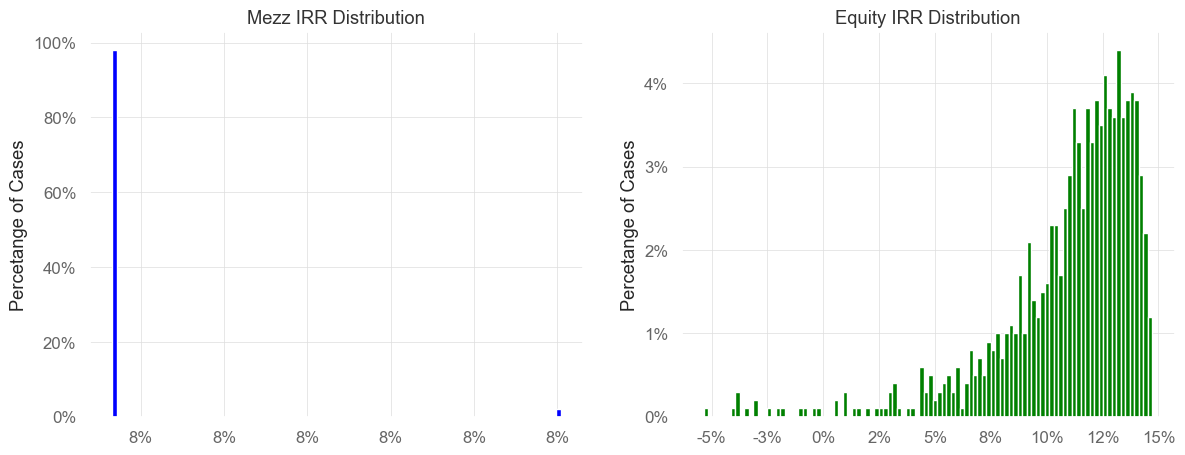

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  

df['Mezz IRR'].clip(lower=-100).plot(kind='hist', bins=100, ax=axs[0], title='Mezz IRR Distribution', color='blue')  
# axs[0].set_xlabel('Mezz IRR')  
axs[0].set_ylabel('Percetange of Cases')  
axs[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))  
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df), decimals=0))  
  
df['Equity IRR'].clip(lower=-100).plot(kind='hist', bins=100, ax=axs[1], title='Equity IRR Distribution', color='green')  
# axs[1].set_xlabel('Equity IRR')  
axs[1].set_ylabel('Percetange of Cases')  
axs[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))  
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df), decimals=0))  
  
plt.show()  

#tag the IRR results to cases then ivnestigate the default vector that led to it 
#look at the very worst one, draw the cashflow waterfall for that case 
#texas hedge, basis between the two. how would we actually value/mark this position, what are the drivers going into that, that's mainly the discount rate 
#can prolly get the IR01 from cashflow schedule. harder to get the CS01 unless we have the big correlation tables 
#calculate the correlation table using a loan tape, using a CDO pricer, or use implied price from market. that'll give us implied value from what 

DEFAULT RATES & TRANCHE THICKNESS

In [ ]:
# print('\nModel Test Results: DEFAULT RATES AND TRANCHE THICKNESS')

# # LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# # original_balance = 1000000000
# default_rates = np.arange(0.005, 0.05, 0.001).tolist()  
# tranche_size_equitys = np.arange(0.08, 0.12, 0.0025).tolist()  
# df = pd.DataFrame(columns=['Constant Default Rate', 'Tranche Size', 'IRR'])  

# for default_rate in default_rates:
#     for tranche_size_equity in tranche_size_equitys:
#         perf = ("Pool"            #this is for new assets added into the pool
#                 ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                 ,None
#                 ,None
#             )

#         test01 = Generic(
#             "TEST01"
#             ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
#             ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":pool_maturity_date}
#             ,{'assets':[["Mortgage"             #this is snapshot at issuance, confirmed unchanged. this is a fact
#                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                 ,"freq":"Monthly","type":"Even","originDate":start_date}
#                 ,{"currentBalance":original_pool_balance
#                 ,"currentRate":pool_rate
#                 ,"remainTerm":original_pool_term
#                 ,"status":"current"}]]}
#             ,(("acc01",{"balance":0}),("acc02",{"balance":original_pool_balance}))
#             ,(("S",{"balance":original_pool_balance * tranche_size_senior
#                     ,"rate":tranche_rate_senior
#                     ,"originBalance":original_pool_balance * tranche_size_senior
#                     ,"originRate":tranche_rate_senior
#                     ,"startDate":start_date
#                     ,"rateType":{"Fixed":tranche_rate_senior}
#                     ,"bondType":{"Sequential":None}})
#             ,("M",{"balance":original_pool_balance * tranche_size_mezz
#                     ,"rate":tranche_rate_mezz
#                     ,"originBalance":original_pool_balance * tranche_size_mezz
#                     ,"originRate":tranche_rate_mezz
#                     ,"startDate":start_date
#                     ,"rateType":{"Fixed":tranche_rate_mezz}
#                     ,"bondType":{"Sequential":None}
#                     })
#             ,("E",{"balance":original_pool_balance * tranche_size_equity
#                     ,"rate":tranche_rate_equity
#                     ,"originBalance":original_pool_balance * tranche_size_equity
#                     ,"originRate":tranche_rate_equity
#                     ,"startDate":start_date
#                     ,"rateType":{"Fixed":tranche_rate_equity}
#                     ,"bondType":{"Sequential":None}
#                     }))
#             ,list()
#             ,{"revolving":[
#                 ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
#                 ,['transfer',"acc02","acc01"]
#                 # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
#                 ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
#                 ]
#             ,"amortizing":[
#                 ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
#                 ,['transfer',"acc02","acc01"]
#                 # ,['payPrinBySeq',"acc01",["S","M","E"]]
#                 ,['payPrin',"acc01",["S","M","E"]]
#                 ,['payIntResidual',"acc01","E"]
#             ]
#             }
#             ,[["CollectedPrincipal","acc01"]
#             ,["CollectedInterest","acc02"]]
#             ,None
#             ,None
#             ,None    
#             ,{"BeforeDistribution":
#             {"dealStatusChange":
#                 {"condition":[">=",repay_date]
#                     ,"effects":("newStatus","Amortizing")
#                     ,"status":False
#                     ,"curable":False}}
#                 }
#             ,("PreClosing","Revolving")
#             )

#         runDealAssump = [("revolving"     #this is asumption about what happens during the revolving period, we care about what assets we buy, and hows their performance
#                             ,["constant"
#                             ,["Mortgage"     ##this is what the new assets look like 
#                                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                                 ,"freq":"Monthly","type":"Level","originDate":repay_date}
#                                 ,{"currentBalance":original_pool_balance
#                                 ,"currentRate":pool_rate
#                                 ,"remainTerm":original_pool_term
#                                 ,"status":"current"}]]
#                             ,perf)]

#         r = localAPI.run(test01
#                         ,runAssump = runDealAssump
#                         ,poolAssump = ("Pool"
#                                     ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                                     ,None
#                                     ,None)
#                         ,read=True)

#         def srt(firstLossBal, poolPerformance, issuePrice, feeRate, reinvestRate=reinvestment_rate):
            
#             poolDates = poolPerformance['pool']['flow'].index.to_list()
#             beginDate = poolDates[0]
#             lastDate = poolDates[-1]
#             start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
#             start['CumLossDerived'] = start['Loss'].cumsum()
            
#             #start.loc[:,'FeeBase'] = (start[''] - start['CumLoss']).clip(lower=0).to_list()#Balance
#             start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLossDerived']).clip(lower=0).to_list()#tranche balance
#             start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * feeRate / 12
            
#             start.loc[:,'feePayment'] = start['Balance'] * feeRate / 12
#             start.loc[:,'reimburseLoss'] = start['Loss']
#             start.loc[:,'netGuarantor'] = start['feePayment'] - start['reimburseLoss']

#             start.loc[:,'cashAccountChange'] = 0
#             start.loc[beginDate, 'cashAccountChange'] = issuePrice
#             start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLossDerived']

#             start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
#             start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12

#             start.loc[:,'netCashflow'] = 0 
#             start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
#             # start.loc[:,'netCashflow'] += start['feePayment'].fillna(0)
#             start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
#             start.loc[:,'netCashflow'] += start['cashAccountInt']
#             start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']    

#             return start


#         projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
#         a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
#         df = df.append({'Constant Default Rate': default_rate, 'Tranche Size': tranche_size_equity, 'IRR': a}, ignore_index=True)
#         print('Default Rate: ', default_rate, ' & Tranche Size: ', tranche_size_equity, ' & IRR: ', a)

In [ ]:
# df = df.sort_values(by='IRR', ascending=True)
# df.to_clipboard()

# # Convert values to percentages  
# df["Constant Default Rate"] = (df["Constant Default Rate"] * 100).round(2)  
# df["Tranche Size"] = (df["Tranche Size"] * 100).round(2)   
# df["IRR"] = (df["IRR"] * 100).round(2)  

# #round the percentage to 2 decimal places
# df["Constant Default Rate"] = df["Constant Default Rate"].round(2)


# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Constant Default Rate", "Tranche Size", "IRR")  
  
# # Convert the pivot table index and columns to np.meshgrid format  
# X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
# Z = pivot_table.values  
  
# # Plotting  
# fig = plt.figure()  
# ax = fig.add_subplot(111, projection='3d')  
  
# # Plot the 3D surface  
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# # Add color bar which maps values to colors  
# fig.colorbar(surf, shrink=0.5, aspect=5)  

# # Setting the axes labels with '%' sign  
# ax.set_xlabel('Tranche Size (%)')  
# ax.set_ylabel('Average Loss Rate (%)')  
# ax.set_zlabel('IRR (%)')  
  
# # Adjust the view angle  
# ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  
  
# plt.show()  

In [ ]:
# # Filter the DataFrame to select only the rows that have default rates in 0.5% increments  
# selected_rates = [0.5 * i for i in range(1, 11)]  
# selected_df = df[df['Constant Default Rate'].isin(selected_rates)]  
  
# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = selected_df.pivot("Tranche Size", "Constant Default Rate", "IRR")  
  
# # Plotting  
# plt.figure(figsize=(12, 8))  
  
# # Loop through the columns (each column is a different Constant Default Rate) to plot them  
# for column in pivot_table.columns:  
#     plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}% Loss Rate')  
#     # plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column:.2%} Default Rate')    

# plt.xlabel('Tranche Size (%)')  
# plt.ylabel('IRR (%)')  
# plt.title('IRR vs. Tranche Size for Different Average Loss Rates')  
# plt.legend(loc='best')  # Show legend to identify lines  
# plt.grid(True)  # Add grid for better readability  
# # plt.ylim(top=20)   # Set the y-axis limit to 20%

# plt.show()  

REPLENISHMENT PERIOD

In [ ]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
# print('\nModel Test Results: REPLENISHMENT PERIOD AND TRANCHE RATE')

# # LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# # original_balance = 1000000000
# repay_months = np.arange(21, 48, 3).tolist()  
# tranche_rate_equitys = np.arange(0.08, 0.15, 0.01).tolist()  
# df = pd.DataFrame(columns=['Replenishment Period', 'Tranche Rate', 'IRR'])  

# for repay_month in repay_months:
#     for tranche_rate_equity in tranche_rate_equitys:
#         perf = ("Pool"
#                 ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                 ,None
#                 ,None
#             )

#         test01 = Generic(
#             "TEST01"
#             ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
#             ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date}
#             ,{'assets':[["Mortgage"
#                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                 ,"freq":"Monthly","type":"Level","originDate":start_date}
#                 ,{"currentBalance":original_pool_balance
#                 ,"currentRate":pool_rate
#                 ,"remainTerm":original_pool_term
#                 ,"status":"current"}]]}
#             ,(("acc01",{"balance":0}),)
#             ,list()
#             ,list()
#             ,{"default":[
#                 ["IfElse"
#                 ,["status","Revolving"]
#                 ,[["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
#                 ]
#                 ,[]
#                 ]
#                 ]
#             }
#             ,[["CollectedCash","acc01"]]
#             ,None
#             ,None
#             ,None
#             ,{"BeforeDistribution":
#             {"dealStatusChange":
#                 {"condition":[">=",f"{repay_date}" ]
#                     ,"effects":("newStatus","Amortizing")
#                     ,"status":False
#                     ,"curable":False}}
#                 }
#             ,("PreClosing","Revolving")
#             )

#         r = localAPI.run(test01
#                         ,runAssump = [("revolving"
#                                         ,["constant"
#                                         ,["Mortgage"
#                                             ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                                             ,"freq":"Monthly","type":"Level","originDate":start_date}
#                                             ,{"currentBalance":original_pool_balance
#                                             ,"currentRate":tranche_rate_equity
#                                             ,"remainTerm":original_pool_term
#                                             ,"status":"current"}]]
#                                         ,perf)]
#                         ,poolAssump = ("Pool"
#                                     ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                                     ,None
#                                     ,None)
#                         ,read=True)

#         def srt(firstLossBal, poolPerformance, issuePrice, coupon, reinvestRate=reinvestment_rate):
            
#             poolDates = poolPerformance['pool']['flow'].index.to_list()
#             beginDate = poolDates[0]
#             lastDate = poolDates[-1]
            
#             start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
            
#             start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLoss']).clip(lower=0).to_list()
            
#             start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * coupon / 12
            
#             start.loc[:,'cashAccountChange'] = 0
#             start.loc[beginDate, 'cashAccountChange'] = issuePrice
#             start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLoss']

#             start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
#             start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
            
#             start.loc[:,'netCashflow'] = 0 
#             start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
#             start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
#             start.loc[:,'netCashflow'] += start['cashAccountInt']
#             start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']
#             return start

#         projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
#         a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
#         df = df.append({'Replenishment Period': repay_month, 'Tranche Rate': tranche_rate_equity, 'IRR': a}, ignore_index=True)
#         print('Replenishment Period: ', repay_month, ' & Tranche Rate: ', tranche_rate_equity, ' & IRR: ', a)

In [ ]:
# df.to_clipboard()

# # Convert values to percentages  
# # df["Replenishment Period"] *= 100  
# df["Tranche Rate"] *= 100  
# df["IRR"] *= 100  

# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Tranche Rate", "Replenishment Period", "IRR")  
  
# # Convert the pivot table index and columns to np.meshgrid format  
# X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
# Z = pivot_table.values  
  
# # Plotting  
# fig = plt.figure()  
# ax = fig.add_subplot(111, projection='3d')  
  
# # Plot the 3D surface  
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# # Add color bar which maps values to colors  
# fig.colorbar(surf, shrink=0.5, aspect=5)  

# # Setting the axes labels with '%' sign  
# ax.set_xlabel('Replenishment Period (Months)')  
# ax.set_ylabel('Tranche Rate (%)')  
# ax.set_zlabel('IRR (%)')  
  
# # Adjust the view angle  
# ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  
  
# plt.show()  

In [ ]:
# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Replenishment Period", "Tranche Rate", "IRR")  
  
# # Plotting  
# plt.figure(figsize=(12, 8))  
  
# # Loop through the columns (each column is a different Constant Default Rate) to plot them  
# for column in pivot_table.columns:  
#     plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}% Tranche Rate')  
  
# plt.xlabel('Replenishment Period (%)')  
# plt.ylabel('IRR (%)')  
# plt.title('IRR vs. Replenishment Period for Different Tranche Rates')  
# plt.legend(loc='best')  # Show legend to identify lines  
# plt.grid(True)  # Add grid for better readability  
  
# plt.show()  

TRANCHE RATE AND COLLATERAL POOL RATE

In [ ]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
# print('\nModel Test Results: TRANCHE AND COLLATERAL COUPON RATES')

# # LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# tranche_rate_equitys = np.arange(0.05, 0.15, 0.01).tolist()  
# pool_rates = np.arange(0.04, 0.2, 0.01).tolist()  
# df = pd.DataFrame(columns=['Tranche Rate', 'Pool Rate', 'IRR'])  

# for tranche_rate_equity in tranche_rate_equitys:
#     for pool_rate in pool_rates:
#         perf = ("Pool"
#                 ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                 ,None
#                 ,None
#             )

#         test01 = Generic(
#             "TEST01"
#             ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
#             ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date}
#             ,{'assets':[["Mortgage"
#                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                 ,"freq":"Monthly","type":"Level","originDate":start_date}
#                 ,{"currentBalance":original_pool_balance
#                 ,"currentRate":pool_rate
#                 ,"remainTerm":original_pool_term
#                 ,"status":"current"}]]}
#             ,(("acc01",{"balance":0}),)
#             ,list()
#             ,list()
#             ,{"default":[
#                 ["IfElse"
#                 ,["status","Revolving"]
#                 ,[["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
#                 ]
#                 ,[]
#                 ]
#                 ]
#             }
#             ,[["CollectedCash","acc01"]]
#             ,None
#             ,None
#             ,None
#             ,{"BeforeDistribution":
#             {"dealStatusChange":
#                 {"condition":[">=",f"{repay_date}" ]
#                     ,"effects":("newStatus","Amortizing")
#                     ,"status":False
#                     ,"curable":False}}
#                 }
#             ,("PreClosing","Revolving")
#             )

#         r = localAPI.run(test01
#                         ,runAssump = [("revolving"
#                                         ,["constant"
#                                         ,["Mortgage"
#                                             ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                                             ,"freq":"Monthly","type":"Level","originDate":start_date}
#                                             ,{"currentBalance":original_pool_balance
#                                             ,"currentRate":tranche_rate_equity
#                                             ,"remainTerm":original_pool_term
#                                             ,"status":"current"}]]
#                                         ,perf)]
#                         ,poolAssump = ("Pool"
#                                     ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                                     ,None
#                                     ,None)
#                         ,read=True)

#         def srt(firstLossBal, poolPerformance, issuePrice, coupon, reinvestRate=reinvestment_rate):
            
#             poolDates = poolPerformance['pool']['flow'].index.to_list()
#             beginDate = poolDates[0]
#             lastDate = poolDates[-1]
            
#             start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
            
#             start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLoss']).clip(lower=0).to_list()
            
#             start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * coupon / 12
            
#             start.loc[:,'cashAccountChange'] = 0
#             start.loc[beginDate, 'cashAccountChange'] = issuePrice
#             start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLoss']

#             start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
#             start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
            
#             start.loc[:,'netCashflow'] = 0 
#             start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
#             start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
#             start.loc[:,'netCashflow'] += start['cashAccountInt']
#             start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']
#             return start

#         projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
#         a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
#         df = df.append({'Tranche Rate': tranche_rate_equity, 'Pool Rate': pool_rate, 'IRR': a}, ignore_index=True)
#         print('Tranche Rate: ', tranche_rate_equity, ' & Pool Rate: ', pool_rate, ' & IRR: ', a)

In [ ]:
# df = df.sort_values(by='IRR', ascending=True)
# df.to_clipboard()

# # Convert values to percentages  
# df["Tranche Rate"] = (df["Tranche Rate"] * 100).round(2)  
# df["Pool Rate"] = (df["Pool Rate"] * 100).round(2)   
# df["IRR"] = (df["IRR"] * 100).round(2)  

# #round the percentage to 2 decimal places
# df["Tranche Rate"] = df["Tranche Rate"].round(2)


# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Tranche Rate", "Pool Rate", "IRR")  
  
# # Convert the pivot table index and columns to np.meshgrid format  
# X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
# Z = pivot_table.values  
  
# # Plotting  
# fig = plt.figure()  
# ax = fig.add_subplot(111, projection='3d')  
  
# # Plot the 3D surface  
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# # Add color bar which maps values to colors  
# fig.colorbar(surf, shrink=0.5, aspect=5)  

# # Setting the axes labels with '%' sign  
# ax.set_xlabel('Tranche Rate (%)')  
# ax.set_ylabel('Pool Rate (%)')  
# ax.set_zlabel('IRR (%)')  
  
# # Adjust the view angle  
# ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  
  
# plt.show()  

In [ ]:
# # # Filter the DataFrame to select only the rows that have default rates in 0.5% increments  
# # selected_rates = [0.5 * i for i in range(1, 11)]  
# # selected_df = df[df['Constant Default Rate'].isin(selected_rates)]  
  
# # Pivot the DataFrame to create a 2D grid of IRR values  
# # pivot_table = selected_df.pivot("Tranche Size", "Constant Default Rate", "IRR")  
# pivot_table = df.pivot("Tranche Rate", "Pool Rate", "IRR")  

# # Plotting  
# plt.figure(figsize=(12, 8))  
  
# # Loop through the columns (each column is a different Constant Default Rate) to plot them  
# for column in pivot_table.columns:  
#     plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}% Pool Rate')  
#     # plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column:.2%} Default Rate')    

# plt.xlabel('Tranche Rate (%)')  
# plt.ylabel('IRR (%)')  
# plt.title('IRR vs. Tranche Rate for Different Collateral Pool Rates')  
# plt.legend(loc='best')  # Show legend to identify lines  
# plt.grid(True)  # Add grid for better readability  
# # plt.ylim(top=20)   # Set the y-axis limit to 20%

# plt.show()  

RECOVERY RATE AND LAG TIME

In [ ]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
# print('\nModel Test Results: TRANCHE AND COLLATERAL COUPON RATES')

# # LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# recovery_rates = np.arange(0.0, 1.0, 0.05).tolist()  
# recovery_lags = np.arange(0, 24, 1).tolist()  
# df = pd.DataFrame(columns=['Recovery Rate', 'Recovery Lag', 'IRR'])  

# for recovery_rate in recovery_rates:
#     for recovery_lag in recovery_lags:
#         perf = ("Pool"
#                 ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                 ,None
#                 ,None
#             )

#         test01 = Generic(
#             "TEST01"
#             ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
#             ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date}
#             ,{'assets':[["Mortgage"
#                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                 ,"freq":"Monthly","type":"Level","originDate":start_date}
#                 ,{"currentBalance":original_pool_balance
#                 ,"currentRate":pool_rate
#                 ,"remainTerm":original_pool_term
#                 ,"status":"current"}]]}
#             ,(("acc01",{"balance":0}),)
#             ,list()
#             ,list()
#             ,{"default":[
#                 ["IfElse"
#                 ,["status","Revolving"]
#                 ,[["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
#                 ]
#                 ,[]
#                 ]
#                 ]
#             }
#             ,[["CollectedCash","acc01"]]
#             ,None
#             ,None
#             ,None
#             ,{"BeforeDistribution":
#             {"dealStatusChange":
#                 {"condition":[">=",f"{repay_date}" ]
#                     ,"effects":("newStatus","Amortizing")
#                     ,"status":False
#                     ,"curable":False}}
#                 }
#             ,("PreClosing","Revolving")
#             )

#         r = localAPI.run(test01
#                         ,runAssump = [("revolving"
#                                         ,["constant"
#                                         ,["Mortgage"
#                                             ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                                             ,"freq":"Monthly","type":"Level","originDate":start_date}
#                                             ,{"currentBalance":original_pool_balance
#                                             ,"currentRate":tranche_rate_equity
#                                             ,"remainTerm":original_pool_term
#                                             ,"status":"current"}]]
#                                         ,perf)]
#                         ,poolAssump = ("Pool"
#                                     ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                                     ,None
#                                     ,None)
#                         ,read=True)

#         def srt(firstLossBal, poolPerformance, issuePrice, coupon, reinvestRate=reinvestment_rate):
            
#             poolDates = poolPerformance['pool']['flow'].index.to_list()
#             beginDate = poolDates[0]
#             lastDate = poolDates[-1]
            
#             start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
            
#             start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLoss']).clip(lower=0).to_list()
            
#             start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * coupon / 12
            
#             start.loc[:,'cashAccountChange'] = 0
#             start.loc[beginDate, 'cashAccountChange'] = issuePrice
#             start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLoss']

#             start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
#             start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
            
#             start.loc[:,'netCashflow'] = 0 
#             start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
#             start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
#             start.loc[:,'netCashflow'] += start['cashAccountInt']
#             start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']
#             return start

#         projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
#         a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
#         df = df.append({'Recovery Rate': recovery_rate, 'Recovery Lag': recovery_lag, 'IRR': a}, ignore_index=True)
#         print('Recovery Rate: ', recovery_rate, ' & Recovery Lag: ', recovery_lag, ' & IRR: ', a)

In [ ]:
# df.to_clipboard()

# # Convert values to percentages  
# # df["Replenishment Period"] *= 100  
# df["Recovery Rate"] *= 100  
# df["IRR"] *= 100  

# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Recovery Rate", "Recovery Lag", "IRR")  
  
# # Convert the pivot table index and columns to np.meshgrid format  
# X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
# Z = pivot_table.values  
  
# # Plotting  
# fig = plt.figure()  
# ax = fig.add_subplot(111, projection='3d')  
  
# # Plot the 3D surface  
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# # Add color bar which maps values to colors  
# fig.colorbar(surf, shrink=0.5, aspect=5)  

# # Setting the axes labels with '%' sign  
# ax.set_xlabel('Recovery Lag (Months)')  
# ax.set_ylabel('Recovery Rate (%)')  
# ax.set_zlabel('IRR (%)')  
  
# # Adjust the view angle  
# ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  
  
# plt.show()  

In [ ]:
# # Convert values to percentages  
# df["Recovery Rate"] = (df["Recovery Rate"] * 1).round(2)  
# df["IRR"] = (df["IRR"] * 1).round(2)  

# # Filter the DataFrame to select only the rows that have default rates in 0.5% increments  
# selected_rates = [10 * i for i in range(1, 11)]  
# selected_df = df[df['Recovery Rate'].isin(selected_rates)]  
  
# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = selected_df.pivot("Recovery Lag", "Recovery Rate", "IRR")  
# # pivot_table = df.pivot("Recovery Lag", "Recovery Rate", "IRR")  
  
# # Plotting  
# plt.figure(figsize=(12, 8))  
  
# # Loop through the columns (each column is a different Constant Default Rate) to plot them  
# for column in pivot_table.columns:  
#     plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}% Recovery Rate')  
  
# plt.xlabel('Recovery Lag (%)')  
# plt.ylabel('IRR (%)')  
# plt.title('IRR vs. Recovery Lag for Different Recovery Rates')  
# plt.legend(loc='best')  # Show legend to identify lines  
# plt.grid(True)  # Add grid for better readability  
  
# plt.show()  

REPLENISHMENT PERIOD AND DEAL LIFE

In [ ]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
# print('\nModel Test Results: REPLENISHMENT PERIOD AND TRANCHE RATE')

# # LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# # original_balance = 1000000000

# repay_months = np.arange(0, 72, 3).tolist()  
# months_to_calls = np.arange(0, 72, 3).tolist()  
# df = pd.DataFrame(columns=['Replenishment Period', 'Deal Life', 'IRR'])  

# for repay_month in repay_months:
#     for months_to_call in months_to_calls:
#         # date = datetime.date(2024, 1, 31)  
#         start_date = '2024-01-31'
#         first_pay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+1)  
#         first_pay_date = first_pay_date.strftime('%Y-%m-%d')
#         # repay_month = 36     #[24, 30, 36, 42, 48]     #sensitize this
#         repay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+repay_month)  
#         repay_date = repay_date.strftime('%Y-%m-%d')  

#         # Deal assumptions
#         original_deal_maturity = 6
#         original_deal_term = maturity*12
#         deal_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_deal_term)
#         deal_maturity_date = deal_maturity_date.strftime('%Y-%m-%d')  
#         tranche_size_equity = 0.1     #sensitize this, when set to 1, is it just the pool
#         issue_price = 1   #can assume back leverage with a value between 0 and 1
#         tranche_rate_equity = 0.1     #make sure if this is coupon rate on the tranche  
#         # months_to_call = 72
#         deal_call_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+months_to_call)
#         deal_call_date = deal_call_date.strftime('%Y-%m-%d')  

#         # Pool assumptions 
#         original_pool_balance = 3_000_000_000
#         original_pool_maturity = 3
#         original_pool_term = original_pool_maturity*12
#         pool_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_pool_term)
#         pool_maturity_date = pool_maturity_date.strftime('%Y-%m-%d')  
#         pool_rate = 0.07
#         default_rate = 0.01    #   [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 
#         # defaultFactor = [["2020-10-01",1.05],["2022-10-01",1.15]]
#         default_rate = default_rate
#         pool_cpr = 0.25   # amortization rate
#         recovery_rate = 1 - (0.3 * 0.7 + 0.15 * 0.3)   #sensitize this
#         recovery_lag = 6   #in months
#         reinvestment_rate = 0.00      #replenishment rate for the defaulted positions need to make assumptions too    #risk free rate 
        
#         perf = ("Pool"
#                 ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                 ,None
#                 ,None
#             )

#         test01 = Generic(
#             "TEST01"
#             ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
#             ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date}
#             ,{'assets':[["Mortgage"
#                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                 ,"freq":"Monthly","type":"Level","originDate":start_date}
#                 ,{"currentBalance":original_pool_balance
#                 ,"currentRate":pool_rate
#                 ,"remainTerm":original_pool_term
#                 ,"status":"current"}]]}
#             ,(("acc01",{"balance":0}),)
#             ,list()
#             ,list()
#             ,{"default":[
#                 ["IfElse"
#                 ,["status","Revolving"]
#                 ,[["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
#                 ]
#                 ,[]
#                 ]
#                 ]
#             }
#             ,[["CollectedCash","acc01"]]
#             ,None
#             ,None
#             ,None
#             ,{"BeforeDistribution":
#             {"dealStatusChange":
#                 {"condition":[">=",f"{repay_date}" ]
#                     ,"effects":("newStatus","Amortizing")
#                     ,"status":False
#                     ,"curable":False}}
#                 }
#             ,("PreClosing","Revolving")
#             )

#         r = localAPI.run(test01
#                         ,runAssump = [("revolving"
#                                         ,["constant"
#                                         ,["Mortgage"
#                                             ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                                             ,"freq":"Monthly","type":"Level","originDate":start_date}
#                                             ,{"currentBalance":original_pool_balance
#                                             ,"currentRate":tranche_rate_equity
#                                             ,"remainTerm":original_pool_term
#                                             ,"status":"current"}]]
#                                         ,perf)
#                                         ,("call",{"afterDate":deal_call_date})
#                                         ]
#                         ,poolAssump = ("Pool"
#                                     ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                                     ,None
#                                     ,None)
#                         ,read=True)

#         def srt(firstLossBal, poolPerformance, issuePrice, coupon, reinvestRate=reinvestment_rate):
            
#             poolDates = poolPerformance['pool']['flow'].index.to_list()
#             beginDate = poolDates[0]
#             lastDate = poolDates[-1]
            
#             start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
            
#             start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLoss']).clip(lower=0).to_list()
            
#             start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * coupon / 12
            
#             start.loc[:,'cashAccountChange'] = 0
#             start.loc[beginDate, 'cashAccountChange'] = issuePrice
#             start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLoss']

#             start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
#             start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
            
#             start.loc[:,'netCashflow'] = 0 
#             start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
#             start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
#             start.loc[:,'netCashflow'] += start['cashAccountInt']
#             start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']
#             return start

#         projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
#         a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
#         df = df.append({'Replenishment Period': repay_month, 'Deal Life': months_to_call, 'IRR': a}, ignore_index=True)
#         print('Replenishment Period: ', repay_month, ' & Deal Life: ', months_to_call, ' & IRR: ', a)


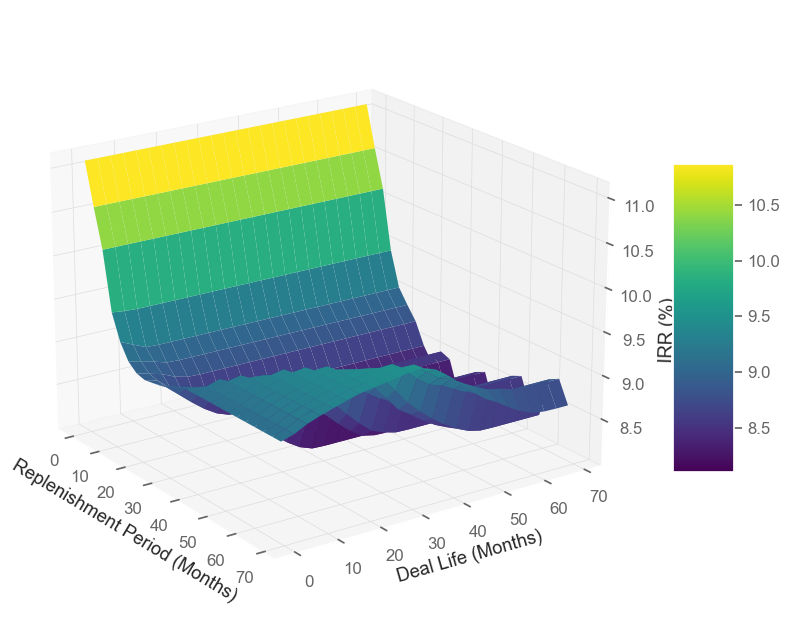

In [ ]:
df.to_clipboard()

# Convert values to percentages  
df["Replenishment Period"] = (df["Replenishment Period"] * 1).round(0)
df["Deal Life"] = (df["Deal Life"] * 1).round(0)
df["IRR"] *= 100 

# Pivot the DataFrame to create a 2D grid of IRR values  
pivot_table = df.pivot("Replenishment Period", "Deal Life", "IRR")  
  
# Convert the pivot table index and columns to np.meshgrid format  
X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
Z = pivot_table.values  
  
# Plotting  
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')  
  
# Plot the 3D surface  
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# Add color bar which maps values to colors  
fig.colorbar(surf, shrink=0.5, aspect=5)  

# Setting the axes labels with '%' sign  
ax.set_xlabel('Replenishment Period (Months)')  
ax.set_ylabel('Deal Life (Months)')  
ax.set_zlabel('IRR (%)')  
  
# Adjust the view angle  
ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  

plt.show()  

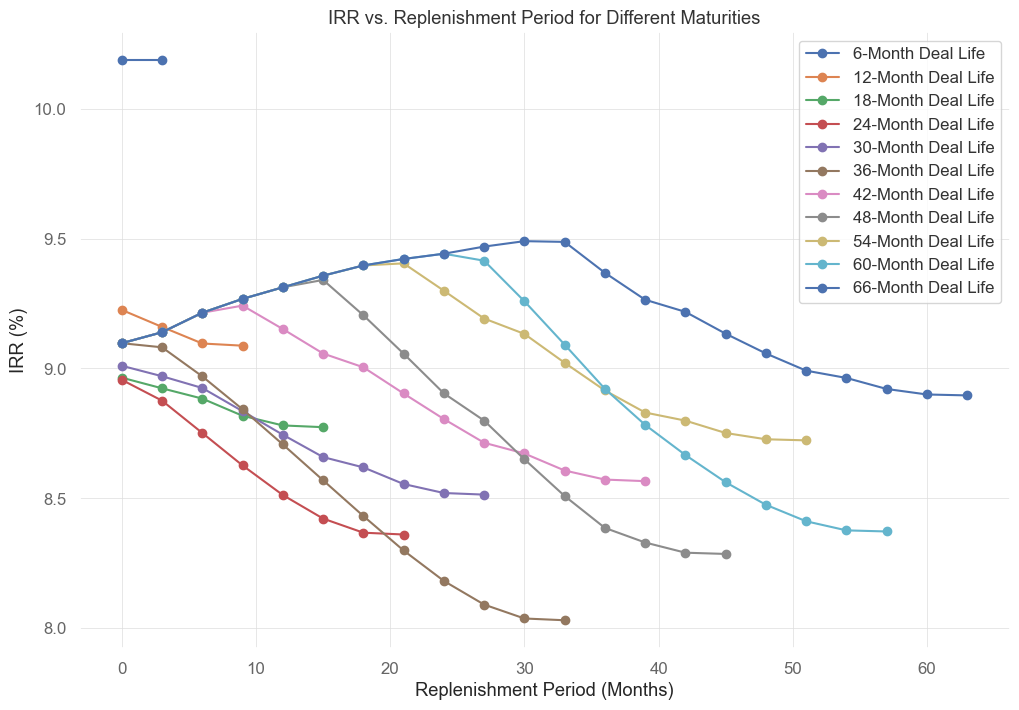

In [ ]:
# Filter the DataFrame to select only the rows that have default rates in 0.5% increments  
selected_dates = [6 * i for i in range(1, 13)]  
selected_df = df[df['Deal Life'].isin(selected_dates)]  

# select only the rows where deal life is longer than replenishment period
selected_df = selected_df[selected_df['Deal Life'] > selected_df['Replenishment Period']]
selected_df["Deal Life"] = selected_df["Deal Life"].astype(int)

# Pivot the DataFrame to create a 2D grid of IRR values  
pivot_table = selected_df.pivot("Replenishment Period", "Deal Life", "IRR")  
# pivot_table = df.pivot("Replenishment Period", "Deal Life", "IRR")  
  
# Plotting  
plt.figure(figsize=(12, 8))  
  
# Loop through the columns (each column is a different Constant Default Rate) to plot them  
for column in pivot_table.columns:  
    plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}-Month Deal Life')  

plt.xlabel('Replenishment Period (Months)')  
plt.ylabel('IRR (%)')  
plt.title('IRR vs. Replenishment Period for Different Maturities')  
plt.legend(loc='best')  # Show legend to identify lines  
plt.grid(True)  # Add grid for better readability  
  
plt.show()  

GOAL SEEK

In [ ]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
from scipy import optimize
def f(x):
    return (x**3 - 1)  # only one real root at x = 1
def fprime(x):
    return 3*x**2
# The brentq method takes as input a bracket

sol = optimize.root_scalar(f, bracket=[0, 3], method='brentq')
sol.root, sol.iterations, sol.function_calls
(1.0, 10, 11)
# The newton method takes as input a single point and uses the derivative(s).

sol = optimize.root_scalar(f, x0=0.2, fprime=fprime, method='newton')
sol.root, sol.iterations, sol.function_calls
(1.0, 11, 22)
# The function can provide the value and derivative(s) in a single call.

def f_p_pp(x):
    return (x**3 - 1), 3*x**2, 6*x
sol = optimize.root_scalar(
    f_p_pp, x0=0.2, fprime=True, method='newton'
)
sol.root, sol.iterations, sol.function_calls
(1.0, 11, 11)
sol = optimize.root_scalar(
    f_p_pp, x0=0.2, fprime=True, fprime2=True, method='halley'
)
sol.root, sol.iterations, sol.function_calls
(1.0, 7, 8)

(1.0, 7, 8)

In [ ]:
def f(disc):
    ' Create function that calculates error between x and target '
    df = pd.DataFrame({'Income':[100*1.08**i for i in range(5)], 
                       'Discount_vector':[disc**(-i) for i in range(5)]})

    df['PV of CF'] = df['Income'] * df['Discount_vector']
    x = df['PV of CF'].sum()
    
    target = 545
    error = x - target
    return error**2     

# Starting discount rate
start = 1.04

# Find min of f starting at start
start = 1.04
discount = fmin(f, [start]) 

print(f'Discount = {discount}')

Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 13
         Function evaluations: 26
Discount = [1.03537891]


Sanity Check

put in a super simple portfolio, set default rate to 0, then make sure it gives the right IRR 
do not tranche it yet, but put in default rate, make sure IRR is close to original IRR - defaults 
then play with recovery, then tranche it 
set it up to have both attach and detach 
test to make sure cashflow logic is really tight
projectCf['netCashflow'].sum() - projectCf['cashAccountBal'].iloc[0] + projectCf['cashAccountBal'].iloc[-1]
make sure simple changes that should change the cashflow schedule, make sure model is working as expected

In [ ]:
# scenarioMap = {
#   "base":("Pool"
#           ,("Fixed",[["2024-01-01",0.3]
#                     ,["2025-01-01",0.25]
#                     ,["2026-01-01",0.2]]
#                    ,[["2024-01-01",0.9]
#                     ,["2025-01-01",0.85]
#                     ,["2026-01-01",0.8]])
#           ,None
#           ,None)
#   ,"lowUtil" :("Pool"
#               ,("Fixed",[["2024-01-01",0.3]
#                         ,["2025-01-01",0.25]
#                         ,["2026-01-01",0.2]]
#                        ,[["2024-01-01",0.85]
#                         ,["2025-01-01",0.80]
#                         ,["2026-01-01",0.75]])
#               ,None
#               ,None)
#  ,"lowPrice" : ("Pool"
#               ,("Fixed",[["2024-01-01",0.3]
#                         ,["2025-01-01",0.225]
#                         ,["2026-01-01",0.19]]
#                        ,[["2024-01-01",0.9]
#                         ,["2025-01-01",0.85]
#                         ,["2026-01-01",0.8]])
#               ,None
#               ,None)
#  }
# p = localAPI.run(projectCf,poolAssump=scenarioMap
#                      ,runAssump=[("call",{"afterDate":"2027-05-31"})
#                                 ,("report",{"dates":"MonthEnd"})]
#                      ,read=True)

# {k:irr(v['bonds']['EQ'],init=('2024-01-01',-7000))
#   for k,v in p.items()}


In [ ]:
# # Fixing random state for reproducibility
# np.random.seed(19680801)

# def randrange(n, vmin, vmax):
#     """
#     Helper function to make an array of random numbers having shape (n, )
#     with each number distributed Uniform(vmin, vmax).
#     """
#     return (vmax - vmin)*np.random.rand(n) + vmin

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# n = 100

# # For each set of style and range settings, plot n random points in the box
# # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)
#     ax.scatter(xs, ys, zs, marker=m)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()